# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk

In [4]:
import networkx as nx

# Setting

In [5]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [6]:
setting = Setting()

# Dataset

## Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

### Load all data

In [7]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between
    
    
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

### Split Data

In [8]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)
            
split_data(path=setting.data_split, x=synthetic, y=between)

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [10]:
def to_data(x, y):
    edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    ### between centrality
    bcs = []
    bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
    bc = bc.t().contiguous()
    row, col = bc
    bc = col
    bc = bc.numpy()
    bcs = torch.from_numpy(
            np.array([[b] for b in bc], dtype=np.float))

    data = Data(x=vertice, edge_index=edge_index, y=bcs)
    
    return data

#### Read data

In [11]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

#### Cvt

In [12]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

#### Use all data

In [13]:
all_loader = to_dataloader(synthetic, between, batch=1)

#### Use YT data

In [14]:
# yt_loader = to_dataloader(yt, yt_score, batch=1)

# Model

## Hyper params

In [15]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

# setting.params_node2vec = dict(
#     edge_index, 
#     embedding_dim, 
#     walk_length = 10, 
#     context_size,
#     p = 1,
#     q = 2
# )

## DrBC

In [16]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [17]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [18]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [19]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [20]:
from torch_geometric.nn import Node2Vec

In [21]:
class BC_node2vec(nn.Module):
    
    def __init__(self, node2vec_params):
        super().__init__()
        
        self.node2vec = Node2Vec(**node2vec_params)
        self.mlp = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, data):
        
        x = self.node2vec(data)
        x = self.mlp(x)
        
        return x

# Load model

In [30]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(setting.device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

# Evaluation

### Top k %

In [31]:
def top_n(model, data, k):

    with torch.no_grad():

        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]
        k = int(nodes * k / 100)

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().to(setting.device)
        bc_pr = bc_pr.squeeze()

        gt_value, gt_indice = torch.topk(bc_gt, k)
        pr_value, pr_indice = torch.topk(bc_pr, k)

        gt_indice = set(gt_indice.cpu().numpy())
        pr_indice = set(pr_indice.cpu().numpy())

        intersect = len(gt_indice & pr_indice)
        top = intersect/k
            
       

        return top

### Tau Kendal

In [32]:
from scipy import stats

def tau_distance(model, data):
    
    
    with torch.no_grad():
 
        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().cpu().numpy()
        bc_pr = bc_pr.squeeze().cpu().numpy()


        tau, p_value = stats.kendalltau(bc_gt, bc_pr)
       

    return tau

### Evaluation Mode

In [37]:
def eval_model(model, data):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item()

In [38]:
def from_networkx(G, between_list):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    data['y'] = torch.from_numpy(
        np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

# Train

In [39]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

use a new optimizer


In [40]:
nodes_cnt = 300


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = list(betweenness.values())
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    

    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    bc_gt = pyg_data.y
#     bc_gt = np.array(bc_gt)
#     bc_gt = torch.from_numpy(bc_gt)
    bc_gt = torch.reshape(bc_gt, (-1, ))

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation:- Train
    top1 = top_n(model, pyg_data, k=1)
    top5 = top_n(model, pyg_data, k=5)
    top10 = top_n(model, pyg_data, k=10)
    kendal = tau_distance(model, pyg_data)

    print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            loss.item(),
            top1,
            top5,
            top10,
            kendal
    ))

    train_info["bce"].append(loss.item())
    train_info["top1"].append(top1)
    train_info["top5"].append(top5)
    train_info["top10"].append(top10)
    train_info["kendal"].append(kendal)

    with open(setting.train_info_p, 'w') as f:
        json.dump(train_info, f)



    ### Evaluation:- Synthetic
    bce_l = []
    top1_l = []
    top5_l = []
    top10_l = []
    kendal_l = []

    for data in all_loader:
        bce_l.append(eval_model(model, data))
        top1_l.append(top_n(model, data, k=1))
        top5_l.append(top_n(model, data, k=5))
        top10_l.append(top_n(model, data, k=10))
        kendal_l.append(tau_distance(model, data))
        
    bce = sum(bce_l)/len(bce_l)
    top1 = sum(top1_l)/len(top1_l)
    top5 = sum(top5_l)/len(top5_l)
    top10 = sum(top10_l)/len(top10_l)
    kendal = sum(kendal_l)/len(kendal_l)
        
    print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
        bce,
        top1,
        top5,
        top10,
        kendal
    ))

    valid_info["bce"].append(bce)
    valid_info["top1"].append(top1)
    valid_info["top5"].append(top5)
    valid_info["top10"].append(top10)
    valid_info["kendal"].append(kendal)

    with open(setting.val_info_p, 'w') as f:
        json.dump(valid_info, f)
        
    
    if top10 > top_10:
        checkpoint = {
            'model_stat': model.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, setting.weight_drbc)
        top_10 = top10


Epoch: 1
Train: loss = 1039.7324046263316, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0, kendal = -0.6485172798216278
Valid: loss = 17328.717506919333, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0002, kendal = -0.4895597146095886

Epoch: 2
Train: loss = 1039.728002602888, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0, kendal = -0.4280490523968785
Valid: loss = 17328.7054746935, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0002666666666666667, kendal = -0.47677789424551587

Epoch: 3
Train: loss = 1039.7255062924382, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0, kendal = -0.015384615384615387
Valid: loss = 17328.695997415773, top 1 = 0.0, top 5 = 0.0, top 10 = 0.0002666666666666667, kendal = -0.4372715503100619

Epoch: 4
Train: loss = 1039.7214134554529, top 1 = 0.0, top 5 = 0.0, top 10 = 0.03333333333333333, kendal = 0.3218283166109253
Valid: loss = 17328.68877948766, top 1 = 0.0, top 5 = 0.0016000000000000005, top 10 = 0.005466666666666669, kendal = -0.3372838087617523

Epoch: 5
Train: loss = 1039.7186568225707, top 

Valid: loss = 17328.922903323728, top 1 = 0.6573333333333333, top 5 = 0.6242666666666667, top 10 = 0.6207333333333335, kendal = 0.3659522731212909

Epoch: 32
Train: loss = 1039.6808006539452, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7281159420289857
Valid: loss = 17328.93253199262, top 1 = 0.6573333333333333, top 5 = 0.6237333333333334, top 10 = 0.6203333333333334, kendal = 0.3667780062679203

Epoch: 33
Train: loss = 1039.6642678823084, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7168338907469343
Valid: loss = 17328.94313105375, top 1 = 0.6573333333333333, top 5 = 0.624, top 10 = 0.6202666666666666, kendal = 0.36703478295659137

Epoch: 34
Train: loss = 1039.6663313050897, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.724593088071349
Valid: loss = 17328.95045539214, top 1 = 0.6579999999999999, top 5 = 0.624, top 10 = 0.6202000000000001, kendal = 0.36781656064546253

Epoch: 35



Epoch: 61
Train: loss = 1039.665973271648, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.7605351170568562
Valid: loss = 17329.134983114043, top 1 = 0.6566666666666667, top 5 = 0.6190666666666668, top 10 = 0.6174666666666667, kendal = 0.3867291858371675

Epoch: 62
Train: loss = 1039.6608361382073, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7615161649944259
Valid: loss = 17329.14124387764, top 1 = 0.6566666666666667, top 5 = 0.6190666666666668, top 10 = 0.6174666666666666, kendal = 0.3872285443755417

Epoch: 63
Train: loss = 1039.6618228602545, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.7846599777034561
Valid: loss = 17329.13881957767, top 1 = 0.6566666666666667, top 5 = 0.6190666666666668, top 10 = 0.6174000000000001, kendal = 0.387793201306928

Epoch: 64
Train: loss = 1039.6670814171093, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.758706800445931
Valid: loss = 17329.139752267518, top 1 = 0.65666666


Epoch: 90
Train: loss = 1039.652955418057, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7772129319955408
Valid: loss = 17329.28802109997, top 1 = 0.6553333333333334, top 5 = 0.6178666666666668, top 10 = 0.6150000000000001, kendal = 0.41033071147562844

Epoch: 91
Train: loss = 1039.6369306861668, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.7823411371237459
Valid: loss = 17329.303948401324, top 1 = 0.6553333333333334, top 5 = 0.6178666666666668, top 10 = 0.6152666666666669, kendal = 0.410759549243182

Epoch: 92
Train: loss = 1039.6547518766843, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.771103678929766
Valid: loss = 17329.31932983748, top 1 = 0.6553333333333334, top 5 = 0.6178666666666668, top 10 = 0.6154666666666667, kendal = 0.41107073681402956

Epoch: 93
Train: loss = 1039.6425461231188, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.7441248606465999
Valid: loss = 17329.


Epoch: 119
Train: loss = 1039.650892271965, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7877814938684504
Valid: loss = 17329.422455706943, top 1 = 0.6553333333333334, top 5 = 0.6177333333333335, top 10 = 0.6198, kendal = 0.42266101220244046

Epoch: 120
Train: loss = 1039.6330682001867, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.7581716833890747
Valid: loss = 17329.41678611442, top 1 = 0.6553333333333334, top 5 = 0.6178666666666668, top 10 = 0.6202000000000001, kendal = 0.42367984530239383

Epoch: 121
Train: loss = 1039.6482780739473, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7880490523968785
Valid: loss = 17329.416325098144, top 1 = 0.6553333333333334, top 5 = 0.6181333333333333, top 10 = 0.6202666666666666, kendal = 0.42470126558645066

Epoch: 122
Train: loss = 1039.6470525026948, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.7692307692307693
Valid: lo


Epoch: 148
Train: loss = 1039.6521218172948, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8057971014492754
Valid: loss = 17329.64020793592, top 1 = 0.6546666666666667, top 5 = 0.6194666666666666, top 10 = 0.6279333333333333, kendal = 0.42627491898379677

Epoch: 149
Train: loss = 1039.6432178553432, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.8069119286510591
Valid: loss = 17329.629411434307, top 1 = 0.6546666666666667, top 5 = 0.6196, top 10 = 0.6282000000000001, kendal = 0.42738784023471355

Epoch: 150
Train: loss = 1039.6482080050423, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.7756075808249722
Valid: loss = 17329.600752283466, top 1 = 0.6546666666666667, top 5 = 0.6197333333333332, top 10 = 0.6284666666666667, kendal = 0.4289203227312129

Epoch: 151
Train: loss = 1039.6631901026135, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7917948717948718
Valid: lo

Valid: loss = 17329.54746799552, top 1 = 0.6546666666666667, top 5 = 0.6204000000000001, top 10 = 0.6318666666666667, kendal = 0.42277692338467704

Epoch: 178
Train: loss = 1039.6221699193077, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9666666666666667, kendal = 0.7913935340022297
Valid: loss = 17329.573010164804, top 1 = 0.6546666666666667, top 5 = 0.6209333333333334, top 10 = 0.6321333333333334, kendal = 0.4199694338867773

Epoch: 179
Train: loss = 1039.6465319600156, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7894760312151616
Valid: loss = 17329.59404916665, top 1 = 0.6546666666666667, top 5 = 0.6210666666666668, top 10 = 0.6325333333333334, kendal = 0.4176338947789559

Epoch: 180
Train: loss = 1039.6445743723425, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8010702341137125
Valid: loss = 17329.61091813757, top 1 = 0.6546666666666667, top 5 = 0.6209333333333333, top 10 = 0.6326666666666668, kendal = 0.4158188170967528

Epoch: 181



Epoch: 207
Train: loss = 1039.6437286486907, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9, kendal = 0.8114158305462654
Valid: loss = 17329.754592672703, top 1 = 0.6546666666666667, top 5 = 0.6217333333333334, top 10 = 0.6344666666666666, kendal = 0.41529939054477555

Epoch: 208
Train: loss = 1039.6546229790556, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7916164994425864
Valid: loss = 17329.7690797006, top 1 = 0.6546666666666667, top 5 = 0.6216, top 10 = 0.6345333333333333, kendal = 0.4162978195639128

Epoch: 209
Train: loss = 1039.6234466103756, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8044593088071349
Valid: loss = 17329.777346992196, top 1 = 0.6546666666666667, top 5 = 0.6216, top 10 = 0.6345333333333333, kendal = 0.41724742815229715

Epoch: 210
Train: loss = 1039.6355542660533, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.789386845


Epoch: 237
Train: loss = 1039.6568328802964, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9333333333333333, kendal = 0.8466889632107023
Valid: loss = 17329.803426965518, top 1 = 0.654, top 5 = 0.6236, top 10 = 0.6367999999999999, kendal = 0.40017067413482704

Epoch: 238
Train: loss = 1039.641549623153, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8250167224080268
Valid: loss = 17329.82122929939, top 1 = 0.654, top 5 = 0.6244, top 10 = 0.6368666666666666, kendal = 0.39791711942388475

Epoch: 239
Train: loss = 1039.6389170385044, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8666666666666667, kendal = 0.8240802675585285
Valid: loss = 17329.81573603103, top 1 = 0.654, top 5 = 0.6244000000000001, top 10 = 0.6370666666666666, kendal = 0.39603796492631865

Epoch: 240
Train: loss = 1039.6359644983627, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8301449275362319
Valid: loss = 17329.830339422988, top 1 = 0.654, top 5 = 0.62

Valid: loss = 17329.96768195538, top 1 = 0.6546666666666667, top 5 = 0.6265333333333334, top 10 = 0.6383333333333333, kendal = 0.37592522237780884

Epoch: 268
Train: loss = 1039.6405632296387, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8470903010033445
Valid: loss = 17330.010000832637, top 1 = 0.6546666666666667, top 5 = 0.6262666666666666, top 10 = 0.6384, kendal = 0.37686501033540043

Epoch: 269
Train: loss = 1039.643602362747, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8223857302118172
Valid: loss = 17330.028327294498, top 1 = 0.6546666666666667, top 5 = 0.6265333333333334, top 10 = 0.6384, kendal = 0.3779627125425085

Epoch: 270
Train: loss = 1039.6584600288875, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.811103678929766
Valid: loss = 17329.996707133305, top 1 = 0.654, top 5 = 0.6262666666666667, top 10 = 0.6386000000000001, kendal = 0.37709432019737277

Epoch: 271
Train: loss = 1039.6


Epoch: 297
Train: loss = 1039.6244943609518, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7927313266443701
Valid: loss = 17330.0683686535, top 1 = 0.6546666666666667, top 5 = 0.6288000000000001, top 10 = 0.6386666666666667, kendal = 0.38676110155364396

Epoch: 298
Train: loss = 1039.6420890217457, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8039687848383501
Valid: loss = 17330.019523718405, top 1 = 0.6546666666666667, top 5 = 0.6286666666666668, top 10 = 0.6388666666666666, kendal = 0.3872067533506702

Epoch: 299
Train: loss = 1039.630764761836, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.7858639910813825
Valid: loss = 17330.000548124204, top 1 = 0.6546666666666667, top 5 = 0.6286666666666668, top 10 = 0.6392666666666666, kendal = 0.38763334533573385

Epoch: 300
Train: loss = 1039.627894225412, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7469342251950948
Valid: loss = 1


Epoch: 327
Train: loss = 1039.6541728671082, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.804593088071349
Valid: loss = 17329.946340731887, top 1 = 0.6553333333333333, top 5 = 0.6296, top 10 = 0.6412000000000001, kendal = 0.37311688471027543

Epoch: 328
Train: loss = 1039.6549322701437, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8329096989966556
Valid: loss = 17329.950596188257, top 1 = 0.6553333333333333, top 5 = 0.6297333333333334, top 10 = 0.6409333333333335, kendal = 0.3726632366473295

Epoch: 329
Train: loss = 1039.6169287543828, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8408472686733557
Valid: loss = 17330.009987518075, top 1 = 0.6553333333333333, top 5 = 0.6293333333333334, top 10 = 0.6409333333333334, kendal = 0.3723437540841502

Epoch: 330
Train: loss = 1039.6419878118506, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8255072463768117
Valid: loss = 17330.02915

Valid: loss = 17330.05088164793, top 1 = 0.6553333333333333, top 5 = 0.6309333333333333, top 10 = 0.6415333333333333, kendal = 0.3651267213442688

Epoch: 357
Train: loss = 1039.6248785291873, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9, kendal = 0.8222073578595318
Valid: loss = 17330.03863618869, top 1 = 0.6553333333333333, top 5 = 0.6310666666666668, top 10 = 0.6418, kendal = 0.3640536107221444

Epoch: 358
Train: loss = 1039.6130219062945, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8333333333333334, kendal = 0.8286733556298774
Valid: loss = 17330.019552228663, top 1 = 0.6553333333333333, top 5 = 0.6310666666666668, top 10 = 0.6418666666666667, kendal = 0.36342672801226905

Epoch: 359
Train: loss = 1039.6217477554399, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8337123745819399
Valid: loss = 17330.042867584238, top 1 = 0.6553333333333333, top 5 = 0.6309333333333335, top 10 = 0.6417999999999999, kendal = 0.3635064186170567

Epoch: 360
Train: loss = 1039.6364095963777, top 1 =

Valid: loss = 17330.046294339896, top 1 = 0.6553333333333333, top 5 = 0.6332000000000001, top 10 = 0.6434666666666667, kendal = 0.35218272987930926

Epoch: 387
Train: loss = 1039.6568649245837, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7990189520624303
Valid: loss = 17330.00508575238, top 1 = 0.6553333333333333, top 5 = 0.6328, top 10 = 0.6434666666666667, kendal = 0.34733925451757036

Epoch: 388
Train: loss = 1039.6406021325784, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8103010033444817
Valid: loss = 17329.96759488271, top 1 = 0.6553333333333333, top 5 = 0.6328, top 10 = 0.6435333333333334, kendal = 0.3431641048209641

Epoch: 389
Train: loss = 1039.6450681839513, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.7860869565217392
Valid: loss = 17329.96685571166, top 1 = 0.6553333333333333, top 5 = 0.6325333333333334, top 10 = 0.6431333333333334, kendal = 0.3417700020004001

Epoc

Valid: loss = 17330.17958307027, top 1 = 0.656, top 5 = 0.6341333333333333, top 10 = 0.6421333333333334, kendal = 0.3457038447689537

Epoch: 417
Train: loss = 1039.6548033592044, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8067781493868451
Valid: loss = 17330.18744303853, top 1 = 0.656, top 5 = 0.6340000000000001, top 10 = 0.6420666666666667, kendal = 0.34490487430819505

Epoch: 418
Train: loss = 1039.6281637776135, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.7868004459308807
Valid: loss = 17330.18571069187, top 1 = 0.656, top 5 = 0.6338666666666667, top 10 = 0.6419333333333334, kendal = 0.3420912182436488

Epoch: 419
Train: loss = 1039.652305859778, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7562541806020068
Valid: loss = 17330.163582627054, top 1 = 0.656, top 5 = 0.6337333333333334, top 10 = 0.6421333333333334, kendal = 0.33852282989931315

Epoch: 420
Train: 


Epoch: 446
Train: loss = 1039.6435834824645, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8383946488294315
Valid: loss = 17330.12425981698, top 1 = 0.6579999999999999, top 5 = 0.6346666666666668, top 10 = 0.6443333333333334, kendal = 0.3536186597319464

Epoch: 447
Train: loss = 1039.6621829193236, top 1 = 0.3333333333333333, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8461538461538463
Valid: loss = 17330.089365964133, top 1 = 0.6579999999999999, top 5 = 0.6348, top 10 = 0.6444666666666666, kendal = 0.3517622617856904

Epoch: 448
Train: loss = 1039.6110620066515, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7980824972129321
Valid: loss = 17330.044679987106, top 1 = 0.6593333333333332, top 5 = 0.6350666666666667, top 10 = 0.6448, kendal = 0.35706916850036674

Epoch: 449
Train: loss = 1039.6309437654259, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7847937569676701
Valid: loss = 17330.00


Epoch: 475
Train: loss = 1039.6401304225856, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8288071348940914
Valid: loss = 17330.318756620294, top 1 = 0.6579999999999999, top 5 = 0.6358666666666666, top 10 = 0.6458666666666667, kendal = 0.39387502567180105

Epoch: 476
Train: loss = 1039.640178068113, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8525306577480491
Valid: loss = 17330.31409039589, top 1 = 0.6579999999999999, top 5 = 0.6357333333333332, top 10 = 0.6460000000000001, kendal = 0.3932272161098886

Epoch: 477
Train: loss = 1039.6099526535825, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8356744704570792
Valid: loss = 17330.260651198816, top 1 = 0.6579999999999999, top 5 = 0.6362666666666665, top 10 = 0.6461333333333331, kendal = 0.3929842288457691

Epoch: 478
Train: loss = 1039.5860753534325, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8115942028985508
Valid: loss = 

Valid: loss = 17330.283916645432, top 1 = 0.6606666666666665, top 5 = 0.6375999999999998, top 10 = 0.6448666666666666, kendal = 0.3533566073214643

Epoch: 505
Train: loss = 1039.6490511756238, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8292976588628763
Valid: loss = 17330.28410982558, top 1 = 0.6606666666666665, top 5 = 0.6375999999999998, top 10 = 0.6447333333333333, kendal = 0.3556131652997266

Epoch: 506
Train: loss = 1039.6300976342354, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8333333333333334, kendal = 0.8203790412486065
Valid: loss = 17330.263400619548, top 1 = 0.6606666666666665, top 5 = 0.6375999999999998, top 10 = 0.6448666666666666, kendal = 0.3572787197439488

Epoch: 507
Train: loss = 1039.6118225471678, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8691638795986623
Valid: loss = 17330.226192229162, top 1 = 0.6606666666666665, top 5 = 0.6374666666666666, top 10 = 0.6447333333333333, kendal = 0.3585415376408

Valid: loss = 17330.276339502972, top 1 = 0.6606666666666665, top 5 = 0.6366666666666666, top 10 = 0.6450666666666668, kendal = 0.3629377288791091

Epoch: 534
Train: loss = 1039.650460380755, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8585507246376812
Valid: loss = 17330.25745829428, top 1 = 0.6606666666666665, top 5 = 0.6367999999999998, top 10 = 0.6448000000000002, kendal = 0.361821350936854

Epoch: 535
Train: loss = 1039.6410584084451, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8140022296544036
Valid: loss = 17330.233045315483, top 1 = 0.6606666666666665, top 5 = 0.6367999999999999, top 10 = 0.6446666666666666, kendal = 0.3598628152297127

Epoch: 536
Train: loss = 1039.6521169849323, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8573913043478262
Valid: loss = 17330.237468663792, top 1 = 0.6606666666666665, top 5 = 0.6366666666666666, top 10 = 0.6445333333333333, kendal = 0.

Valid: loss = 17330.34390003248, top 1 = 0.6606666666666665, top 5 = 0.6369333333333332, top 10 = 0.6452666666666668, kendal = 0.3682143788757752

Epoch: 563
Train: loss = 1039.6302874146281, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8188628762541806
Valid: loss = 17330.32775560151, top 1 = 0.6606666666666665, top 5 = 0.6370666666666664, top 10 = 0.6451999999999999, kendal = 0.3679918863772755

Epoch: 564
Train: loss = 1039.6387423379158, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8083389074693423
Valid: loss = 17330.311901661935, top 1 = 0.6606666666666665, top 5 = 0.6370666666666664, top 10 = 0.6452666666666665, kendal = 0.3677112755884511

Epoch: 565
Train: loss = 1039.6360197821555, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.813154960981048
Valid: loss = 17330.304005931863, top 1 = 0.6606666666666665, top 5 = 0.6370666666666664, top 10 = 0.6453999999999999, kendal = 0.3680086417283456

Epoch: 566
T

Valid: loss = 17330.34757394311, top 1 = 0.6606666666666665, top 5 = 0.6374666666666666, top 10 = 0.6457333333333334, kendal = 0.3592197959591918

Epoch: 593
Train: loss = 1039.6156500899197, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8302341137123747
Valid: loss = 17330.335661148732, top 1 = 0.6599999999999999, top 5 = 0.6373333333333332, top 10 = 0.6453333333333333, kendal = 0.3584153257318132

Epoch: 594
Train: loss = 1039.65134955832, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8606911928651059
Valid: loss = 17330.33094083927, top 1 = 0.6599999999999999, top 5 = 0.6377333333333332, top 10 = 0.6451333333333333, kendal = 0.35796960992198446

Epoch: 595
Train: loss = 1039.625716711278, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8429877369007804
Valid: loss = 17330.34369449962, top 1 = 0.6599999999999999, top 5 = 0.6374666666666665, top 10 = 0.645, kendal = 0.35844294725611797

Epoch: 596



Epoch: 622
Train: loss = 1039.6492095666777, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8583277591973244
Valid: loss = 17330.445804204835, top 1 = 0.6599999999999999, top 5 = 0.6388, top 10 = 0.6439333333333332, kendal = 0.35642106554644265

Epoch: 623
Train: loss = 1039.6295324991283, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.8376811594202899
Valid: loss = 17330.442152828116, top 1 = 0.6599999999999999, top 5 = 0.6386666666666667, top 10 = 0.6440666666666667, kendal = 0.3565121877708875

Epoch: 624
Train: loss = 1039.6277949775586, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8298327759197326
Valid: loss = 17330.44253549167, top 1 = 0.6599999999999999, top 5 = 0.6389333333333334, top 10 = 0.644, kendal = 0.3564467560178703

Epoch: 625
Train: loss = 1039.5682688420416, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8235005574136008
Valid: loss = 17330.419725681535, top 1 = 0.6599999999999999, top 5 

Valid: loss = 17330.50915936388, top 1 = 0.6599999999999999, top 5 = 0.6402666666666667, top 10 = 0.6450666666666667, kendal = 0.35793590718143625

Epoch: 652
Train: loss = 1039.6515462965704, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8060646599777036
Valid: loss = 17330.465968890287, top 1 = 0.6599999999999999, top 5 = 0.6404, top 10 = 0.6452000000000001, kendal = 0.3568254077482163

Epoch: 653
Train: loss = 1039.6454081319039, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8162764771460423
Valid: loss = 17330.457452294035, top 1 = 0.6599999999999999, top 5 = 0.6407999999999999, top 10 = 0.6454000000000001, kendal = 0.35655112889244517

Epoch: 654
Train: loss = 1039.626526515516, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7959420289855073
Valid: loss = 17330.454656250196, top 1 = 0.6599999999999999, top 5 = 0.6410666666666666, top 10 = 0.6454000000000001, kendal = 0.354778961


Epoch: 681
Train: loss = 1039.626243527076, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8441025641025641
Valid: loss = 17330.541747318613, top 1 = 0.6599999999999999, top 5 = 0.6405333333333333, top 10 = 0.6451333333333333, kendal = 0.3521027618857105

Epoch: 682
Train: loss = 1039.639009359381, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8392865105908585
Valid: loss = 17330.48253696684, top 1 = 0.6599999999999999, top 5 = 0.6405333333333333, top 10 = 0.645, kendal = 0.3504701526972061

Epoch: 683
Train: loss = 1039.6426509452874, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8302341137123747
Valid: loss = 17330.508493566616, top 1 = 0.6599999999999999, top 5 = 0.6402666666666667, top 10 = 0.6444666666666666, kendal = 0.34858149763285984

Epoch: 684
Train: loss = 1039.6294236203119, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.843790412486064

Valid: loss = 17330.461099460877, top 1 = 0.6606666666666665, top 5 = 0.6411999999999998, top 10 = 0.6452000000000001, kendal = 0.34573467226778687

Epoch: 711
Train: loss = 1039.6562605845734, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.8182385730211817
Valid: loss = 17330.48127299969, top 1 = 0.6606666666666665, top 5 = 0.6410666666666665, top 10 = 0.6451333333333333, kendal = 0.3460836807361473

Epoch: 712
Train: loss = 1039.6242021820872, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8064659977703457
Valid: loss = 17330.473919464057, top 1 = 0.6606666666666665, top 5 = 0.6409333333333331, top 10 = 0.6452666666666665, kendal = 0.34445713676068546

Epoch: 713
Train: loss = 1039.6311922279165, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8464214046822743
Valid: loss = 17330.47064786619, top 1 = 0.6606666666666665, top 5 = 0.6407999999999998, top 10 = 0.6451999999999999, kendal = 0.342660318730


Epoch: 740
Train: loss = 1039.6617925243538, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8408026755852843
Valid: loss = 17330.53650734927, top 1 = 0.6599999999999999, top 5 = 0.6384000000000001, top 10 = 0.6454666666666665, kendal = 0.35537407214776284

Epoch: 741
Train: loss = 1039.6307803910477, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8245707915273133
Valid: loss = 17330.45359496131, top 1 = 0.6599999999999999, top 5 = 0.6384, top 10 = 0.6456000000000001, kendal = 0.35357959058478367

Epoch: 742
Train: loss = 1039.624096956601, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8329988851727983
Valid: loss = 17330.388796795778, top 1 = 0.6599999999999999, top 5 = 0.6388, top 10 = 0.6459333333333334, kendal = 0.35092874574914984

Epoch: 743
Train: loss = 1039.630430912729, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8297435897435899
Valid: loss = 17330.32803580638, top 1


Epoch: 770
Train: loss = 1039.6352017486763, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8597547380156076
Valid: loss = 17330.58019503544, top 1 = 0.6593333333333332, top 5 = 0.6387999999999999, top 10 = 0.6444666666666665, kendal = 0.3600802933920117

Epoch: 771
Train: loss = 1039.630916595907, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8226086956521739
Valid: loss = 17330.57910116122, top 1 = 0.6593333333333332, top 5 = 0.6387999999999999, top 10 = 0.6444666666666665, kendal = 0.3605839567913583

Epoch: 772
Train: loss = 1039.6348096270945, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.7866666666666667
Valid: loss = 17330.520185779773, top 1 = 0.6593333333333332, top 5 = 0.6386666666666666, top 10 = 0.6443333333333333, kendal = 0.35718014536240594

Epoch: 773
Train: loss = 1039.61798088107, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7087179487179488
Valid: loss = 17330.375040866795

Valid: loss = 17330.566316544766, top 1 = 0.6593333333333332, top 5 = 0.6377333333333332, top 10 = 0.6462, kendal = 0.36185423217976925

Epoch: 800
Train: loss = 1039.6532981948578, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8413377926421405
Valid: loss = 17330.59959976083, top 1 = 0.6586666666666666, top 5 = 0.6375999999999997, top 10 = 0.6458, kendal = 0.36449813162632533

Epoch: 801
Train: loss = 1039.6293311035133, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.826309921962096
Valid: loss = 17330.61605160764, top 1 = 0.6593333333333332, top 5 = 0.6375999999999997, top 10 = 0.6458666666666666, kendal = 0.3641624964992998

Epoch: 802
Train: loss = 1039.6238824807278, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8611817168338908
Valid: loss = 17330.541800649757, top 1 = 0.6593333333333332, top 5 = 0.6377333333333333, top 10 = 0.646, kendal = 0.3627460318730414

Epoch: 803
Train: loss = 1039.645239197254, top


Epoch: 829
Train: loss = 1039.6247092181438, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.7767670011148273
Valid: loss = 17330.350848550483, top 1 = 0.6593333333333332, top 5 = 0.6386666666666666, top 10 = 0.6471999999999999, kendal = 0.34780404614256183

Epoch: 830
Train: loss = 1039.6490384139752, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7810033444816055
Valid: loss = 17330.32990648071, top 1 = 0.6593333333333332, top 5 = 0.6389333333333334, top 10 = 0.6471333333333332, kendal = 0.34825876108555043

Epoch: 831
Train: loss = 1039.6239520069835, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8198439241917503
Valid: loss = 17330.36959342644, top 1 = 0.6593333333333332, top 5 = 0.6390666666666666, top 10 = 0.6470666666666666, kendal = 0.35007203040608126

Epoch: 832
Train: loss = 1039.6537986232715, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8409364548494984
Valid: loss 


Epoch: 858
Train: loss = 1039.619919876097, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8241694537346712
Valid: loss = 17330.535125550618, top 1 = 0.6593333333333332, top 5 = 0.6393333333333332, top 10 = 0.6443333333333333, kendal = 0.34956325131693

Epoch: 859
Train: loss = 1039.638970053937, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8542697881828317
Valid: loss = 17330.50451573292, top 1 = 0.6593333333333332, top 5 = 0.6393333333333332, top 10 = 0.6441999999999999, kendal = 0.34716545442421815

Epoch: 860
Train: loss = 1039.639118623781, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8081159420289855
Valid: loss = 17330.460185474843, top 1 = 0.6599999999999999, top 5 = 0.6391999999999999, top 10 = 0.6443333333333333, kendal = 0.34175978662399153

Epoch: 861
Train: loss = 1039.640376535982, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.76709

Valid: loss = 17330.404377928095, top 1 = 0.6599999999999999, top 5 = 0.6394666666666666, top 10 = 0.6453333333333333, kendal = 0.3303805774488231

Epoch: 888
Train: loss = 1039.6110895550923, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8666666666666667, kendal = 0.8171683389074693
Valid: loss = 17330.46415647076, top 1 = 0.6599999999999999, top 5 = 0.6394666666666666, top 10 = 0.6450666666666667, kendal = 0.33355297726211913

Epoch: 889
Train: loss = 1039.6346056785528, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8329542920847269
Valid: loss = 17330.45957078528, top 1 = 0.6593333333333332, top 5 = 0.6394666666666666, top 10 = 0.6450666666666667, kendal = 0.3348296699339867

Epoch: 890
Train: loss = 1039.5953570629445, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8021404682274248
Valid: loss = 17330.452153521906, top 1 = 0.6599999999999999, top 5 = 0.6397333333333334, top 10 = 0.6450666666666667, kendal = 0.33282597852903917

Epoch: 891
Train: loss =

Valid: loss = 17330.564655144768, top 1 = 0.6599999999999999, top 5 = 0.6390666666666664, top 10 = 0.6443333333333333, kendal = 0.3372126798693072

Epoch: 918
Train: loss = 1039.6516260115473, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8713935340022297
Valid: loss = 17330.55320383059, top 1 = 0.6599999999999999, top 5 = 0.6390666666666664, top 10 = 0.6443333333333332, kendal = 0.3355554310862173

Epoch: 919
Train: loss = 1039.6211585223027, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8267558528428094
Valid: loss = 17330.527261516312, top 1 = 0.6599999999999999, top 5 = 0.6390666666666664, top 10 = 0.6449999999999998, kendal = 0.33127619657264795

Epoch: 920
Train: loss = 1039.6302553847743, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8164102564102566
Valid: loss = 17330.46154855042, top 1 = 0.6599999999999999, top 5 = 0.6394666666666666, top 10 = 0.6449333333333332, kendal = 0.32493908915116354

Epoch: 92

Valid: loss = 17330.461804876042, top 1 = 0.66, top 5 = 0.6391999999999999, top 10 = 0.6430666666666666, kendal = 0.3330122344468894

Epoch: 948
Train: loss = 1039.6379785836937, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8222519509476032
Valid: loss = 17330.46876814953, top 1 = 0.66, top 5 = 0.6389333333333334, top 10 = 0.6428666666666667, kendal = 0.33302129759285193

Epoch: 949
Train: loss = 1039.6394439709077, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8496321070234114
Valid: loss = 17330.508485688573, top 1 = 0.66, top 5 = 0.6385333333333333, top 10 = 0.6425999999999998, kendal = 0.33291706341268257

Epoch: 950
Train: loss = 1039.6275185675556, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9, kendal = 0.8329542920847269
Valid: loss = 17330.45688655608, top 1 = 0.6606666666666666, top 5 = 0.6389333333333334, top 10 = 0.643, kendal = 0.3277479069147163

Epoch: 951
Train: loss = 1039.6573421432665, top 

Valid: loss = 17330.414249954858, top 1 = 0.6606666666666666, top 5 = 0.6396, top 10 = 0.6436, kendal = 0.33431821831032876

Epoch: 978
Train: loss = 1039.633260881334, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8461538461538463
Valid: loss = 17330.46228121247, top 1 = 0.6606666666666666, top 5 = 0.6396, top 10 = 0.6436666666666666, kendal = 0.33802339134493564

Epoch: 979
Train: loss = 1039.6535687617925, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8470903010033445
Valid: loss = 17330.535098510878, top 1 = 0.66, top 5 = 0.6396, top 10 = 0.6440666666666667, kendal = 0.34164996199239855

Epoch: 980
Train: loss = 1039.633445369625, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8430323299888517
Valid: loss = 17330.525954336284, top 1 = 0.66, top 5 = 0.6393333333333334, top 10 = 0.6440666666666668, kendal = 0.3425580476095219

Epoch: 981
Train: loss = 1039.6300702994538, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8410

Valid: loss = 17330.652013123843, top 1 = 0.6606666666666666, top 5 = 0.6413333333333333, top 10 = 0.6434666666666666, kendal = 0.34736407014736276

Epoch: 1009
Train: loss = 1039.638395645989, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8581047937569677
Valid: loss = 17330.62074729359, top 1 = 0.6606666666666666, top 5 = 0.6414666666666665, top 10 = 0.6434666666666666, kendal = 0.345343799426552

Epoch: 1010
Train: loss = 1039.6435869728598, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8512820512820514
Valid: loss = 17330.572248450662, top 1 = 0.6606666666666666, top 5 = 0.6414666666666665, top 10 = 0.6433333333333332, kendal = 0.3444048756417951

Epoch: 1011
Train: loss = 1039.6520218424412, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8616276477146043
Valid: loss = 17330.607499516223, top 1 = 0.6606666666666666, top 5 = 0.6412, top 10 = 0.6431999999999999, kendal = 0.3440850196706008

Epoch

Valid: loss = 17330.501661250586, top 1 = 0.6606666666666666, top 5 = 0.6404000000000001, top 10 = 0.6449333333333332, kendal = 0.3400350736814029

Epoch: 1038
Train: loss = 1039.644004294975, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8462876254180602
Valid: loss = 17330.473960289364, top 1 = 0.6606666666666666, top 5 = 0.6404000000000001, top 10 = 0.6449333333333332, kendal = 0.3390475108355005

Epoch: 1039
Train: loss = 1039.6537550478479, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8537792642140468
Valid: loss = 17330.455642508157, top 1 = 0.6606666666666666, top 5 = 0.6404000000000001, top 10 = 0.6449333333333332, kendal = 0.33862829099153163

Epoch: 1040
Train: loss = 1039.6153504179824, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8260423634336678
Valid: loss = 17330.497315212564, top 1 = 0.6606666666666666, top 5 = 0.6404000000000001, top 10 = 0.6449333333333332, kendal = 0.33873155964526236

Epoch


Epoch: 1067
Train: loss = 1039.6490999141026, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9333333333333333, kendal = 0.8560535117056857
Valid: loss = 17330.58315023226, top 1 = 0.662, top 5 = 0.6416000000000001, top 10 = 0.6430666666666668, kendal = 0.3338322917916916

Epoch: 1068
Train: loss = 1039.601601182428, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8469565217391305
Valid: loss = 17330.54622436689, top 1 = 0.662, top 5 = 0.6416000000000001, top 10 = 0.643, kendal = 0.3313491604987664

Epoch: 1069
Train: loss = 1039.6418247752326, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8455295429208474
Valid: loss = 17330.53848811415, top 1 = 0.6613333333333333, top 5 = 0.6413333333333333, top 10 = 0.6428666666666666, kendal = 0.3315396199239849

Epoch: 1070
Train: loss = 1039.6267636820253, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.857123745819398
Valid: loss = 17330.613092949272, top 1 = 0.660666666


Epoch: 1097
Train: loss = 1039.642771053761, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8466889632107023
Valid: loss = 17330.456973038865, top 1 = 0.6626666666666666, top 5 = 0.6406666666666667, top 10 = 0.6442666666666667, kendal = 0.333236700673468

Epoch: 1098
Train: loss = 1039.64392080311, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8692084726867336
Valid: loss = 17330.556917220492, top 1 = 0.662, top 5 = 0.6413333333333333, top 10 = 0.6447333333333333, kendal = 0.338735149696606

Epoch: 1099
Train: loss = 1039.6389007295863, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8421404682274247
Valid: loss = 17330.58319493692, top 1 = 0.6613333333333333, top 5 = 0.6414666666666665, top 10 = 0.6449333333333332, kendal = 0.34098200440088017

Epoch: 1100
Train: loss = 1039.6618835120498, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8439241917502787
Valid: loss 


Epoch: 1127
Train: loss = 1039.6494468060848, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7975919732441472
Valid: loss = 17330.54133805459, top 1 = 0.66, top 5 = 0.6382666666666666, top 10 = 0.6419999999999999, kendal = 0.31541060212042404

Epoch: 1128
Train: loss = 1039.627059613797, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.7527313266443701
Valid: loss = 17330.531700593325, top 1 = 0.66, top 5 = 0.6380000000000001, top 10 = 0.6420666666666666, kendal = 0.31443976261919054

Epoch: 1129
Train: loss = 1039.6251221491082, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.741226309921962
Valid: loss = 17330.55993542806, top 1 = 0.66, top 5 = 0.6381333333333334, top 10 = 0.641933333333333, kendal = 0.3145864052810563

Epoch: 1130
Train: loss = 1039.6624229119543, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7672240802675586
Valid: loss = 17330.591097326596, top 1 = 0.66, top 5 = 0.6385333333333334, top 10 =


Epoch: 1157
Train: loss = 1039.651743612839, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8544035674470458
Valid: loss = 17330.439296690263, top 1 = 0.662, top 5 = 0.6394666666666668, top 10 = 0.6414666666666666, kendal = 0.32896673201306925

Epoch: 1158
Train: loss = 1039.616649992821, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8557859531772576
Valid: loss = 17330.46709613484, top 1 = 0.662, top 5 = 0.6393333333333334, top 10 = 0.6411333333333332, kendal = 0.3324291951723678

Epoch: 1159
Train: loss = 1039.6465436102856, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8372798216276478
Valid: loss = 17330.53204290167, top 1 = 0.662, top 5 = 0.6393333333333334, top 10 = 0.6409999999999999, kendal = 0.3366144375541775

Epoch: 1160
Train: loss = 1039.6408874135595, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8308584169453735
Valid: loss = 17330.57502620365, top 1 = 0.662, top 5 = 0.6393333333333335, top 1

Valid: loss = 17330.53617802129, top 1 = 0.6606666666666666, top 5 = 0.6392000000000001, top 10 = 0.6403333333333333, kendal = 0.32957625125025003

Epoch: 1188
Train: loss = 1039.624359310119, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8368338907469344
Valid: loss = 17330.596401814037, top 1 = 0.6606666666666666, top 5 = 0.6392000000000001, top 10 = 0.6406666666666666, kendal = 0.331510648796426

Epoch: 1189
Train: loss = 1039.6290907898701, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8102564102564103
Valid: loss = 17330.527735246676, top 1 = 0.6613333333333333, top 5 = 0.6394666666666667, top 10 = 0.6404, kendal = 0.32595801293592047

Epoch: 1190
Train: loss = 1039.6344023879092, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8064214046822743
Valid: loss = 17330.492315037867, top 1 = 0.662, top 5 = 0.6394666666666668, top 10 = 0.6411333333333332, kendal = 0.3227166286590652

Epoch: 1191
Train: loss = 1039.6

Valid: loss = 17330.55597868345, top 1 = 0.6613333333333333, top 5 = 0.6372000000000001, top 10 = 0.6397333333333333, kendal = 0.33205616589984666

Epoch: 1218
Train: loss = 1039.6482221157303, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8316610925306578
Valid: loss = 17330.576041426983, top 1 = 0.6606666666666666, top 5 = 0.6370666666666668, top 10 = 0.6394666666666667, kendal = 0.3328298353003935

Epoch: 1219
Train: loss = 1039.6354072681086, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8346488294314381
Valid: loss = 17330.608154098827, top 1 = 0.66, top 5 = 0.6365333333333333, top 10 = 0.6394000000000001, kendal = 0.3327874481562979

Epoch: 1220
Train: loss = 1039.610877753255, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7973690078037904
Valid: loss = 17330.53799601641, top 1 = 0.6606666666666666, top 5 = 0.6361333333333333, top 10 = 0.6392666666666668, kendal = 0.32913791291591654

Epoch:

Valid: loss = 17330.578039824024, top 1 = 0.6613333333333333, top 5 = 0.6385333333333334, top 10 = 0.6416666666666667, kendal = 0.325943199306528

Epoch: 1248
Train: loss = 1039.6490971194262, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8291638795986623
Valid: loss = 17330.604990584077, top 1 = 0.6613333333333333, top 5 = 0.6392000000000001, top 10 = 0.6415333333333332, kendal = 0.3283307701540308

Epoch: 1249
Train: loss = 1039.620574942338, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8458416945373468
Valid: loss = 17330.60668370614, top 1 = 0.6613333333333333, top 5 = 0.6388000000000001, top 10 = 0.6415999999999998, kendal = 0.327598148963126

Epoch: 1250
Train: loss = 1039.6495505833802, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8434336677814939
Valid: loss = 17330.58535197259, top 1 = 0.6613333333333333, top 5 = 0.6389333333333335, top 10 = 0.6414666666666664, kendal = 0.3280109035140361

Epoch: 1251


Epoch: 1277
Train: loss = 1039.6449485056187, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8608695652173913
Valid: loss = 17330.67216036968, top 1 = 0.6613333333333333, top 5 = 0.6398666666666666, top 10 = 0.6406666666666666, kendal = 0.3346439474561579

Epoch: 1278
Train: loss = 1039.614467714276, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8473132664437013
Valid: loss = 17330.659976150422, top 1 = 0.6613333333333333, top 5 = 0.6393333333333333, top 10 = 0.6409999999999999, kendal = 0.33236863906114567

Epoch: 1279
Train: loss = 1039.6634998689892, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8446376811594204
Valid: loss = 17330.65034481975, top 1 = 0.662, top 5 = 0.6390666666666667, top 10 = 0.6408, kendal = 0.33094552777222114

Epoch: 1280
Train: loss = 1039.655689657435, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8659085841694537
Valid: loss = 17330.648302235193, top 1 = 0.662, top 5 = 0.6392000


Epoch: 1307
Train: loss = 1039.6456423778136, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8338907469342253
Valid: loss = 17330.466509378602, top 1 = 0.662, top 5 = 0.6368000000000001, top 10 = 0.6397333333333334, kendal = 0.3363640461425618

Epoch: 1308
Train: loss = 1039.6344588147952, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8312597547380156
Valid: loss = 17330.478680558685, top 1 = 0.662, top 5 = 0.6364000000000001, top 10 = 0.6395333333333333, kendal = 0.3349309915316397

Epoch: 1309
Train: loss = 1039.6469181402472, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8279152731326644
Valid: loss = 17330.500604154888, top 1 = 0.662, top 5 = 0.6357333333333336, top 10 = 0.6391333333333333, kendal = 0.33434942988597716

Epoch: 1310
Train: loss = 1039.651136182234, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8618952062430324
Valid: loss = 17330.57870321167, top 1 = 0.6613333333333333, top 5 = 0.6356000


Epoch: 1337
Train: loss = 1039.6482313072338, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8490969899665552
Valid: loss = 17330.577086081837, top 1 = 0.662, top 5 = 0.6373333333333334, top 10 = 0.6386666666666667, kendal = 0.32898176435287063

Epoch: 1338
Train: loss = 1039.6516869609695, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.863901895206243
Valid: loss = 17330.620864676544, top 1 = 0.6613333333333333, top 5 = 0.6372, top 10 = 0.6386666666666667, kendal = 0.3310627832233114

Epoch: 1339
Train: loss = 1039.6507220743188, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.854938684503902
Valid: loss = 17330.66481100511, top 1 = 0.6613333333333333, top 5 = 0.6373333333333334, top 10 = 0.6388, kendal = 0.3334169660598787

Epoch: 1340
Train: loss = 1039.6265177078253, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.8483835005574137
Valid: loss = 17330.66784929431, 


Epoch: 1367
Train: loss = 1039.6303260793854, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8588182831661093
Valid: loss = 17330.571889077844, top 1 = 0.6633333333333333, top 5 = 0.6378666666666667, top 10 = 0.6372000000000001, kendal = 0.3303166713342669

Epoch: 1368
Train: loss = 1039.6053867151988, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8357190635451506
Valid: loss = 17330.5553482799, top 1 = 0.6633333333333333, top 5 = 0.638, top 10 = 0.6372666666666666, kendal = 0.3301722424484897

Epoch: 1369
Train: loss = 1039.6239478092255, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8590858416945374
Valid: loss = 17330.543906350234, top 1 = 0.6633333333333333, top 5 = 0.6381333333333333, top 10 = 0.6372666666666668, kendal = 0.33143982929919324

Epoch: 1370
Train: loss = 1039.6084484624773, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8514158305462654
Valid: loss = 17330.525


Epoch: 1397
Train: loss = 1039.6458508013802, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8152954292084728
Valid: loss = 17330.546588648933, top 1 = 0.6626666666666666, top 5 = 0.6401333333333333, top 10 = 0.6380666666666666, kendal = 0.33087202507168095

Epoch: 1398
Train: loss = 1039.6361046743348, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8134671125975474
Valid: loss = 17330.521505317633, top 1 = 0.662, top 5 = 0.6393333333333334, top 10 = 0.6375333333333333, kendal = 0.32571511102220446

Epoch: 1399
Train: loss = 1039.6528704231491, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.7908138238573021
Valid: loss = 17330.512938085383, top 1 = 0.662, top 5 = 0.6390666666666667, top 10 = 0.6373333333333332, kendal = 0.3238574701606988

Epoch: 1400
Train: loss = 1039.6640946023895, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8424526198439242
Valid: loss = 1733


Epoch: 1427
Train: loss = 1039.6417990675013, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8235451505016723
Valid: loss = 17330.55276348361, top 1 = 0.6633333333333333, top 5 = 0.6394666666666668, top 10 = 0.6356666666666667, kendal = 0.3303696686003868

Epoch: 1428
Train: loss = 1039.6294370104813, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7979933110367894
Valid: loss = 17330.52441891446, top 1 = 0.6626666666666666, top 5 = 0.6388, top 10 = 0.6357333333333333, kendal = 0.32505114356204573

Epoch: 1429
Train: loss = 1039.6338084871281, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.7303010033444817
Valid: loss = 17330.493423364136, top 1 = 0.6626666666666666, top 5 = 0.6381333333333336, top 10 = 0.6354, kendal = 0.3207757444822298

Epoch: 1430
Train: loss = 1039.6384095592314, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.7645039018952062
Valid: loss = 17330.45929580532, top 1 = 0.6626666666666666, top


Epoch: 1457
Train: loss = 1039.6396296614362, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8188182831661093
Valid: loss = 17330.624953417486, top 1 = 0.6626666666666666, top 5 = 0.6393333333333333, top 10 = 0.6364666666666665, kendal = 0.3308864972994599

Epoch: 1458
Train: loss = 1039.6394025300428, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7876477146042364
Valid: loss = 17330.61349745841, top 1 = 0.6626666666666666, top 5 = 0.6393333333333333, top 10 = 0.6365999999999998, kendal = 0.3295026151897046

Epoch: 1459
Train: loss = 1039.62509378236, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8111928651059087
Valid: loss = 17330.60180334991, top 1 = 0.6626666666666666, top 5 = 0.6392000000000001, top 10 = 0.6365999999999998, kendal = 0.3277917343468693

Epoch: 1460
Train: loss = 1039.5764671090233, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.783768115942029


Epoch: 1486
Train: loss = 1039.6394248618528, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.846644370122631
Valid: loss = 17330.611295998493, top 1 = 0.662, top 5 = 0.6385333333333334, top 10 = 0.6373333333333335, kendal = 0.3303661799026472

Epoch: 1487
Train: loss = 1039.6617891778865, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8596655518394649
Valid: loss = 17330.63775743013, top 1 = 0.662, top 5 = 0.6386666666666667, top 10 = 0.6374000000000001, kendal = 0.3327293031939721

Epoch: 1488
Train: loss = 1039.5762090695775, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8241694537346712
Valid: loss = 17330.651509065843, top 1 = 0.6626666666666666, top 5 = 0.6386666666666668, top 10 = 0.6372666666666668, kendal = 0.3333694685603787

Epoch: 1489
Train: loss = 1039.633936310163, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8709030100334448
Valid: loss = 17330.656166480392, top 

Valid: loss = 17330.675462667758, top 1 = 0.6613333333333333, top 5 = 0.6400000000000001, top 10 = 0.6386000000000002, kendal = 0.3304463025938521

Epoch: 1516
Train: loss = 1039.6674067297363, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8688517279821628
Valid: loss = 17330.74713866856, top 1 = 0.6613333333333333, top 5 = 0.6405333333333334, top 10 = 0.639, kendal = 0.33456457691538305

Epoch: 1517
Train: loss = 1039.6343312826527, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8807134894091416
Valid: loss = 17330.785808456705, top 1 = 0.6613333333333333, top 5 = 0.64, top 10 = 0.6392666666666666, kendal = 0.3371792438487698

Epoch: 1518
Train: loss = 1039.6430707325615, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8457971014492753
Valid: loss = 17330.753783837157, top 1 = 0.6613333333333333, top 5 = 0.6402666666666667, top 10 = 0.639, kendal = 0.33583861305594453

Epoch: 1519
Train: loss = 1039.639541524327, 

Valid: loss = 17330.778754022544, top 1 = 0.662, top 5 = 0.6381333333333334, top 10 = 0.6380666666666667, kendal = 0.3416036647329465

Epoch: 1546
Train: loss = 1039.6446990052937, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8624303232998886
Valid: loss = 17330.759898032575, top 1 = 0.662, top 5 = 0.6384000000000001, top 10 = 0.6381333333333334, kendal = 0.33996630259385197

Epoch: 1547
Train: loss = 1039.6286720005055, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8353623188405798
Valid: loss = 17330.709907764118, top 1 = 0.662, top 5 = 0.6388, top 10 = 0.638, kendal = 0.3360126105221044

Epoch: 1548
Train: loss = 1039.638717676311, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8364325529542921
Valid: loss = 17330.657293172582, top 1 = 0.6613333333333333, top 5 = 0.6386666666666668, top 10 = 0.6374666666666667, kendal = 0.33127420684136827

Epoch: 1549
Train: loss = 1039.6282612578011, top 1 = 

Valid: loss = 17330.651486121922, top 1 = 0.6626666666666666, top 5 = 0.6354666666666667, top 10 = 0.6371333333333333, kendal = 0.3313703327332133

Epoch: 1577
Train: loss = 1039.6321524224113, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8341583054626532
Valid: loss = 17330.688420829087, top 1 = 0.6633333333333333, top 5 = 0.6362666666666665, top 10 = 0.6381333333333333, kendal = 0.33767640461425624

Epoch: 1578
Train: loss = 1039.63766171985, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8622519509476031
Valid: loss = 17330.697057082016, top 1 = 0.6633333333333333, top 5 = 0.6374666666666667, top 10 = 0.6386666666666668, kendal = 0.3418732813229312

Epoch: 1579
Train: loss = 1039.6343475048716, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8666666666666667, kendal = 0.8433890746934226
Valid: loss = 17330.74411423725, top 1 = 0.6633333333333333, top 5 = 0.6386666666666666, top 10 = 0.6389333333333334, kendal = 0.34396384343


Epoch: 1607
Train: loss = 1039.6301296936315, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8165886287625418
Valid: loss = 17330.669255882178, top 1 = 0.6626666666666666, top 5 = 0.6390666666666667, top 10 = 0.6389333333333334, kendal = 0.3371324824964993

Epoch: 1608
Train: loss = 1039.6382695313675, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8021404682274248
Valid: loss = 17330.63942254851, top 1 = 0.6626666666666666, top 5 = 0.6385333333333334, top 10 = 0.6386, kendal = 0.33574224178168954

Epoch: 1609
Train: loss = 1039.6458232772493, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8449052396878484
Valid: loss = 17330.66484437377, top 1 = 0.6626666666666666, top 5 = 0.6386666666666668, top 10 = 0.6385333333333332, kendal = 0.3349511555644462

Epoch: 1610
Train: loss = 1039.6407100681838, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.8192642140468227
Valid: loss = 17330.65

Valid: loss = 17330.662300087737, top 1 = 0.6633333333333333, top 5 = 0.6362666666666669, top 10 = 0.6369333333333334, kendal = 0.33406950190038004

Epoch: 1637
Train: loss = 1039.648329972986, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8124414715719064
Valid: loss = 17330.66724858222, top 1 = 0.6633333333333333, top 5 = 0.6362666666666669, top 10 = 0.6367333333333334, kendal = 0.33290944588917787

Epoch: 1638
Train: loss = 1039.632473897243, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8050390189520624
Valid: loss = 17330.679019435665, top 1 = 0.6633333333333333, top 5 = 0.6362666666666669, top 10 = 0.6364000000000002, kendal = 0.33217055144362206

Epoch: 1639
Train: loss = 1039.6426434039417, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8208249721293199
Valid: loss = 17330.71908116738, top 1 = 0.6633333333333333, top 5 = 0.6362666666666669, top 10 = 0.6364666666666668, kendal = 0.33174137760885514

Epoch:


Epoch: 1666
Train: loss = 1039.6099406614169, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8215384615384616
Valid: loss = 17330.601941635377, top 1 = 0.6633333333333333, top 5 = 0.6404, top 10 = 0.6368666666666666, kendal = 0.33342314329532574

Epoch: 1667
Train: loss = 1039.6465595227903, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8463768115942029
Valid: loss = 17330.601469973768, top 1 = 0.6626666666666666, top 5 = 0.6393333333333333, top 10 = 0.6360666666666666, kendal = 0.3334930612789225

Epoch: 1668
Train: loss = 1039.6477337262356, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8552508361204013
Valid: loss = 17330.67783454324, top 1 = 0.6626666666666666, top 5 = 0.6380000000000001, top 10 = 0.6362, kendal = 0.3359235900513436

Epoch: 1669
Train: loss = 1039.6236663054326, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8389297658862878
Valid: loss = 17330.650960096304,

Valid: loss = 17330.762149285147, top 1 = 0.6626666666666666, top 5 = 0.6365333333333333, top 10 = 0.6355999999999999, kendal = 0.3500294032139762

Epoch: 1696
Train: loss = 1039.6236433666527, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8590858416945374
Valid: loss = 17330.736939234623, top 1 = 0.6626666666666666, top 5 = 0.6364000000000001, top 10 = 0.6355333333333333, kendal = 0.3488176568647063

Epoch: 1697
Train: loss = 1039.6409371202003, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.841382385730212
Valid: loss = 17330.67185292101, top 1 = 0.662, top 5 = 0.6364000000000001, top 10 = 0.6352, kendal = 0.34600558511702345

Epoch: 1698
Train: loss = 1039.6274523720108, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8061538461538462
Valid: loss = 17330.6277154876, top 1 = 0.662, top 5 = 0.6358666666666668, top 10 = 0.6348666666666668, kendal = 0.3419572394478896

Epoch: 1699
Train: loss = 1039.6278515731547, t


Epoch: 1726
Train: loss = 1039.6233488471537, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8296544035674471
Valid: loss = 17330.775851291663, top 1 = 0.6633333333333333, top 5 = 0.6378666666666669, top 10 = 0.635, kendal = 0.34172696939387875

Epoch: 1727
Train: loss = 1039.5406290271299, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.810211817168339
Valid: loss = 17330.631940422998, top 1 = 0.6633333333333333, top 5 = 0.6378666666666669, top 10 = 0.6345333333333333, kendal = 0.3368532853237314

Epoch: 1728
Train: loss = 1039.6315390674372, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8181047937569678
Valid: loss = 17330.558114656913, top 1 = 0.6633333333333333, top 5 = 0.6378666666666668, top 10 = 0.6343333333333333, kendal = 0.334562224444889

Epoch: 1729
Train: loss = 1039.6565993626066, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8383946488294315
Valid: loss = 17330.620

Valid: loss = 17330.742288913654, top 1 = 0.6626666666666666, top 5 = 0.6368000000000001, top 10 = 0.6343333333333335, kendal = 0.3452601026872041

Epoch: 1756
Train: loss = 1039.630101772652, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.819041248606466
Valid: loss = 17330.67868530476, top 1 = 0.6639999999999999, top 5 = 0.6368000000000001, top 10 = 0.6340666666666668, kendal = 0.3428896019203841

Epoch: 1757
Train: loss = 1039.6372969476515, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.825551839464883
Valid: loss = 17330.6176350322, top 1 = 0.6633333333333333, top 5 = 0.6368000000000001, top 10 = 0.6339333333333333, kendal = 0.3413311142228446

Epoch: 1758
Train: loss = 1039.6422932269343, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8382162764771461
Valid: loss = 17330.615162563037, top 1 = 0.6633333333333333, top 5 = 0.6366666666666667, top 10 = 0.6339333333333332, kendal = 0.340903594052143

Valid: loss = 17330.750742966185, top 1 = 0.662, top 5 = 0.636, top 10 = 0.6340666666666668, kendal = 0.3325235553777422

Epoch: 1785
Train: loss = 1039.6348218371618, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.80164994425864
Valid: loss = 17330.70655849776, top 1 = 0.662, top 5 = 0.636, top 10 = 0.6341333333333333, kendal = 0.33278031072881237

Epoch: 1786
Train: loss = 1039.657107399658, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8346934225195095
Valid: loss = 17330.73199961984, top 1 = 0.662, top 5 = 0.6361333333333334, top 10 = 0.6346666666666666, kendal = 0.33499056611322264

Epoch: 1787
Train: loss = 1039.6394394769463, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.83041248606466
Valid: loss = 17330.765007764876, top 1 = 0.6626666666666666, top 5 = 0.6368000000000001, top 10 = 0.6349333333333332, kendal = 0.33759390278055607

Epoch: 1788
Train: loss = 1039.6445248019174, top 1 = 0.6666


Epoch: 1815
Train: loss = 1039.6377775387625, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8455741360089186
Valid: loss = 17330.68386785175, top 1 = 0.662, top 5 = 0.6393333333333333, top 10 = 0.6389333333333335, kendal = 0.35011999733279997

Epoch: 1816
Train: loss = 1039.6241129564282, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8164548494983278
Valid: loss = 17330.648079829738, top 1 = 0.662, top 5 = 0.6393333333333333, top 10 = 0.6390666666666667, kendal = 0.3484616603320665

Epoch: 1817
Train: loss = 1039.6374147348806, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8537792642140468
Valid: loss = 17330.615376872094, top 1 = 0.662, top 5 = 0.6392000000000001, top 10 = 0.6388666666666667, kendal = 0.34790417816896724

Epoch: 1818
Train: loss = 1039.6265104678807, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8598439241917504
Valid: loss = 173


Epoch: 1845
Train: loss = 1039.63324348907, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8588182831661093
Valid: loss = 17330.743293575724, top 1 = 0.6613333333333333, top 5 = 0.6376000000000001, top 10 = 0.6369333333333331, kendal = 0.35377219977328794

Epoch: 1846
Train: loss = 1039.594691297712, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8426309921962096
Valid: loss = 17330.724733158084, top 1 = 0.6613333333333333, top 5 = 0.6374666666666667, top 10 = 0.6363333333333331, kendal = 0.35218745082349806

Epoch: 1847
Train: loss = 1039.615669818395, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.841382385730212
Valid: loss = 17330.738024639322, top 1 = 0.6613333333333333, top 5 = 0.6376000000000002, top 10 = 0.6361333333333332, kendal = 0.3508607374808295

Epoch: 1848
Train: loss = 1039.6524352633003, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.86898550724637


Epoch: 1874
Train: loss = 1039.636526924912, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8364771460423635
Valid: loss = 17330.705080815427, top 1 = 0.6613333333333333, top 5 = 0.6376000000000001, top 10 = 0.6342666666666668, kendal = 0.34459814096152563

Epoch: 1875
Train: loss = 1039.6404350815153, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8443255295429208
Valid: loss = 17330.721980620434, top 1 = 0.6613333333333333, top 5 = 0.6376000000000002, top 10 = 0.6339999999999999, kendal = 0.3444495352403814

Epoch: 1876
Train: loss = 1039.6165550578035, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8501672240802677
Valid: loss = 17330.74777697687, top 1 = 0.6613333333333333, top 5 = 0.6370666666666668, top 10 = 0.6341333333333333, kendal = 0.3448720624124826

Epoch: 1877
Train: loss = 1039.6284973006227, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.822430323299

Valid: loss = 17330.6319870139, top 1 = 0.6626666666666666, top 5 = 0.6399999999999999, top 10 = 0.6372, kendal = 0.35100537440821494

Epoch: 1904
Train: loss = 1039.632412143464, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8060646599777036
Valid: loss = 17330.622008320635, top 1 = 0.6626666666666666, top 5 = 0.6401333333333332, top 10 = 0.6369333333333334, kendal = 0.35134978462359145

Epoch: 1905
Train: loss = 1039.6377598425768, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8446822742474916
Valid: loss = 17330.733184076693, top 1 = 0.6626666666666666, top 5 = 0.6401333333333332, top 10 = 0.6366666666666667, kendal = 0.3541310342068414

Epoch: 1906
Train: loss = 1039.610427861196, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8565440356744705
Valid: loss = 17330.734856543208, top 1 = 0.662, top 5 = 0.6401333333333332, top 10 = 0.6362666666666664, kendal = 0.35657410948856433

Epoch: 1907
Train

Valid: loss = 17330.67919320699, top 1 = 0.662, top 5 = 0.6345333333333333, top 10 = 0.6324000000000001, kendal = 0.36183006201240253

Epoch: 1934
Train: loss = 1039.6300808615129, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7821181716833892
Valid: loss = 17330.673791635683, top 1 = 0.6633333333333333, top 5 = 0.6347999999999999, top 10 = 0.6325333333333334, kendal = 0.36176919650596784

Epoch: 1935
Train: loss = 1039.6488677632617, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8061984392419176
Valid: loss = 17330.67978522995, top 1 = 0.6633333333333333, top 5 = 0.6356, top 10 = 0.6332000000000001, kendal = 0.36257560312062415

Epoch: 1936
Train: loss = 1039.6314889712173, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8279598662207359
Valid: loss = 17330.66071127253, top 1 = 0.6633333333333333, top 5 = 0.6361333333333333, top 10 = 0.6336666666666667, kendal = 0.36318104154164177

Epoch: 1937
Tra


Epoch: 1963
Train: loss = 1039.601890569233, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8462876254180602
Valid: loss = 17330.82601684339, top 1 = 0.662, top 5 = 0.6390666666666667, top 10 = 0.6374000000000001, kendal = 0.35894036407281454

Epoch: 1964
Train: loss = 1039.6332515096224, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.840624303232999
Valid: loss = 17330.830411457166, top 1 = 0.662, top 5 = 0.6385333333333334, top 10 = 0.6372666666666668, kendal = 0.3584007308128292

Epoch: 1965
Train: loss = 1039.6508726745574, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.847402452619844
Valid: loss = 17330.793485068923, top 1 = 0.6633333333333333, top 5 = 0.6386666666666668, top 10 = 0.6370000000000001, kendal = 0.3569294552243783

Epoch: 1966
Train: loss = 1039.6238251912969, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8564548494983277
Valid: loss = 17330.780310132835, top 1 = 0.6639999999999999, top 5 = 0.6388, top 1

Valid: loss = 17330.794793924044, top 1 = 0.662, top 5 = 0.6353333333333332, top 10 = 0.6354666666666666, kendal = 0.36123609255184375

Epoch: 1993
Train: loss = 1039.6479791119136, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.88164994425864
Valid: loss = 17330.78779552443, top 1 = 0.6626666666666666, top 5 = 0.6351999999999999, top 10 = 0.6354, kendal = 0.3605970634126825

Epoch: 1994
Train: loss = 1039.6148431246124, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8350501672240802
Valid: loss = 17330.703386543726, top 1 = 0.6633333333333333, top 5 = 0.6364000000000002, top 10 = 0.6353333333333332, kendal = 0.35807799426551973

Epoch: 1995
Train: loss = 1039.6351941750875, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.7689632107023412
Valid: loss = 17330.677841710287, top 1 = 0.6639999999999999, top 5 = 0.6366666666666668, top 10 = 0.6351333333333333, kendal = 0.35678172434486893

Epoch: 1996
Train: loss = 1039.


Epoch: 2022
Train: loss = 1039.6577397828719, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8732664437012264
Valid: loss = 17330.895094985655, top 1 = 0.6626666666666666, top 5 = 0.6361333333333333, top 10 = 0.6333333333333332, kendal = 0.3615394012135761

Epoch: 2023
Train: loss = 1039.6589778864798, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8650613154960982
Valid: loss = 17330.936663197816, top 1 = 0.6626666666666666, top 5 = 0.636, top 10 = 0.6335333333333334, kendal = 0.3623609628592385

Epoch: 2024
Train: loss = 1039.5506287924259, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8354960981047939
Valid: loss = 17330.938670224627, top 1 = 0.6613333333333333, top 5 = 0.636, top 10 = 0.6338, kendal = 0.36104358471694337

Epoch: 2025
Train: loss = 1039.6700592652912, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.879866220735786
Valid: loss = 173


Epoch: 2052
Train: loss = 1039.6244545313984, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8146711259754739
Valid: loss = 17330.9695611437, top 1 = 0.6639999999999999, top 5 = 0.6356, top 10 = 0.6335999999999999, kendal = 0.3704683390011335

Epoch: 2053
Train: loss = 1039.6060859924296, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8367447045707916
Valid: loss = 17330.88926458628, top 1 = 0.6639999999999999, top 5 = 0.6353333333333334, top 10 = 0.6332000000000001, kendal = 0.36846859505234375

Epoch: 2054
Train: loss = 1039.6210798187349, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8397770345596433
Valid: loss = 17330.808691645314, top 1 = 0.6639999999999999, top 5 = 0.6353333333333334, top 10 = 0.6324666666666668, kendal = 0.3662699153163966

Epoch: 2055
Train: loss = 1039.61418733647, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7952285395763657
Valid: loss = 17330.691531163568, top 1 = 0.66399999999


Epoch: 2082
Train: loss = 1039.6377802284758, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8510144927536232
Valid: loss = 17330.801579006442, top 1 = 0.6633333333333333, top 5 = 0.6377333333333334, top 10 = 0.6347333333333334, kendal = 0.3742023871440954

Epoch: 2083
Train: loss = 1039.6534994497551, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8684057971014494
Valid: loss = 17330.796397027974, top 1 = 0.6633333333333333, top 5 = 0.6376000000000002, top 10 = 0.6348, kendal = 0.37467417750216714

Epoch: 2084
Train: loss = 1039.6590030682519, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.857123745819398
Valid: loss = 17330.85527320987, top 1 = 0.6639999999999999, top 5 = 0.6372000000000001, top 10 = 0.6345333333333334, kendal = 0.375678975795159

Epoch: 2085
Train: loss = 1039.6336582309118, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.862608695652174
Valid: loss = 17330.85882619974, top 1 = 0.66399999999

Valid: loss = 17330.929103169456, top 1 = 0.6633333333333333, top 5 = 0.6374666666666667, top 10 = 0.6331333333333332, kendal = 0.3813545215709809

Epoch: 2112
Train: loss = 1039.6544375942328, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8703232998885173
Valid: loss = 17330.970797104477, top 1 = 0.6633333333333333, top 5 = 0.6374666666666667, top 10 = 0.6333333333333332, kendal = 0.3816638954457558

Epoch: 2113
Train: loss = 1039.6485970970728, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8424080267558529
Valid: loss = 17330.90071720734, top 1 = 0.6633333333333333, top 5 = 0.6376000000000002, top 10 = 0.6331333333333332, kendal = 0.3814926985397079

Epoch: 2114
Train: loss = 1039.6381549109121, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8346934225195095
Valid: loss = 17330.853276977152, top 1 = 0.6633333333333333, top 5 = 0.6374666666666667, top 10 = 0.6329333333333333, kendal = 0.38101794758951796

Epoch:


Epoch: 2141
Train: loss = 1039.6407545977165, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8583723522853959
Valid: loss = 17330.891541048186, top 1 = 0.6639999999999999, top 5 = 0.6347999999999999, top 10 = 0.6329333333333335, kendal = 0.37946024938321

Epoch: 2142
Train: loss = 1039.6536195820859, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8633667781493868
Valid: loss = 17330.862179232638, top 1 = 0.6639999999999999, top 5 = 0.6342666666666666, top 10 = 0.6329333333333333, kendal = 0.380017598186304

Epoch: 2143
Train: loss = 1039.6618431891238, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8573913043478262
Valid: loss = 17330.8940791547, top 1 = 0.6639999999999999, top 5 = 0.6342666666666666, top 10 = 0.6330666666666667, kendal = 0.3803941321597653

Epoch: 2144
Train: loss = 1039.652171502642, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8559197324414716


Valid: loss = 17330.980344729847, top 1 = 0.6633333333333333, top 5 = 0.6378666666666668, top 10 = 0.6346000000000002, kendal = 0.3760949949989998

Epoch: 2171
Train: loss = 1039.638913089565, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8531995540691193
Valid: loss = 17330.90874244397, top 1 = 0.6633333333333333, top 5 = 0.6376000000000001, top 10 = 0.6342666666666666, kendal = 0.375419275855171

Epoch: 2172
Train: loss = 1039.665516363666, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8620735785953177
Valid: loss = 17330.873333942494, top 1 = 0.6633333333333333, top 5 = 0.6376000000000001, top 10 = 0.6339333333333333, kendal = 0.37529697939587925

Epoch: 2173
Train: loss = 1039.6461971143726, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8353623188405798
Valid: loss = 17330.876352186977, top 1 = 0.6633333333333333, top 5 = 0.6374666666666666, top 10 = 0.6337333333333334, kendal = 0.375462841901


Epoch: 2200
Train: loss = 1039.6678567101617, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8680490523968786
Valid: loss = 17330.85440378712, top 1 = 0.662, top 5 = 0.6378666666666668, top 10 = 0.6363333333333333, kendal = 0.37816068280322734

Epoch: 2201
Train: loss = 1039.6297460258302, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8394648829431438
Valid: loss = 17330.779791402234, top 1 = 0.6626666666666666, top 5 = 0.6381333333333333, top 10 = 0.6366666666666665, kendal = 0.3769805907848236

Epoch: 2202
Train: loss = 1039.6285308634401, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8642140468227425
Valid: loss = 17330.780966107413, top 1 = 0.6626666666666666, top 5 = 0.638, top 10 = 0.6363333333333333, kendal = 0.3764480736147229

Epoch: 2203
Train: loss = 1039.6458796952215, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8449052396878484
Valid: loss = 17330.762949024316, top 1 = 0.6626666666666666, top


Epoch: 2230
Train: loss = 1039.6281320471307, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8073132664437013
Valid: loss = 17330.925926702, top 1 = 0.6639999999999999, top 5 = 0.6354666666666666, top 10 = 0.6337333333333333, kendal = 0.3741289057811562

Epoch: 2231
Train: loss = 1039.622432855274, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8494983277591974
Valid: loss = 17330.957926027124, top 1 = 0.6633333333333333, top 5 = 0.6354666666666666, top 10 = 0.6338666666666666, kendal = 0.37501846502633857

Epoch: 2232
Train: loss = 1039.6423780165796, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8459308807134895
Valid: loss = 17330.970292085087, top 1 = 0.6626666666666666, top 5 = 0.6354666666666666, top 10 = 0.634, kendal = 0.37568956991398283

Epoch: 2233
Train: loss = 1039.652581139143, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.82479375696767
Valid: loss 

Valid: loss = 17330.981261488472, top 1 = 0.6626666666666666, top 5 = 0.6381333333333334, top 10 = 0.6359333333333334, kendal = 0.3766796932719878

Epoch: 2260
Train: loss = 1039.622513262084, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8532441471571907
Valid: loss = 17330.903823801487, top 1 = 0.662, top 5 = 0.6381333333333334, top 10 = 0.636, kendal = 0.3762170087350804

Epoch: 2261
Train: loss = 1039.6147031335954, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8584615384615385
Valid: loss = 17330.889587154827, top 1 = 0.662, top 5 = 0.6384000000000001, top 10 = 0.636, kendal = 0.3752387650863505

Epoch: 2262
Train: loss = 1039.624784826184, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8530657748049053
Valid: loss = 17330.84160199394, top 1 = 0.662, top 5 = 0.6388, top 10 = 0.6359999999999999, kendal = 0.3742829365873174

Epoch: 2263
Train: loss = 1039.634928694378, top 1 = 1.0


Epoch: 2289
Train: loss = 1039.6005043862096, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8725083612040134
Valid: loss = 17331.03797278545, top 1 = 0.662, top 5 = 0.6372, top 10 = 0.6343333333333333, kendal = 0.3744388664399547

Epoch: 2290
Train: loss = 1039.6255217917505, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8662653288740246
Valid: loss = 17331.061316296105, top 1 = 0.662, top 5 = 0.6372, top 10 = 0.6342666666666666, kendal = 0.3750163366006535

Epoch: 2291
Train: loss = 1039.653262522526, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8656410256410257
Valid: loss = 17331.1000265078, top 1 = 0.662, top 5 = 0.6372, top 10 = 0.6341333333333333, kendal = 0.3752269120490766

Epoch: 2292
Train: loss = 1039.6416182710086, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8659977703455964
Valid: loss = 17331.121309702667, top 1 = 0.662, top 5 = 0.63706666666666


Epoch: 2319
Train: loss = 1039.619446648622, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8364325529542921
Valid: loss = 17330.795041406716, top 1 = 0.6633333333333333, top 5 = 0.6352, top 10 = 0.6372666666666668, kendal = 0.37571469493898785

Epoch: 2320
Train: loss = 1039.656789823074, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8548494983277592
Valid: loss = 17330.871554827387, top 1 = 0.6626666666666666, top 5 = 0.6355999999999999, top 10 = 0.6379333333333334, kendal = 0.3773776408615056

Epoch: 2321
Train: loss = 1039.6002129302128, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8390635451505017
Valid: loss = 17330.940531357377, top 1 = 0.6626666666666666, top 5 = 0.6354666666666665, top 10 = 0.6384, kendal = 0.3788509168500367

Epoch: 2322
Train: loss = 1039.6120492228572, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8668450390189522
Valid: loss = 17330

Valid: loss = 17330.912311854197, top 1 = 0.6633333333333333, top 5 = 0.6390666666666667, top 10 = 0.6369333333333335, kendal = 0.37668982329799294

Epoch: 2349
Train: loss = 1039.644384329506, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8506577480490525
Valid: loss = 17330.861556798558, top 1 = 0.6633333333333333, top 5 = 0.6389333333333335, top 10 = 0.6371333333333334, kendal = 0.3762005627792225

Epoch: 2350
Train: loss = 1039.6469202941857, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8271571906354515
Valid: loss = 17330.85430251633, top 1 = 0.6633333333333333, top 5 = 0.6396, top 10 = 0.6368666666666667, kendal = 0.3751698339667933

Epoch: 2351
Train: loss = 1039.6387395400852, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8433444816053512
Valid: loss = 17330.754196610083, top 1 = 0.6633333333333333, top 5 = 0.6393333333333333, top 10 = 0.6367999999999999, kendal = 0.37390702673868115

Epoch: 2352
Train: loss = 1039.631031950345, top 1 = 1.0, top 5


Epoch: 2378
Train: loss = 1039.6572507877627, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8536008918617615
Valid: loss = 17331.04102210329, top 1 = 0.6633333333333333, top 5 = 0.6386666666666668, top 10 = 0.6354666666666665, kendal = 0.3746699686603988

Epoch: 2379
Train: loss = 1039.64238171488, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8501226309921962
Valid: loss = 17331.01958111744, top 1 = 0.6639999999999999, top 5 = 0.6382666666666669, top 10 = 0.6354666666666667, kendal = 0.37527149696605994

Epoch: 2380
Train: loss = 1039.652351660181, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8617614269788183
Valid: loss = 17331.022610028354, top 1 = 0.6639999999999999, top 5 = 0.6382666666666669, top 10 = 0.6354000000000002, kendal = 0.37539589517903577

Epoch: 2381
Train: loss = 1039.637813116721, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8678706800445931
Valid: loss =

Valid: loss = 17330.950661578303, top 1 = 0.6626666666666666, top 5 = 0.6374666666666666, top 10 = 0.6345333333333333, kendal = 0.37732507034740276

Epoch: 2408
Train: loss = 1039.6648572680479, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8678260869565219
Valid: loss = 17330.979182920102, top 1 = 0.6633333333333333, top 5 = 0.6373333333333332, top 10 = 0.6345333333333333, kendal = 0.37752447556177887

Epoch: 2409
Train: loss = 1039.6289086241002, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8655072463768116
Valid: loss = 17330.98613835153, top 1 = 0.6633333333333333, top 5 = 0.6375999999999998, top 10 = 0.6346000000000002, kendal = 0.37709692871907724

Epoch: 2410
Train: loss = 1039.6144617287387, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8430323299888517
Valid: loss = 17330.96019031548, top 1 = 0.6633333333333333, top 5 = 0.6375999999999998, top 10 = 0.6345333333333335, kendal = 0.37701527505501103

Epoc


Epoch: 2437
Train: loss = 1039.6317414461178, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8548940914158306
Valid: loss = 17331.041697139743, top 1 = 0.6639999999999999, top 5 = 0.6378666666666668, top 10 = 0.6344666666666665, kendal = 0.3735443728745748

Epoch: 2438
Train: loss = 1039.6542255282302, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8573913043478262
Valid: loss = 17330.98489434808, top 1 = 0.6639999999999999, top 5 = 0.6381333333333334, top 10 = 0.6345333333333333, kendal = 0.3732482069747282

Epoch: 2439
Train: loss = 1039.6515501132171, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8698327759197325
Valid: loss = 17331.03250127087, top 1 = 0.6639999999999999, top 5 = 0.6378666666666668, top 10 = 0.6345333333333333, kendal = 0.37316231246249243

Epoch: 2440
Train: loss = 1039.6593504584607, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8630100334448161
Valid: loss = 17331.0005143145, top 1 = 


Epoch: 2467
Train: loss = 1039.6599238924769, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8595763656633222
Valid: loss = 17330.88311433521, top 1 = 0.6633333333333333, top 5 = 0.6381333333333334, top 10 = 0.6328666666666667, kendal = 0.3755665426418617

Epoch: 2468
Train: loss = 1039.6510277180446, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8415161649944259
Valid: loss = 17330.999658468794, top 1 = 0.6639999999999999, top 5 = 0.6378666666666668, top 10 = 0.6333333333333333, kendal = 0.3777885283723411

Epoch: 2469
Train: loss = 1039.6638144193269, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8634113712374583
Valid: loss = 17331.10564788113, top 1 = 0.6646666666666666, top 5 = 0.6382666666666666, top 10 = 0.6337333333333334, kendal = 0.37956652130426083

Epoch: 2470
Train: loss = 1039.6527652318655, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8607357859531773
Valid: loss = 17331.13732090784, top 1 = 0.664666666666

Valid: loss = 17330.92565555813, top 1 = 0.6639999999999999, top 5 = 0.6384000000000001, top 10 = 0.6346666666666667, kendal = 0.37596381676335267

Epoch: 2497
Train: loss = 1039.6505140633137, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8743366778149387
Valid: loss = 17330.89132624939, top 1 = 0.6639999999999999, top 5 = 0.6385333333333334, top 10 = 0.6349333333333333, kendal = 0.3751834793625391

Epoch: 2498
Train: loss = 1039.6520863136786, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8717502787068004
Valid: loss = 17330.88128815668, top 1 = 0.6639999999999999, top 5 = 0.6386666666666668, top 10 = 0.6352000000000001, kendal = 0.3748084923651398

Epoch: 2499
Train: loss = 1039.6260155874538, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.8430323299888517
Valid: loss = 17330.850667982213, top 1 = 0.6639999999999999, top 5 = 0.6388000000000001, top 10 = 0.6351333333333334, kendal 

Valid: loss = 17331.038441021465, top 1 = 0.6626666666666666, top 5 = 0.6369333333333334, top 10 = 0.6334666666666668, kendal = 0.38310949656597987

Epoch: 2527
Train: loss = 1039.6465917203832, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8519063545150501
Valid: loss = 17331.09744867819, top 1 = 0.6626666666666666, top 5 = 0.6370666666666668, top 10 = 0.6334666666666666, kendal = 0.38401329332533163

Epoch: 2528
Train: loss = 1039.6332700769196, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8600222965440358
Valid: loss = 17331.09329396994, top 1 = 0.6626666666666666, top 5 = 0.6369333333333334, top 10 = 0.6335333333333334, kendal = 0.38444501166900047

Epoch: 2529
Train: loss = 1039.6323462745797, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8687179487179488
Valid: loss = 17331.034623936644, top 1 = 0.6633333333333333, top 5 = 0.6366666666666667, top 10 = 0.6333333333333334, kendal = 0.38493175435087024

Epoch: 2530
Train: 


Epoch: 2556
Train: loss = 1039.6200317722526, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.856098104793757
Valid: loss = 17330.919190037937, top 1 = 0.6633333333333333, top 5 = 0.6376000000000001, top 10 = 0.6327333333333333, kendal = 0.38612906047876244

Epoch: 2557
Train: loss = 1039.6479938639582, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8749609810479376
Valid: loss = 17330.98862916021, top 1 = 0.6633333333333333, top 5 = 0.6376000000000001, top 10 = 0.6323333333333333, kendal = 0.3868609828632394

Epoch: 2558
Train: loss = 1039.6342788181043, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8681828316610926
Valid: loss = 17331.028132598407, top 1 = 0.6626666666666666, top 5 = 0.6373333333333334, top 10 = 0.6323333333333333, kendal = 0.3876364392878575

Epoch: 2559
Train: loss = 1039.660417689666, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.867335562987737
Valid: loss = 17331.1559781

Valid: loss = 17330.907258556992, top 1 = 0.6633333333333333, top 5 = 0.6372000000000001, top 10 = 0.6331999999999999, kendal = 0.3838070920850837

Epoch: 2586
Train: loss = 1039.6015963054488, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8585507246376812
Valid: loss = 17330.884312331014, top 1 = 0.6633333333333333, top 5 = 0.6369333333333335, top 10 = 0.6330666666666666, kendal = 0.3835455624458225

Epoch: 2587
Train: loss = 1039.649988409725, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8516387959866222
Valid: loss = 17330.906686001596, top 1 = 0.6633333333333333, top 5 = 0.6370666666666669, top 10 = 0.6327999999999999, kendal = 0.3839057304794292

Epoch: 2588
Train: loss = 1039.5996851607674, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8667558528428094
Valid: loss = 17330.905993971017, top 1 = 0.6633333333333333, top 5 = 0.6374666666666666, top 10 = 0.6329333333333332, kendal = 0.3843929052477163

Epoch: 

Valid: loss = 17330.988596044455, top 1 = 0.6633333333333333, top 5 = 0.6388000000000001, top 10 = 0.6332000000000001, kendal = 0.38207946655997876

Epoch: 2615
Train: loss = 1039.6579421001643, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8494091415830547
Valid: loss = 17331.000922707863, top 1 = 0.6633333333333333, top 5 = 0.6386666666666668, top 10 = 0.6330000000000001, kendal = 0.3823674654930987

Epoch: 2616
Train: loss = 1039.6227758083778, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8625641025641025
Valid: loss = 17331.013153167096, top 1 = 0.6633333333333333, top 5 = 0.6388, top 10 = 0.6328, kendal = 0.38313292525171705

Epoch: 2617
Train: loss = 1039.6290434520074, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9666666666666667, kendal = 0.8391973244147157
Valid: loss = 17331.074686612796, top 1 = 0.6633333333333333, top 5 = 0.6386666666666667, top 10 = 0.6326666666666668, kendal = 0.3838864039474562

Epoch: 2618
Train: loss = 10


Epoch: 2644
Train: loss = 1039.6513471833387, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.709520624303233
Valid: loss = 17330.886759865483, top 1 = 0.6633333333333333, top 5 = 0.6366666666666666, top 10 = 0.631, kendal = 0.3855438874441555

Epoch: 2645
Train: loss = 1039.6248675774827, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8064659977703457
Valid: loss = 17330.89659025419, top 1 = 0.6633333333333333, top 5 = 0.6369333333333334, top 10 = 0.6313333333333334, kendal = 0.3851249396545976

Epoch: 2646
Train: loss = 1039.6502108859931, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8587290969899666
Valid: loss = 17331.01331216001, top 1 = 0.6633333333333333, top 5 = 0.6374666666666666, top 10 = 0.6321333333333334, kendal = 0.38532318730412746

Epoch: 2647
Train: loss = 1039.596740722357, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.8732664437012264
Valid: loss = 17331.08916676749, top 1 =

Valid: loss = 17330.909674272403, top 1 = 0.6633333333333333, top 5 = 0.6389333333333334, top 10 = 0.6334000000000001, kendal = 0.383924374208175

Epoch: 2674
Train: loss = 1039.6223497620326, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8603790412486065
Valid: loss = 17330.91729730521, top 1 = 0.6633333333333333, top 5 = 0.6387999999999999, top 10 = 0.6334, kendal = 0.3832043422017737

Epoch: 2675
Train: loss = 1039.6244698114635, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8613600891861761
Valid: loss = 17330.952564966323, top 1 = 0.6633333333333333, top 5 = 0.6387999999999999, top 10 = 0.6332666666666668, kendal = 0.3825652117090084

Epoch: 2676
Train: loss = 1039.6514227525993, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8743366778149387
Valid: loss = 17330.983399518125, top 1 = 0.6626666666666666, top 5 = 0.6390666666666667, top 10 = 0.6332, kendal = 0.38245989464559577

Epoch: 2677
Train: loss = 1039.6367899312827, top 1 = 1.0, to


Epoch: 2703
Train: loss = 1039.5890970672972, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8595763656633222
Valid: loss = 17330.9849540012, top 1 = 0.6633333333333333, top 5 = 0.6358666666666667, top 10 = 0.6306, kendal = 0.3821281803027272

Epoch: 2704
Train: loss = 1039.6416640847374, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8692084726867336
Valid: loss = 17330.974667282746, top 1 = 0.6633333333333333, top 5 = 0.636, top 10 = 0.6311333333333333, kendal = 0.38204183236647327

Epoch: 2705
Train: loss = 1039.6656927997406, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8659085841694537
Valid: loss = 17331.0496024207, top 1 = 0.6633333333333333, top 5 = 0.6359999999999999, top 10 = 0.6313333333333335, kendal = 0.3821540788157632

Epoch: 2706
Train: loss = 1039.6198575379826, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8546711259754738
Valid: loss = 17330.99528375708, top 


Epoch: 2733
Train: loss = 1039.6263589118953, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8613154960981049
Valid: loss = 17330.98554645772, top 1 = 0.6633333333333333, top 5 = 0.6345333333333333, top 10 = 0.6310666666666667, kendal = 0.38727306527972266

Epoch: 2734
Train: loss = 1039.6411700096103, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8565886287625419
Valid: loss = 17330.905602293955, top 1 = 0.6633333333333333, top 5 = 0.6335999999999999, top 10 = 0.6304000000000001, kendal = 0.38650484230179366

Epoch: 2735
Train: loss = 1039.625099526138, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.846644370122631
Valid: loss = 17330.756306382667, top 1 = 0.6633333333333333, top 5 = 0.6334666666666666, top 10 = 0.6298666666666666, kendal = 0.3854093111955724

Epoch: 2736
Train: loss = 1039.6175056123136, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.815964325529543
Valid: loss

Valid: loss = 17331.013177741424, top 1 = 0.6633333333333333, top 5 = 0.6357333333333333, top 10 = 0.6327333333333333, kendal = 0.3923327918917116

Epoch: 2763
Train: loss = 1039.6415424729166, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8527982162764771
Valid: loss = 17331.031358085696, top 1 = 0.6633333333333333, top 5 = 0.6358666666666667, top 10 = 0.6327333333333333, kendal = 0.39123347869573916

Epoch: 2764
Train: loss = 1039.6244449486849, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8881159420289855
Valid: loss = 17330.957257550523, top 1 = 0.6633333333333333, top 5 = 0.6359999999999999, top 10 = 0.6325333333333333, kendal = 0.38998351136894044

Epoch: 2765
Train: loss = 1039.6586164287623, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8592642140468228
Valid: loss = 17330.853975423135, top 1 = 0.6633333333333333, top 5 = 0.6361333333333334, top 10 = 0.6323333333333334, kendal = 0.3887638807761552

Epoch: 2766
Train: 


Epoch: 2792
Train: loss = 1039.61633308199, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7953177257525085
Valid: loss = 17330.854906889937, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6303333333333333, kendal = 0.3921727598853104

Epoch: 2793
Train: loss = 1039.657625925485, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8132887402452621
Valid: loss = 17330.81987051013, top 1 = 0.6633333333333333, top 5 = 0.6346666666666666, top 10 = 0.6302666666666668, kendal = 0.3927696205907848

Epoch: 2794
Train: loss = 1039.620150379967, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7651282051282052
Valid: loss = 17330.816253952773, top 1 = 0.6633333333333333, top 5 = 0.6348, top 10 = 0.6302, kendal = 0.39285117823564714

Epoch: 2795
Train: loss = 1039.6447303258806, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.7656633221850614
Valid: loss = 17330.830135128534, top 1 = 0.6633333333333333, top 5 = 0.6349333333333333, top 10 


Epoch: 2822
Train: loss = 1039.6108745664806, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8345150501672242
Valid: loss = 17330.763029611986, top 1 = 0.6639999999999999, top 5 = 0.6333333333333332, top 10 = 0.6291333333333335, kendal = 0.38127171034206847

Epoch: 2823
Train: loss = 1039.638572832247, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.849319955406912
Valid: loss = 17330.841423244183, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6292666666666668, kendal = 0.3817621124224846

Epoch: 2824
Train: loss = 1039.6275111140558, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8434782608695652
Valid: loss = 17330.921722349165, top 1 = 0.6633333333333333, top 5 = 0.6330666666666666, top 10 = 0.6292666666666668, kendal = 0.38246937920917523

Epoch: 2825
Train: loss = 1039.6298030352928, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8420066889632107
Valid: loss = 17330.9650

Valid: loss = 17330.972134978794, top 1 = 0.6633333333333333, top 5 = 0.6355999999999999, top 10 = 0.6303333333333333, kendal = 0.391436527305461

Epoch: 2852
Train: loss = 1039.5907091330737, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8437904124860647
Valid: loss = 17330.96548550977, top 1 = 0.6633333333333333, top 5 = 0.6354666666666666, top 10 = 0.6299333333333335, kendal = 0.3910357164766287

Epoch: 2853
Train: loss = 1039.6390721964294, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.8188182831661093
Valid: loss = 17330.962029542698, top 1 = 0.6633333333333333, top 5 = 0.6351999999999999, top 10 = 0.6299333333333335, kendal = 0.3901327465493098

Epoch: 2854
Train: loss = 1039.6607636149067, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.832463768115942
Valid: loss = 17330.964199856557, top 1 = 0.6633333333333333, top 5 = 0.6351999999999999, top 10 = 0.6300666666666667, kendal = 0.3892189104487565

Epoch: 2855
Train: loss = 1039.62022808

Valid: loss = 17331.04977572042, top 1 = 0.6633333333333333, top 5 = 0.6357333333333333, top 10 = 0.6302000000000002, kendal = 0.3843028392345136

Epoch: 2881
Train: loss = 1039.5951262386288, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8651950947603122
Valid: loss = 17331.081898903947, top 1 = 0.6633333333333333, top 5 = 0.6356, top 10 = 0.6304000000000001, kendal = 0.3846814216176568

Epoch: 2882
Train: loss = 1039.657960178668, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8693868450390191
Valid: loss = 17331.163743299614, top 1 = 0.6633333333333333, top 5 = 0.6357333333333333, top 10 = 0.6307333333333334, kendal = 0.38526311662332474

Epoch: 2883
Train: loss = 1039.624493933458, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8721070234113713
Valid: loss = 17331.115375825062, top 1 = 0.6633333333333333, top 5 = 0.6354666666666666, top 10 = 0.6302666666666668, kendal = 0.3852434646929386

Epoch: 2884
Train: loss = 1039.6328

Valid: loss = 17331.014429016475, top 1 = 0.6633333333333333, top 5 = 0.6353333333333333, top 10 = 0.6294000000000001, kendal = 0.38746691204907646

Epoch: 2911
Train: loss = 1039.619376246794, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8747826086956522
Valid: loss = 17331.017008610823, top 1 = 0.6633333333333333, top 5 = 0.6352, top 10 = 0.6294666666666667, kendal = 0.38795424684936985

Epoch: 2912
Train: loss = 1039.6438223674309, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8481159420289855
Valid: loss = 17331.050273530804, top 1 = 0.6633333333333333, top 5 = 0.6352, top 10 = 0.6292666666666668, kendal = 0.3883310475428419

Epoch: 2913
Train: loss = 1039.643771740478, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.849186176142698
Valid: loss = 17331.021285691753, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6292666666666666, kendal = 0.38843751150230044

Epoch: 2914
Train: loss = 1039

Valid: loss = 17330.92530917134, top 1 = 0.6633333333333333, top 5 = 0.6369333333333334, top 10 = 0.6305333333333334, kendal = 0.38647742881909714

Epoch: 2940
Train: loss = 1039.658313550745, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8671125975473801
Valid: loss = 17330.912967274013, top 1 = 0.6633333333333333, top 5 = 0.6367999999999999, top 10 = 0.6300666666666667, kendal = 0.3861823031272921

Epoch: 2941
Train: loss = 1039.5920224953627, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.858015607580825
Valid: loss = 17330.930812092374, top 1 = 0.6633333333333333, top 5 = 0.6364, top 10 = 0.6300666666666666, kendal = 0.38604931119557245

Epoch: 2942
Train: loss = 1039.6147937595185, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8581047937569677
Valid: loss = 17330.967887423147, top 1 = 0.6633333333333333, top 5 = 0.6364, top 10 = 0.6302666666666668, kendal = 0.38621939321197574

Epoch: 2943
Train: loss = 1039.6438921116758, top 1 = 1.0, t

Valid: loss = 17331.13045964023, top 1 = 0.6633333333333333, top 5 = 0.6356, top 10 = 0.6297999999999999, kendal = 0.38994198839767946

Epoch: 2970
Train: loss = 1039.599923134545, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8361204013377926
Valid: loss = 17330.923509659857, top 1 = 0.6639999999999999, top 5 = 0.6337333333333334, top 10 = 0.6292666666666666, kendal = 0.3890770047342802

Epoch: 2971
Train: loss = 1039.6204367216098, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7854626532887403
Valid: loss = 17330.79893406598, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6289999999999999, kendal = 0.38743872507834903

Epoch: 2972
Train: loss = 1039.6144223429642, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.793088071348941
Valid: loss = 17330.724804130336, top 1 = 0.6639999999999999, top 5 = 0.6328, top 10 = 0.6286, kendal = 0.38585909181836353

Epoch: 2973
Train: loss = 1039.63312276049, top 1 = 1.0, t


Epoch: 2999
Train: loss = 1039.6539317096801, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8710367892976589
Valid: loss = 17331.036239935667, top 1 = 0.6633333333333333, top 5 = 0.6369333333333334, top 10 = 0.6339333333333333, kendal = 0.39009829165833165

Epoch: 3000
Train: loss = 1039.6224925997403, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8724637681159422
Valid: loss = 17330.99098307192, top 1 = 0.6633333333333333, top 5 = 0.6373333333333332, top 10 = 0.634, kendal = 0.388826474628259

Epoch: 3001
Train: loss = 1039.636770606768, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8520401337792644
Valid: loss = 17330.970662706273, top 1 = 0.6633333333333333, top 5 = 0.6373333333333332, top 10 = 0.6341333333333333, kendal = 0.3879597466159898

Epoch: 3002
Train: loss = 1039.628706644406, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8873578595317727
Valid: loss = 17330.95636367846, top 1 =

Valid: loss = 17330.96489113648, top 1 = 0.6633333333333333, top 5 = 0.6370666666666668, top 10 = 0.6324000000000001, kendal = 0.3866873374674936

Epoch: 3029
Train: loss = 1039.5997582788907, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8489632107023412
Valid: loss = 17330.924215161343, top 1 = 0.6633333333333333, top 5 = 0.6373333333333334, top 10 = 0.6322, kendal = 0.38620199773287994

Epoch: 3030
Train: loss = 1039.5584511164827, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.838974358974359
Valid: loss = 17330.938230953212, top 1 = 0.6639999999999999, top 5 = 0.6373333333333332, top 10 = 0.6320666666666668, kendal = 0.3854957071414283

Epoch: 3031
Train: loss = 1039.6300104284064, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8527536231884059
Valid: loss = 17330.934228578975, top 1 = 0.6639999999999999, top 5 = 0.6377333333333334, top 10 = 0.6321333333333333, kendal = 0.3854134


Epoch: 3058
Train: loss = 1039.6376956495517, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8436085531449977
Valid: loss = 17331.121495655847, top 1 = 0.6633333333333333, top 5 = 0.6370666666666668, top 10 = 0.6327333333333335, kendal = 0.3875573834766955

Epoch: 3059
Train: loss = 1039.649509570045, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8384838350055741
Valid: loss = 17331.1454968653, top 1 = 0.6633333333333333, top 5 = 0.6370666666666668, top 10 = 0.6326666666666668, kendal = 0.38697408281656337

Epoch: 3060
Train: loss = 1039.6400511588045, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8454403567447046
Valid: loss = 17331.12638768659, top 1 = 0.6633333333333333, top 5 = 0.6373333333333334, top 10 = 0.6325333333333333, kendal = 0.38603288124291524

Epoch: 3061
Train: loss = 1039.641529930212, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8226978818283166
Valid: loss 

Valid: loss = 17331.16479322848, top 1 = 0.6626666666666666, top 5 = 0.6377333333333334, top 10 = 0.6332666666666665, kendal = 0.3889270280722812

Epoch: 3088
Train: loss = 1039.619739421411, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8477591973244147
Valid: loss = 17331.11155805088, top 1 = 0.6626666666666666, top 5 = 0.6376000000000001, top 10 = 0.6330666666666667, kendal = 0.3888304380876175

Epoch: 3089
Train: loss = 1039.655592313698, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.841025641025641
Valid: loss = 17331.043589268684, top 1 = 0.6626666666666666, top 5 = 0.6375999999999998, top 10 = 0.6331333333333333, kendal = 0.388560922851237

Epoch: 3090
Train: loss = 1039.633671480665, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8329988851727983
Valid: loss = 17331.05603893056, top 1 = 0.6626666666666666, top 5 = 0.6377333333333333, top 10 = 0.6331333333333333, kendal = 0.3881236193905448



Epoch: 3117
Train: loss = 1039.6499814502076, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8588628762541807
Valid: loss = 17331.212705628866, top 1 = 0.6633333333333333, top 5 = 0.6366666666666666, top 10 = 0.6332, kendal = 0.3903126385277055

Epoch: 3118
Train: loss = 1039.63310774506, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8823188405797102
Valid: loss = 17331.20842440707, top 1 = 0.6626666666666666, top 5 = 0.6367999999999999, top 10 = 0.6330666666666666, kendal = 0.3915457544842303

Epoch: 3119
Train: loss = 1039.6661869575778, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8865997770345597
Valid: loss = 17331.18616995524, top 1 = 0.6626666666666666, top 5 = 0.6369333333333332, top 10 = 0.6330666666666666, kendal = 0.3928340388077615

Epoch: 3120
Train: loss = 1039.6264284544407, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8080713489409143
Valid: loss = 17331.06373

Valid: loss = 17331.04524174794, top 1 = 0.662, top 5 = 0.6387999999999999, top 10 = 0.6337333333333333, kendal = 0.38313973728078954

Epoch: 3147
Train: loss = 1039.6639163122275, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.863634336677815
Valid: loss = 17331.10365934777, top 1 = 0.662, top 5 = 0.6386666666666667, top 10 = 0.6338000000000001, kendal = 0.3829529159165166

Epoch: 3148
Train: loss = 1039.6486297034319, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8713489409141583
Valid: loss = 17331.188904368235, top 1 = 0.6613333333333333, top 5 = 0.6389333333333334, top 10 = 0.6340000000000001, kendal = 0.3828527572181103

Epoch: 3149
Train: loss = 1039.6203778167392, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.8666666666666667, kendal = 0.8617614269788183
Valid: loss = 17331.180395837673, top 1 = 0.662, top 5 = 0.6386666666666667, top 10 = 0.6340666666666668, kendal = 0.38246852037074075

Epoch: 3150
Train: loss = 1039.

Valid: loss = 17330.941309234542, top 1 = 0.6633333333333333, top 5 = 0.6361333333333334, top 10 = 0.6318666666666667, kendal = 0.38318079615923184

Epoch: 3177
Train: loss = 1039.620611782371, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8552954292084728
Valid: loss = 17331.084294557015, top 1 = 0.6633333333333333, top 5 = 0.6357333333333334, top 10 = 0.6325999999999999, kendal = 0.3843049036473962

Epoch: 3178
Train: loss = 1039.6687611300833, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8573913043478262
Valid: loss = 17331.192217423908, top 1 = 0.6626666666666666, top 5 = 0.6362666666666666, top 10 = 0.6332000000000001, kendal = 0.38547081149563245

Epoch: 3179
Train: loss = 1039.648616601269, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8631884057971015
Valid: loss = 17331.28105927277, top 1 = 0.6633333333333333, top 5 = 0.6361333333333333, top 10 = 0.6327333333333333, kendal = 0.3865365766


Epoch: 3206
Train: loss = 1039.607821066858, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8136900780379042
Valid: loss = 17330.957536114878, top 1 = 0.6626666666666666, top 5 = 0.6370666666666666, top 10 = 0.6329333333333333, kendal = 0.3886695045675802

Epoch: 3207
Train: loss = 1039.6637057677535, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8416945373467113
Valid: loss = 17331.00900739244, top 1 = 0.6626666666666666, top 5 = 0.6372, top 10 = 0.6331333333333333, kendal = 0.3873617390144696

Epoch: 3208
Train: loss = 1039.6440095818393, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.838840579710145
Valid: loss = 17331.014317115914, top 1 = 0.6633333333333333, top 5 = 0.638, top 10 = 0.6335999999999999, kendal = 0.38610619190504775

Epoch: 3209
Train: loss = 1039.645630726976, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8519955406911929
Valid: loss = 17331.02


Epoch: 3236
Train: loss = 1039.6354296181698, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8273355629877369
Valid: loss = 17331.02962583042, top 1 = 0.6633333333333333, top 5 = 0.6359999999999999, top 10 = 0.6321333333333333, kendal = 0.3857527398813096

Epoch: 3237
Train: loss = 1039.6447868965101, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8420958751393535
Valid: loss = 17331.086874241904, top 1 = 0.6633333333333333, top 5 = 0.6361333333333333, top 10 = 0.6325333333333334, kendal = 0.38625783823431353

Epoch: 3238
Train: loss = 1039.640506834404, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8340245261984393
Valid: loss = 17331.164779453477, top 1 = 0.6639999999999999, top 5 = 0.6362666666666666, top 10 = 0.6327333333333333, kendal = 0.38611908515036336

Epoch: 3239
Train: loss = 1039.640787349627, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8479375696767002
Valid: loss = 17331.166562740407, top 1 

Valid: loss = 17331.070455405235, top 1 = 0.6633333333333333, top 5 = 0.636, top 10 = 0.6329333333333335, kendal = 0.3859656784690271

Epoch: 3266
Train: loss = 1039.6635837970098, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8616722408026756
Valid: loss = 17331.122566118716, top 1 = 0.6639999999999999, top 5 = 0.6364000000000001, top 10 = 0.6330000000000001, kendal = 0.3860135813829432

Epoch: 3267
Train: loss = 1039.6403044611882, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8615384615384616
Valid: loss = 17331.162141402558, top 1 = 0.6639999999999999, top 5 = 0.6364, top 10 = 0.6330000000000001, kendal = 0.38621075681803035

Epoch: 3268
Train: loss = 1039.6536828764042, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8686733556298774
Valid: loss = 17331.266464688964, top 1 = 0.6633333333333333, top 5 = 0.6362666666666665, top 10 = 0.6328666666666667, kendal = 0.3864420404080816




Epoch: 3295
Train: loss = 1039.628738784749, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.8440579710144929
Valid: loss = 17331.072335767625, top 1 = 0.6633333333333333, top 5 = 0.6364, top 10 = 0.6323333333333333, kendal = 0.38544136027205445

Epoch: 3296
Train: loss = 1039.613283983484, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.82479375696767
Valid: loss = 17331.150652057386, top 1 = 0.6626666666666666, top 5 = 0.6361333333333333, top 10 = 0.6324666666666666, kendal = 0.3849731119557245

Epoch: 3297
Train: loss = 1039.5926307128493, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.838082497212932
Valid: loss = 17331.119404279143, top 1 = 0.6626666666666666, top 5 = 0.6361333333333333, top 10 = 0.6324000000000001, kendal = 0.38465274921651005

Epoch: 3298
Train: loss = 1039.662388636973, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8450836120401338
Valid: loss = 17331.09364382734, top 1 =


Epoch: 3325
Train: loss = 1039.6367425020233, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8672909698996656
Valid: loss = 17331.124708559484, top 1 = 0.6626666666666666, top 5 = 0.636, top 10 = 0.632, kendal = 0.3877138521037542

Epoch: 3326
Train: loss = 1039.61797736167, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8535562987736901
Valid: loss = 17331.13123080934, top 1 = 0.6626666666666666, top 5 = 0.636, top 10 = 0.6316, kendal = 0.38786081482963264

Epoch: 3327
Train: loss = 1039.6363193547636, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8741583054626534
Valid: loss = 17331.128051338528, top 1 = 0.6626666666666666, top 5 = 0.636, top 10 = 0.6312000000000001, kendal = 0.3880094898979796

Epoch: 3328
Train: loss = 1039.6496685437762, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8531103678929767
Valid: loss = 17331.12107189269, top 1 = 0.6626666666666666, top 5 = 0.6361

Valid: loss = 17331.113560628644, top 1 = 0.6633333333333333, top 5 = 0.6350666666666668, top 10 = 0.6316666666666667, kendal = 0.3889879895979196

Epoch: 3356
Train: loss = 1039.658983789155, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8305016722408027
Valid: loss = 17331.0747266488, top 1 = 0.6633333333333333, top 5 = 0.6349333333333333, top 10 = 0.6316, kendal = 0.38886586383943456

Epoch: 3357
Train: loss = 1039.6351285105657, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8475808249721293
Valid: loss = 17331.02570482435, top 1 = 0.6633333333333333, top 5 = 0.6354666666666666, top 10 = 0.6314000000000001, kendal = 0.38859691404947655

Epoch: 3358
Train: loss = 1039.6374679028313, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8457079152731326
Valid: loss = 17331.074587073144, top 1 = 0.6633333333333333, top 5 = 0.6354666666666666, top 10 = 0.6313333333333335, kend


Epoch: 3385
Train: loss = 1039.641716417556, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8272909698996657
Valid: loss = 17331.000467410304, top 1 = 0.6633333333333333, top 5 = 0.6362666666666666, top 10 = 0.6312, kendal = 0.3916535893845435

Epoch: 3386
Train: loss = 1039.6319074169187, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7882720178372352
Valid: loss = 17330.865143146253, top 1 = 0.6633333333333333, top 5 = 0.636, top 10 = 0.6309333333333335, kendal = 0.39055727945589125

Epoch: 3387
Train: loss = 1039.605635811536, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.7929988851727983
Valid: loss = 17330.84375285702, top 1 = 0.6633333333333333, top 5 = 0.6357333333333334, top 10 = 0.6306666666666668, kendal = 0.38988359271854367

Epoch: 3388
Train: loss = 1039.606702395099, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8301003344481606
Valid: loss = 17330.859129940127, top 1 = 0.6633333333333333, top 


Epoch: 3415
Train: loss = 1039.6364015230222, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8563210702341137
Valid: loss = 17331.09184178864, top 1 = 0.6639999999999999, top 5 = 0.6354666666666666, top 10 = 0.6322666666666666, kendal = 0.40016149896646

Epoch: 3416
Train: loss = 1039.5629409639805, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8255072463768117
Valid: loss = 17331.00045568739, top 1 = 0.6639999999999999, top 5 = 0.6354666666666666, top 10 = 0.6314666666666666, kendal = 0.3981790438087618

Epoch: 3417
Train: loss = 1039.6381490978479, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8285841694537347
Valid: loss = 17330.97167547159, top 1 = 0.6639999999999999, top 5 = 0.6350666666666668, top 10 = 0.6314666666666667, kendal = 0.39626168433686737

Epoch: 3418
Train: loss = 1039.6540909320702, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8703678929765887
Valid: loss =


Epoch: 3445
Train: loss = 1039.6446603979539, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8725529542920848
Valid: loss = 17331.197049278835, top 1 = 0.6639999999999999, top 5 = 0.6353333333333333, top 10 = 0.6326666666666667, kendal = 0.39412175235047014

Epoch: 3446
Train: loss = 1039.6354036097846, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8607357859531773
Valid: loss = 17331.2539238785, top 1 = 0.6639999999999999, top 5 = 0.6354666666666665, top 10 = 0.6326666666666667, kendal = 0.39470933653397344

Epoch: 3447
Train: loss = 1039.664654538682, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8650613154960982
Valid: loss = 17331.20186977059, top 1 = 0.6639999999999999, top 5 = 0.6355999999999999, top 10 = 0.6329333333333333, kendal = 0.3953130039341202

Epoch: 3448
Train: loss = 1039.6640384880698, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8855741360089188
Valid: loss = 17331.154578


Epoch: 3474
Train: loss = 1039.6271501081173, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8478037904124861
Valid: loss = 17330.999963278056, top 1 = 0.6639999999999999, top 5 = 0.6359999999999999, top 10 = 0.6327333333333333, kendal = 0.3920474814962993

Epoch: 3475
Train: loss = 1039.5757631482466, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.841159420289855
Valid: loss = 17330.98963486239, top 1 = 0.6639999999999999, top 5 = 0.6357333333333333, top 10 = 0.6325333333333333, kendal = 0.39236712942588525

Epoch: 3476
Train: loss = 1039.6495210803607, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8705908584169455
Valid: loss = 17330.991358403207, top 1 = 0.6639999999999999, top 5 = 0.6358666666666667, top 10 = 0.6326666666666667, kendal = 0.3929118623724745

Epoch: 3477
Train: loss = 1039.6311282091035, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.849319955406912
Valid: loss = 17331.029171


Epoch: 3504
Train: loss = 1039.6373630626936, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8234113712374582
Valid: loss = 17331.1284884993, top 1 = 0.6639999999999999, top 5 = 0.6358666666666667, top 10 = 0.6322, kendal = 0.3931301780356071

Epoch: 3505
Train: loss = 1039.6342307736654, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8065997770345597
Valid: loss = 17331.08851225127, top 1 = 0.6639999999999999, top 5 = 0.6361333333333334, top 10 = 0.6322666666666665, kendal = 0.39203961859038466

Epoch: 3506
Train: loss = 1039.6494243259342, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8462876254180602
Valid: loss = 17331.05747204329, top 1 = 0.6639999999999999, top 5 = 0.6362666666666666, top 10 = 0.6324, kendal = 0.39085791024871647

Epoch: 3507
Train: loss = 1039.642589737205, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8553846153846155
Valid: loss = 17331.056437693092, to


Epoch: 3534
Train: loss = 1039.6354967856878, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8410702341137124
Valid: loss = 17331.2456352491, top 1 = 0.6639999999999999, top 5 = 0.6360000000000002, top 10 = 0.6328, kendal = 0.3925229632593185

Epoch: 3535
Train: loss = 1039.6548139291701, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8782608695652174
Valid: loss = 17331.27765754612, top 1 = 0.6639999999999999, top 5 = 0.6359999999999999, top 10 = 0.6328666666666667, kendal = 0.3931190771487632

Epoch: 3536
Train: loss = 1039.6549154124086, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8783946488294315
Valid: loss = 17331.283217375298, top 1 = 0.6639999999999999, top 5 = 0.636, top 10 = 0.6328666666666667, kendal = 0.39382839234513567

Epoch: 3537
Train: loss = 1039.607308063214, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.850078037904125
Valid: loss = 17331.183987714274, top 1 = 0.663999999


Epoch: 3564
Train: loss = 1039.647938612744, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8543143812709031
Valid: loss = 17330.964618077924, top 1 = 0.6633333333333333, top 5 = 0.636, top 10 = 0.6312, kendal = 0.39117355737814224

Epoch: 3565
Train: loss = 1039.6499907826374, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.852396878483835
Valid: loss = 17330.9933794587, top 1 = 0.6639999999999999, top 5 = 0.6364, top 10 = 0.6314, kendal = 0.3918909381876376

Epoch: 3566
Train: loss = 1039.630010854176, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8705908584169455
Valid: loss = 17331.029500305496, top 1 = 0.6639999999999999, top 5 = 0.6365333333333333, top 10 = 0.6316000000000002, kendal = 0.39259499899979994

Epoch: 3567
Train: loss = 1039.662712326549, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8618952062430324
Valid: loss = 17331.020136491265, top 1 = 0.663

Valid: loss = 17331.21191553521, top 1 = 0.6633333333333333, top 5 = 0.6366666666666665, top 10 = 0.6318, kendal = 0.38947368673734745

Epoch: 3594
Train: loss = 1039.6452670649983, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8700111482720179
Valid: loss = 17331.204618801137, top 1 = 0.6626666666666666, top 5 = 0.6362666666666665, top 10 = 0.6315333333333334, kendal = 0.3898566113222645

Epoch: 3595
Train: loss = 1039.6375947585175, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8569453734671126
Valid: loss = 17331.25751541766, top 1 = 0.6626666666666666, top 5 = 0.6355999999999999, top 10 = 0.6310666666666669, kendal = 0.3899724958324998

Epoch: 3596
Train: loss = 1039.6347899626144, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8640356744704571
Valid: loss = 17331.207111269512, top 1 = 0.6633333333333333, top 5 = 0.6350666666666668, top 10 = 0.6300666666666667, kendal = 0.38959566846702676

Epoch: 3597
Train: loss = 1039.63

Valid: loss = 17330.950807161316, top 1 = 0.6639999999999999, top 5 = 0.6348000000000001, top 10 = 0.6316666666666667, kendal = 0.391766625325065

Epoch: 3624
Train: loss = 1039.6455960850872, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8427201783723524
Valid: loss = 17330.974619733428, top 1 = 0.6639999999999999, top 5 = 0.6348000000000001, top 10 = 0.6316666666666667, kendal = 0.39206241248249646

Epoch: 3625
Train: loss = 1039.6268049300536, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8256856187290971
Valid: loss = 17330.953897622545, top 1 = 0.6639999999999999, top 5 = 0.6348000000000001, top 10 = 0.6313333333333333, kendal = 0.3921284950323399

Epoch: 3626
Train: loss = 1039.6199942059939, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8248829431438127
Valid: loss = 17330.968685525604, top 1 = 0.6639999999999999, top 5 = 0.6345333333333334, top 10 = 0.6312000000000001, kendal = 0.3922418563712743

Epoch: 3627
Train: loss = 1039.65257

Valid: loss = 17331.256139457782, top 1 = 0.6626666666666666, top 5 = 0.6352000000000003, top 10 = 0.6306, kendal = 0.39035510568780424

Epoch: 3654
Train: loss = 1039.6461712969212, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8608695652173913
Valid: loss = 17331.19562863396, top 1 = 0.6633333333333333, top 5 = 0.6345333333333335, top 10 = 0.6306000000000002, kendal = 0.3902578915783156

Epoch: 3655
Train: loss = 1039.6354087707823, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8498104793756968
Valid: loss = 17331.144749404415, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6304666666666667, kendal = 0.38987816763352673

Epoch: 3656
Train: loss = 1039.6224620475568, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.848561872909699
Valid: loss = 17331.08407262364, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6304000000000001, kendal = 0.3891489284523572

Epoc


Epoch: 3683
Train: loss = 1039.6566416004705, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8441025641025641
Valid: loss = 17331.244753972223, top 1 = 0.6633333333333333, top 5 = 0.6353333333333333, top 10 = 0.6314, kendal = 0.3932891431619657

Epoch: 3684
Train: loss = 1039.625776669835, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8126198439241918
Valid: loss = 17331.16212667996, top 1 = 0.6633333333333333, top 5 = 0.6353333333333333, top 10 = 0.6312666666666666, kendal = 0.3923476321931052

Epoch: 3685
Train: loss = 1039.6398765452486, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.818907469342252
Valid: loss = 17331.112096054745, top 1 = 0.6633333333333333, top 5 = 0.6352000000000001, top 10 = 0.6312666666666666, kendal = 0.39099424684936984

Epoch: 3686
Train: loss = 1039.636846581498, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8525306577480491
Valid: loss = 17331.11444116047, top 1 

Valid: loss = 17331.161313017503, top 1 = 0.6633333333333333, top 5 = 0.6342666666666669, top 10 = 0.6308000000000002, kendal = 0.38999635127025406

Epoch: 3713
Train: loss = 1039.6231115017517, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8669788182831661
Valid: loss = 17331.194679956923, top 1 = 0.6633333333333333, top 5 = 0.6342666666666669, top 10 = 0.6308000000000002, kendal = 0.3905309755284389

Epoch: 3714
Train: loss = 1039.5877515234788, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8694314381270903
Valid: loss = 17331.155029079775, top 1 = 0.6633333333333333, top 5 = 0.6342666666666669, top 10 = 0.6306, kendal = 0.3906039927985597

Epoch: 3715
Train: loss = 1039.6122116366196, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8784838350055743
Valid: loss = 17331.152080597956, top 1 = 0.6633333333333333, top 5 = 0.6342666666666669, top 10 = 0.6306, kendal = 0.39068110688804436

Epoch: 3716
T


Epoch: 3742
Train: loss = 1039.6416027404084, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8511482720178374
Valid: loss = 17331.14236410883, top 1 = 0.6626666666666666, top 5 = 0.6342666666666668, top 10 = 0.6297333333333331, kendal = 0.39293721677668875

Epoch: 3743
Train: loss = 1039.6350834510224, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8568115942028987
Valid: loss = 17331.134249844275, top 1 = 0.6626666666666666, top 5 = 0.6342666666666668, top 10 = 0.6296, kendal = 0.39212471827698875

Epoch: 3744
Train: loss = 1039.6201953693226, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.849186176142698
Valid: loss = 17331.085154032786, top 1 = 0.6626666666666666, top 5 = 0.6342666666666668, top 10 = 0.6296666666666667, kendal = 0.3912210708808429

Epoch: 3745
Train: loss = 1039.6387988424567, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8688517279821628
Valid: loss = 17331.13238983134, top 1 = 0.66266666

Valid: loss = 17331.20355638301, top 1 = 0.6626666666666666, top 5 = 0.6349333333333335, top 10 = 0.6300666666666668, kendal = 0.3930267440154698

Epoch: 3772
Train: loss = 1039.6262506718158, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8425418060200669
Valid: loss = 17331.120931461166, top 1 = 0.6633333333333333, top 5 = 0.6344000000000001, top 10 = 0.6296, kendal = 0.3922431739681269

Epoch: 3773
Train: loss = 1039.6214820346213, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.804593088071349
Valid: loss = 17331.026330789, top 1 = 0.6633333333333333, top 5 = 0.6340000000000001, top 10 = 0.6293333333333333, kendal = 0.3909986850703474

Epoch: 3774
Train: loss = 1039.6425711231018, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8287179487179487
Valid: loss = 17330.97105834491, top 1 = 0.6633333333333333, top 5 = 0.6340000000000001, top 10 = 0.6293333333333334, kendal = 0.39005444822297797

Epoch: 3775
Train: loss


Epoch: 3801
Train: loss = 1039.5921999660982, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8, kendal = 0.8285395763656633
Valid: loss = 17331.220388566377, top 1 = 0.6633333333333333, top 5 = 0.6357333333333333, top 10 = 0.6318666666666667, kendal = 0.39651094485563776

Epoch: 3802
Train: loss = 1039.6503609253655, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8709476031215162
Valid: loss = 17331.291997677963, top 1 = 0.6633333333333333, top 5 = 0.6357333333333333, top 10 = 0.6322, kendal = 0.39698740281389616

Epoch: 3803
Train: loss = 1039.627636570109, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8591750278706801
Valid: loss = 17331.270046715723, top 1 = 0.6633333333333333, top 5 = 0.6354666666666667, top 10 = 0.6315333333333334, kendal = 0.3966867453490698

Epoch: 3804
Train: loss = 1039.6305771415186, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8380379041248608
Valid: loss = 17331.24314386021, top 1 = 0.6633333333333333, top 


Epoch: 3831
Train: loss = 1039.6595190191897, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8372352285395764
Valid: loss = 17331.21330973891, top 1 = 0.6633333333333333, top 5 = 0.6333333333333333, top 10 = 0.6296666666666667, kendal = 0.388341273588051

Epoch: 3832
Train: loss = 1039.6569715608396, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8539130434782609
Valid: loss = 17331.260627918084, top 1 = 0.6633333333333333, top 5 = 0.6334666666666667, top 10 = 0.6300000000000001, kendal = 0.38852746015869843

Epoch: 3833
Train: loss = 1039.6294881772305, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8602452619843924
Valid: loss = 17331.270990324938, top 1 = 0.6633333333333333, top 5 = 0.6335999999999999, top 10 = 0.6300000000000001, kendal = 0.3886782103087284

Epoch: 3834
Train: loss = 1039.6411555844202, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8520847268673356
Valid: los

Valid: loss = 17331.304188043214, top 1 = 0.6626666666666666, top 5 = 0.6333333333333333, top 10 = 0.6291999999999999, kendal = 0.3891017563512703

Epoch: 3861
Train: loss = 1039.6247100375433, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8151616499442587
Valid: loss = 17331.292734919047, top 1 = 0.6626666666666666, top 5 = 0.6332, top 10 = 0.6291333333333334, kendal = 0.38864667866906716

Epoch: 3862
Train: loss = 1039.6420591589344, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8079375696767002
Valid: loss = 17331.261970993997, top 1 = 0.6626666666666666, top 5 = 0.6332, top 10 = 0.6293333333333334, kendal = 0.38815013135960524

Epoch: 3863
Train: loss = 1039.6627718947407, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8228316610925308
Valid: loss = 17331.28258188253, top 1 = 0.6626666666666666, top 5 = 0.6332, top 10 = 0.6296666666666668, kendal = 0.38748718810428756

Epoch: 3864
Train: loss = 1039.635039632

Valid: loss = 17331.36595250518, top 1 = 0.6633333333333333, top 5 = 0.6338666666666667, top 10 = 0.6296, kendal = 0.38590885110355405

Epoch: 3891
Train: loss = 1039.6413623834278, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8916387959866221
Valid: loss = 17331.454017479977, top 1 = 0.6626666666666666, top 5 = 0.6336, top 10 = 0.6296666666666667, kendal = 0.3865828365673135

Epoch: 3892
Train: loss = 1039.609695198339, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8766555183946488
Valid: loss = 17331.392585466463, top 1 = 0.6626666666666666, top 5 = 0.6333333333333333, top 10 = 0.6294666666666667, kendal = 0.38689558178302325

Epoch: 3893
Train: loss = 1039.6347607241028, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8524860646599778
Valid: loss = 17331.38517934927, top 1 = 0.6626666666666666, top 5 = 0.6332000000000001, top 10 = 0.6292666666666668, kendal = 0.38698163099286526

Epoch: 3894
Tra


Epoch: 3920
Train: loss = 1039.6178736618212, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8685395763656634
Valid: loss = 17331.25281858497, top 1 = 0.6626666666666666, top 5 = 0.6340000000000001, top 10 = 0.6302666666666668, kendal = 0.3911560712142428

Epoch: 3921
Train: loss = 1039.6441550687205, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8535117056856188
Valid: loss = 17331.317976080867, top 1 = 0.6626666666666666, top 5 = 0.6340000000000001, top 10 = 0.6302666666666668, kendal = 0.39184886043875444

Epoch: 3922
Train: loss = 1039.644407477982, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.877814938684504
Valid: loss = 17331.327382597836, top 1 = 0.6626666666666666, top 5 = 0.6341333333333333, top 10 = 0.6303333333333333, kendal = 0.3923341841701673

Epoch: 3923
Train: loss = 1039.6345703669726, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8592196209587514
Valid: loss = 17331.304800

Valid: loss = 17331.2073044798, top 1 = 0.6633333333333333, top 5 = 0.6329333333333332, top 10 = 0.6302000000000002, kendal = 0.38997475228379014

Epoch: 3950
Train: loss = 1039.6362401380693, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8736677814938685
Valid: loss = 17331.263692029355, top 1 = 0.6633333333333333, top 5 = 0.6330666666666666, top 10 = 0.6302000000000001, kendal = 0.390418899779956

Epoch: 3951
Train: loss = 1039.6606711291565, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8705908584169455
Valid: loss = 17331.320600425905, top 1 = 0.6633333333333333, top 5 = 0.6326666666666666, top 10 = 0.6301333333333334, kendal = 0.39136106688004263

Epoch: 3952
Train: loss = 1039.6622019462575, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8771014492753624
Valid: loss = 17331.34457894368, top 1 = 0.6633333333333333, top 5 = 0.6326666666666667, top 10 = 0.6303333333333334, kendal = 0.392344575581783

Epoch: 39


Epoch: 3979
Train: loss = 1039.6214312531076, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8646153846153847
Valid: loss = 17331.287872071018, top 1 = 0.6633333333333333, top 5 = 0.6336, top 10 = 0.6308666666666667, kendal = 0.3905192931919716

Epoch: 3980
Train: loss = 1039.6415304528782, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8705016722408028
Valid: loss = 17331.28097828106, top 1 = 0.6633333333333333, top 5 = 0.6337333333333334, top 10 = 0.6310666666666669, kendal = 0.3903919663932786

Epoch: 3981
Train: loss = 1039.6382562669392, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8424972129319956
Valid: loss = 17331.271218653652, top 1 = 0.6633333333333333, top 5 = 0.6338666666666667, top 10 = 0.6312666666666668, kendal = 0.3904688084283523

Epoch: 3982
Train: loss = 1039.6087093716915, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8693868450390191
Valid: 

Valid: loss = 17331.42677374431, top 1 = 0.6639999999999999, top 5 = 0.6334666666666666, top 10 = 0.6302666666666669, kendal = 0.39347265719810626

Epoch: 4009
Train: loss = 1039.6404020835944, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8540022296544036
Valid: loss = 17331.355418405386, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6301333333333333, kendal = 0.39305972127758887

Epoch: 4010
Train: loss = 1039.6470098931686, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8572575250836122
Valid: loss = 17331.255894620568, top 1 = 0.6639999999999999, top 5 = 0.6334666666666666, top 10 = 0.6303333333333334, kendal = 0.39214122291124887

Epoch: 4011
Train: loss = 1039.6399500671441, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.863634336677815
Valid: loss = 17331.231427187788, top 1 = 0.6639999999999999, top 5 = 0.6334666666666666, top 10 = 0.6306666666666667, kendal = 0.391382196439288

Epoch: 4012
Train: lo


Epoch: 4038
Train: loss = 1039.64563366886, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8577034559643256
Valid: loss = 17331.273213504493, top 1 = 0.6633333333333333, top 5 = 0.6324000000000002, top 10 = 0.6292666666666668, kendal = 0.3929110408748417

Epoch: 4039
Train: loss = 1039.6435280804735, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8714827201783725
Valid: loss = 17331.368857185484, top 1 = 0.6626666666666666, top 5 = 0.6326666666666667, top 10 = 0.6303333333333334, kendal = 0.39277723277988924

Epoch: 4040
Train: loss = 1039.6433303444173, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8654180602006689
Valid: loss = 17331.50871488256, top 1 = 0.6626666666666666, top 5 = 0.6336000000000002, top 10 = 0.6308666666666667, kendal = 0.3925857491498299

Epoch: 4041
Train: loss = 1039.648021578082, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8698773690078038
Valid: loss 


Epoch: 4067
Train: loss = 1039.6475863398991, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8409364548494984
Valid: loss = 17331.118563211723, top 1 = 0.6626666666666666, top 5 = 0.6329333333333335, top 10 = 0.6301333333333333, kendal = 0.387795548443022

Epoch: 4068
Train: loss = 1039.6120956469913, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8610479375696768
Valid: loss = 17331.106737288374, top 1 = 0.6626666666666666, top 5 = 0.6332000000000001, top 10 = 0.6306, kendal = 0.38708023738080943

Epoch: 4069
Train: loss = 1039.6402272223033, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8608249721293201
Valid: loss = 17331.186972051495, top 1 = 0.6626666666666666, top 5 = 0.6336000000000002, top 10 = 0.6305333333333335, kendal = 0.3869079682603188

Epoch: 4070
Train: loss = 1039.6353188838395, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.866577480490524
Valid: loss = 17331.27023868622, top 

Valid: loss = 17331.416319610482, top 1 = 0.6626666666666666, top 5 = 0.6353333333333333, top 10 = 0.6325333333333333, kendal = 0.3962281576315263

Epoch: 4097
Train: loss = 1039.6501688005346, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8737569676700112
Valid: loss = 17331.31261501503, top 1 = 0.6626666666666666, top 5 = 0.6353333333333332, top 10 = 0.6322, kendal = 0.39624436887377473

Epoch: 4098
Train: loss = 1039.6010951013527, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9, kendal = 0.8887848383500557
Valid: loss = 17331.210751215425, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6318666666666667, kendal = 0.3957273908114956

Epoch: 4099
Train: loss = 1039.6416308091102, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8379487179487181
Valid: loss = 17331.090634331264, top 1 = 0.6626666666666666, top 5 = 0.6345333333333333, top 10 = 0.6310666666666668, kendal = 0.3947747789557912

Epoch: 4100
Train: loss = 1039.61


Epoch: 4126
Train: loss = 1039.6474969934297, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8765663322185061
Valid: loss = 17331.279874891094, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6310000000000001, kendal = 0.3934283816763353

Epoch: 4127
Train: loss = 1039.6502979180802, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8675139353400224
Valid: loss = 17331.32903699084, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6312666666666668, kendal = 0.3937730052677202

Epoch: 4128
Train: loss = 1039.6389831011813, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.855072463768116
Valid: loss = 17331.353993725374, top 1 = 0.6633333333333333, top 5 = 0.6350666666666667, top 10 = 0.6314000000000001, kendal = 0.39424586784023463

Epoch: 4129
Train: loss = 1039.6459310430441, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8703232998885173
Valid: loss = 17331.26459412046, top 1 =

Valid: loss = 17331.319053081228, top 1 = 0.6626666666666666, top 5 = 0.6329333333333332, top 10 = 0.6294666666666667, kendal = 0.3937323037940922

Epoch: 4156
Train: loss = 1039.6149743739575, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8383500557413601
Valid: loss = 17331.275481308297, top 1 = 0.6626666666666666, top 5 = 0.6326666666666666, top 10 = 0.6291999999999999, kendal = 0.3946741614989665

Epoch: 4157
Train: loss = 1039.6389578705694, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8329096989966556
Valid: loss = 17331.243267186386, top 1 = 0.6633333333333333, top 5 = 0.6327999999999999, top 10 = 0.6290666666666667, kendal = 0.39538787757551513

Epoch: 4158
Train: loss = 1039.6337169046647, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.82479375696767
Valid: loss = 17331.278417675472, top 1 = 0.6633333333333333, top 5 = 0.6325333333333334, top 10 = 0.6288666666666667, kendal = 0.3960120717476829

Epoch: 


Epoch: 4185
Train: loss = 1039.6448567084963, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8552954292084728
Valid: loss = 17331.399607849587, top 1 = 0.6639999999999999, top 5 = 0.6326666666666667, top 10 = 0.6302666666666668, kendal = 0.39302722411148905

Epoch: 4186
Train: loss = 1039.6349308122674, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8467335562987738
Valid: loss = 17331.232985343642, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6302000000000001, kendal = 0.3918933973461359

Epoch: 4187
Train: loss = 1039.6082625710915, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8573021181716834
Valid: loss = 17331.200845533844, top 1 = 0.6646666666666667, top 5 = 0.6326666666666666, top 10 = 0.6304000000000003, kendal = 0.3915425378409016

Epoch: 4188
Train: loss = 1039.6320786679698, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8365217391304348
Valid: loss = 17331.164


Epoch: 4214
Train: loss = 1039.6477769600542, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8129765886287627
Valid: loss = 17331.219838076366, top 1 = 0.6639999999999999, top 5 = 0.6336, top 10 = 0.6300000000000002, kendal = 0.3947102273788092

Epoch: 4215
Train: loss = 1039.6284929039207, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.854046822742475
Valid: loss = 17331.280022643725, top 1 = 0.6626666666666666, top 5 = 0.6334666666666667, top 10 = 0.6300000000000002, kendal = 0.3944226338601055

Epoch: 4216
Train: loss = 1039.6244932429997, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8650613154960982
Valid: loss = 17331.361053955196, top 1 = 0.6626666666666666, top 5 = 0.6334666666666667, top 10 = 0.6301333333333335, kendal = 0.3935656251250251

Epoch: 4217
Train: loss = 1039.6455142350717, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8797324414715719
Valid: loss = 17331.367316555272, top


Epoch: 4244
Train: loss = 1039.6700726392519, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8803567447045709
Valid: loss = 17331.316023642947, top 1 = 0.6633333333333333, top 5 = 0.6333333333333332, top 10 = 0.6298666666666668, kendal = 0.3919323971460959

Epoch: 4245
Train: loss = 1039.6534612404348, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8503901895206244
Valid: loss = 17331.330659824413, top 1 = 0.6633333333333333, top 5 = 0.6333333333333332, top 10 = 0.6296666666666667, kendal = 0.3924104767620191

Epoch: 4246
Train: loss = 1039.6527032168226, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8659085841694537
Valid: loss = 17331.373442214302, top 1 = 0.6633333333333333, top 5 = 0.6330666666666664, top 10 = 0.6296666666666668, kendal = 0.39282715209708613

Epoch: 4247
Train: loss = 1039.633657245945, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8499888517279822
Valid: loss = 17331.389601357532, top 1 = 0.6633333333

Valid: loss = 17331.25319381884, top 1 = 0.6633333333333333, top 5 = 0.6326666666666666, top 10 = 0.6298000000000001, kendal = 0.39112899379875976

Epoch: 4274
Train: loss = 1039.6431547268594, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8282274247491639
Valid: loss = 17331.228520004817, top 1 = 0.6633333333333333, top 5 = 0.6330666666666666, top 10 = 0.6300666666666667, kendal = 0.39028231779689276

Epoch: 4275
Train: loss = 1039.6261236696773, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8605574136008919
Valid: loss = 17331.27826120916, top 1 = 0.6626666666666666, top 5 = 0.6329333333333333, top 10 = 0.6302000000000001, kendal = 0.38962311395612464

Epoch: 4276
Train: loss = 1039.631749570225, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.869654403567447
Valid: loss = 17331.334808433316, top 1 = 0.6626666666666666, top 5 = 0.6332, top 10 = 0.6305333333333334, kendal = 0.38880124291524976

Epoch: 4277
Train:

Valid: loss = 17331.36326181553, top 1 = 0.6653333333333333, top 5 = 0.6321333333333334, top 10 = 0.6289333333333335, kendal = 0.39364084016803347

Epoch: 4304
Train: loss = 1039.6266489341187, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8643032329988852
Valid: loss = 17331.329582287264, top 1 = 0.6653333333333333, top 5 = 0.6321333333333334, top 10 = 0.6290666666666667, kendal = 0.3939263372674535

Epoch: 4305
Train: loss = 1039.6172688237768, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8643032329988852
Valid: loss = 17331.269269083245, top 1 = 0.6653333333333333, top 5 = 0.6317333333333334, top 10 = 0.6292000000000001, kendal = 0.3940616336600654

Epoch: 4306
Train: loss = 1039.6389701987762, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8195317725752509
Valid: loss = 17331.205944208814, top 1 = 0.6653333333333333, top 5 = 0.6318666666666667, top 10 = 0.6291333333333334, kendal = 0.39383399346535974

Epoch: 4307
Train: l

Valid: loss = 17331.065252745953, top 1 = 0.6639999999999999, top 5 = 0.6337333333333334, top 10 = 0.6295333333333333, kendal = 0.3882015816496633

Epoch: 4334
Train: loss = 1039.649918313912, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8557859531772576
Valid: loss = 17331.08282882358, top 1 = 0.6633333333333333, top 5 = 0.6336, top 10 = 0.6295333333333334, kendal = 0.3879654810962193

Epoch: 4335
Train: loss = 1039.6412235782714, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8495875139353402
Valid: loss = 17331.152039298617, top 1 = 0.6633333333333333, top 5 = 0.6337333333333333, top 10 = 0.6294000000000001, kendal = 0.38835683936787363

Epoch: 4336
Train: loss = 1039.6533820041202, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8507469342251952
Valid: loss = 17331.25872664219, top 1 = 0.6633333333333333, top 5 = 0.6341333333333332, top 10 = 0.6292666666666666, kend

Valid: loss = 17331.227320622012, top 1 = 0.6639999999999999, top 5 = 0.6330666666666666, top 10 = 0.6304000000000001, kendal = 0.39530628792425154

Epoch: 4363
Train: loss = 1039.6614047601001, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8708138238573022
Valid: loss = 17331.332469133093, top 1 = 0.6626666666666666, top 5 = 0.6338666666666666, top 10 = 0.6307333333333334, kendal = 0.3945515769820631

Epoch: 4364
Train: loss = 1039.6632074294275, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8585061315496099
Valid: loss = 17331.42957318349, top 1 = 0.6626666666666666, top 5 = 0.6346666666666667, top 10 = 0.6310000000000001, kendal = 0.3940798186303927

Epoch: 4365
Train: loss = 1039.6273131558032, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8721516164994427
Valid: loss = 17331.456992953557, top 1 = 0.6626666666666666, top 5 = 0.6350666666666668, top 10 = 0.6316666666666667, kendal = 0.39371569780622784

Epoch: 4366
Train: l

Valid: loss = 17331.046004069518, top 1 = 0.6639999999999999, top 5 = 0.6321333333333333, top 10 = 0.6296, kendal = 0.39095164099486557

Epoch: 4393
Train: loss = 1039.6664877215862, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8754069119286512
Valid: loss = 17331.08594680005, top 1 = 0.6639999999999999, top 5 = 0.6324, top 10 = 0.6300000000000001, kendal = 0.39130460758818436

Epoch: 4394
Train: loss = 1039.657599875619, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8698773690078038
Valid: loss = 17331.217572551242, top 1 = 0.6639999999999999, top 5 = 0.6329333333333332, top 10 = 0.6307333333333335, kendal = 0.3917395639127825

Epoch: 4395
Train: loss = 1039.6239911465855, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8721516164994427
Valid: loss = 17331.331873198218, top 1 = 0.6633333333333333, top 5 = 0.6332, top 10 = 0.6311333333333333, kendal = 0.39211982129759276

Epoch: 4396
Train: loss = 1039.6219929950


Epoch: 4422
Train: loss = 1039.6337105345583, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8658193979933111
Valid: loss = 17331.179294839236, top 1 = 0.6646666666666666, top 5 = 0.6332, top 10 = 0.6309333333333333, kendal = 0.3931278522371141

Epoch: 4423
Train: loss = 1039.6198885589647, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8641694537346712
Valid: loss = 17331.168306113148, top 1 = 0.6646666666666666, top 5 = 0.6333333333333332, top 10 = 0.6307333333333335, kendal = 0.3928269227178769

Epoch: 4424
Train: loss = 1039.651975000499, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8746042363433668
Valid: loss = 17331.153983541568, top 1 = 0.6646666666666666, top 5 = 0.6332, top 10 = 0.6303333333333334, kendal = 0.3930085163699406

Epoch: 4425
Train: loss = 1039.651637063561, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8614938684503902
Valid: loss = 17331.22810654308, top 1 = 0.6646666666666666, top 

Valid: loss = 17331.240446204916, top 1 = 0.6639999999999999, top 5 = 0.6346666666666667, top 10 = 0.6305333333333334, kendal = 0.39926228445689144

Epoch: 4452
Train: loss = 1039.63996787409, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8668004459308807
Valid: loss = 17331.242373123816, top 1 = 0.6639999999999999, top 5 = 0.6346666666666667, top 10 = 0.6304000000000001, kendal = 0.4001678629059145

Epoch: 4453
Train: loss = 1039.6421088426728, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8697435897435898
Valid: loss = 17331.236776734433, top 1 = 0.6639999999999999, top 5 = 0.6346666666666667, top 10 = 0.6302666666666668, kendal = 0.40095946122557835

Epoch: 4454
Train: loss = 1039.660282935249, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8399554069119287
Valid: loss = 17331.2568792033, top 1 = 0.6639999999999999, top 5 = 0.6345333333333334, top 10 = 0.6302666666666668, kendal = 0.401304783623


Epoch: 4481
Train: loss = 1039.6581767033524, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8738015607580825
Valid: loss = 17331.30920188571, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6304, kendal = 0.3984703447356138

Epoch: 4482
Train: loss = 1039.634572040295, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8816053511705686
Valid: loss = 17331.39724636402, top 1 = 0.6633333333333333, top 5 = 0.6344, top 10 = 0.6304000000000001, kendal = 0.3995189757951591

Epoch: 4483
Train: loss = 1039.6173188162343, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8663991081382386
Valid: loss = 17331.4160695151, top 1 = 0.6633333333333333, top 5 = 0.6344, top 10 = 0.6302666666666668, kendal = 0.3993953990798159

Epoch: 4484
Train: loss = 1039.6430802027926, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8657302118171684
Valid: loss = 17331.31628301378, top 1 = 0.6633333333333333, top 5 = 0.634266666


Epoch: 4511
Train: loss = 1039.6412022720533, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8741583054626534
Valid: loss = 17331.22433502878, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.6309333333333333, kendal = 0.39253929719277186

Epoch: 4512
Train: loss = 1039.628144930507, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8745596432552954
Valid: loss = 17331.180680494457, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.631, kendal = 0.39300399813295994

Epoch: 4513
Train: loss = 1039.6450021690916, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8589966555183947
Valid: loss = 17331.25454436309, top 1 = 0.6639999999999999, top 5 = 0.6344, top 10 = 0.6310666666666668, kendal = 0.39334700006668

Epoch: 4514
Train: loss = 1039.6498173046766, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8751839464882943
Valid: 

Valid: loss = 17331.111617399834, top 1 = 0.6639999999999999, top 5 = 0.6348000000000001, top 10 = 0.6310666666666669, kendal = 0.3872381836367273

Epoch: 4541
Train: loss = 1039.656067331973, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8728651059085842
Valid: loss = 17331.0921027787, top 1 = 0.6639999999999999, top 5 = 0.6349333333333333, top 10 = 0.6311333333333334, kendal = 0.38672444888977797

Epoch: 4542
Train: loss = 1039.6468918257515, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8499442586399109
Valid: loss = 17331.15075774371, top 1 = 0.6639999999999999, top 5 = 0.6348000000000001, top 10 = 0.631, kendal = 0.387241074881643

Epoch: 4543
Train: loss = 1039.6528474810132, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8407134894091417
Valid: loss = 17331.19183801748, top 1 = 0.6639999999999999, top 5 = 0.6350666666666668, top 10 = 0.6305999999999999, kendal = 0.3883406921384277

Epoch: 4544
Train: loss 


Epoch: 4570
Train: loss = 1039.661266524915, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8849498327759198
Valid: loss = 17331.293038070944, top 1 = 0.6633333333333333, top 5 = 0.6350666666666668, top 10 = 0.6311333333333333, kendal = 0.39085294392211783

Epoch: 4571
Train: loss = 1039.6361773478463, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8812931995540692
Valid: loss = 17331.261458409946, top 1 = 0.6633333333333333, top 5 = 0.6346666666666667, top 10 = 0.6310000000000001, kendal = 0.39060148563045943

Epoch: 4572
Train: loss = 1039.6122755569916, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8753177257525084
Valid: loss = 17331.290112428276, top 1 = 0.6633333333333333, top 5 = 0.6348000000000001, top 10 = 0.6307333333333334, kendal = 0.3902750523438022

Epoch: 4573
Train: loss = 1039.6384361586577, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8652842809364549
Valid: l

Valid: loss = 17331.342396967575, top 1 = 0.6626666666666666, top 5 = 0.6341333333333334, top 10 = 0.63, kendal = 0.40931407081416293

Epoch: 4600
Train: loss = 1039.6272405419447, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.839866220735786
Valid: loss = 17331.319391617726, top 1 = 0.6626666666666666, top 5 = 0.6338666666666668, top 10 = 0.6298000000000001, kendal = 0.4094193718743748

Epoch: 4601
Train: loss = 1039.6365176733962, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8598439241917504
Valid: loss = 17331.227163979715, top 1 = 0.6633333333333333, top 5 = 0.6337333333333335, top 10 = 0.6299333333333333, kendal = 0.4092310782156432

Epoch: 4602
Train: loss = 1039.6532348859112, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8315719063545151
Valid: loss = 17331.195093199818, top 1 = 0.6633333333333333, top 5 = 0.6340000000000002, top 10 = 0.6301333333333334, kendal = 0.40859270520770835

Epoch: 4603
Train: 


Epoch: 4629
Train: loss = 1039.6100440975242, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8661761426978819
Valid: loss = 17331.212680387365, top 1 = 0.6633333333333333, top 5 = 0.6333333333333334, top 10 = 0.6298, kendal = 0.40781150363406016

Epoch: 4630
Train: loss = 1039.6101363772866, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8439241917502787
Valid: loss = 17331.247522726448, top 1 = 0.6633333333333333, top 5 = 0.6333333333333334, top 10 = 0.6298666666666668, kendal = 0.40667754884310203

Epoch: 4631
Train: loss = 1039.647910976294, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8873132664437012
Valid: loss = 17331.24548738137, top 1 = 0.6633333333333333, top 5 = 0.6337333333333335, top 10 = 0.6295333333333333, kendal = 0.4055027538841102

Epoch: 4632
Train: loss = 1039.6511270085375, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.85538461

Valid: loss = 17331.41184952778, top 1 = 0.6633333333333333, top 5 = 0.6344000000000001, top 10 = 0.6306666666666667, kendal = 0.39704259251850366

Epoch: 4659
Train: loss = 1039.6409974651644, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8628762541806021
Valid: loss = 17331.36488009016, top 1 = 0.6633333333333333, top 5 = 0.6344000000000001, top 10 = 0.6304, kendal = 0.39636596652663864

Epoch: 4660
Train: loss = 1039.6574837199648, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8555183946488295
Valid: loss = 17331.298677222625, top 1 = 0.6633333333333333, top 5 = 0.6342666666666668, top 10 = 0.6300666666666667, kendal = 0.3957319463892779

Epoch: 4661
Train: loss = 1039.6630159501901, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8692976588628764
Valid: loss = 17331.210528436055, top 1 = 0.6633333333333333, top 5 = 0.6341333333333334, top 10 = 0.6299333333333335, kendal = 0.3951309195172368

Epoch: 4662
Train:


Epoch: 4688
Train: loss = 1039.621893941023, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8608695652173913
Valid: loss = 17331.243167894932, top 1 = 0.6639999999999999, top 5 = 0.6354666666666667, top 10 = 0.6306666666666666, kendal = 0.39387079549243176

Epoch: 4689
Train: loss = 1039.6423503423687, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8775473801560758
Valid: loss = 17331.322964486455, top 1 = 0.6646666666666666, top 5 = 0.6358666666666667, top 10 = 0.6309333333333332, kendal = 0.39410825631793034

Epoch: 4690
Train: loss = 1039.601077681472, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.852129319955407
Valid: loss = 17331.397565635652, top 1 = 0.6646666666666666, top 5 = 0.6353333333333334, top 10 = 0.6310666666666666, kendal = 0.3949715863172634

Epoch: 4691
Train: loss = 1039.6428796862378, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8638127090301004
Valid: loss = 17331.38726581325, top 1 =

Valid: loss = 17331.19989552707, top 1 = 0.6639999999999999, top 5 = 0.6346666666666667, top 10 = 0.631, kendal = 0.3935620830832834

Epoch: 4718
Train: loss = 1039.6421861387491, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.867603121516165
Valid: loss = 17331.18409438742, top 1 = 0.6639999999999999, top 5 = 0.6348, top 10 = 0.6308000000000001, kendal = 0.393463823431353

Epoch: 4719
Train: loss = 1039.6323160835348, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8670234113712376
Valid: loss = 17331.27260919892, top 1 = 0.6639999999999999, top 5 = 0.6348, top 10 = 0.6311333333333333, kendal = 0.39374804560912186

Epoch: 4720
Train: loss = 1039.6117952986258, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8633221850613155
Valid: loss = 17331.28773182097, top 1 = 0.6639999999999999, top 5 = 0.6348, top 10 = 0.6310666666666667, kendal = 0.39427484963659404

Epoch: 4721
Train: loss = 1039.6192927426287, top 1 = 1.0, 


Epoch: 4747
Train: loss = 1039.6493229769449, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8568115942028987
Valid: loss = 17331.288568648066, top 1 = 0.6639999999999999, top 5 = 0.6345333333333334, top 10 = 0.6309999999999999, kendal = 0.3961761152230446

Epoch: 4748
Train: loss = 1039.6394014163225, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8735340022296545
Valid: loss = 17331.33621809185, top 1 = 0.6639999999999999, top 5 = 0.6344, top 10 = 0.6309333333333333, kendal = 0.39536370740814825

Epoch: 4749
Train: loss = 1039.6464958573292, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.876789297658863
Valid: loss = 17331.326492257085, top 1 = 0.6639999999999999, top 5 = 0.6344, top 10 = 0.6309333333333332, kendal = 0.3948130852837235

Epoch: 4750
Train: loss = 1039.6492778809898, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8597101449275363
Valid: loss = 17331.301902894327, top 1 = 0.6639999999999999, top 5 = 0.6345333

Valid: loss = 17331.246713383145, top 1 = 0.6639999999999999, top 5 = 0.6345333333333334, top 10 = 0.6312, kendal = 0.39808542508501704

Epoch: 4777
Train: loss = 1039.6509131537418, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8684503901895206
Valid: loss = 17331.246272840446, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.6312666666666666, kendal = 0.39771778355671134

Epoch: 4778
Train: loss = 1039.6276980693988, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8487848383500558
Valid: loss = 17331.217586040333, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6314, kendal = 0.3973115316396613

Epoch: 4779
Train: loss = 1039.6106017367993, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8733556298773691
Valid: loss = 17331.179555148414, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6315333333333334, kendal = 0.39704285390411415

Epoch: 4780



Epoch: 4806
Train: loss = 1039.6397414431426, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8634113712374583
Valid: loss = 17331.45871854088, top 1 = 0.6633333333333333, top 5 = 0.6333333333333333, top 10 = 0.6306666666666666, kendal = 0.393837850236714

Epoch: 4807
Train: loss = 1039.6657931146435, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8681828316610926
Valid: loss = 17331.51612585929, top 1 = 0.6633333333333333, top 5 = 0.6334666666666667, top 10 = 0.6307333333333334, kendal = 0.39367608988464364

Epoch: 4808
Train: loss = 1039.651559508165, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8750055741360089
Valid: loss = 17331.53604299166, top 1 = 0.6626666666666666, top 5 = 0.6333333333333333, top 10 = 0.6305999999999999, kendal = 0.39358952857238116

Epoch: 4809
Train: loss = 1039.6074678122195, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.847670011148272
Valid: loss =

Valid: loss = 17331.010114198634, top 1 = 0.6633333333333333, top 5 = 0.6341333333333333, top 10 = 0.6318, kendal = 0.396982351136894

Epoch: 4836
Train: loss = 1039.6071922178924, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8504347826086956
Valid: loss = 17331.030538685816, top 1 = 0.6633333333333333, top 5 = 0.6345333333333335, top 10 = 0.6320666666666667, kendal = 0.396554148162966

Epoch: 4837
Train: loss = 1039.6503881170893, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8743812709030101
Valid: loss = 17331.139938067958, top 1 = 0.6633333333333333, top 5 = 0.6349333333333333, top 10 = 0.6323333333333333, kendal = 0.39622954457558185

Epoch: 4838
Train: loss = 1039.642679212721, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8595317725752509
Valid: loss = 17331.246106907325, top 1 = 0.6633333333333333, top 5 = 0.6357333333333334, top 10 = 0.6330666666666668, kendal = 0.39629890778155635

Epoch: 4839
Train: loss = 1039.6302828034864, top

Valid: loss = 17331.180234550127, top 1 = 0.6633333333333333, top 5 = 0.6346666666666666, top 10 = 0.6321333333333334, kendal = 0.3991769127158766

Epoch: 4866
Train: loss = 1039.6407804381683, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8510144927536232
Valid: loss = 17331.263151691473, top 1 = 0.6633333333333333, top 5 = 0.6353333333333334, top 10 = 0.6322666666666669, kendal = 0.39856446489297864

Epoch: 4867
Train: loss = 1039.666160197116, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8805797101449276
Valid: loss = 17331.317421619413, top 1 = 0.6639999999999999, top 5 = 0.6353333333333334, top 10 = 0.6325333333333334, kendal = 0.3984024591584984

Epoch: 4868
Train: loss = 1039.648240916004, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8709476031215162
Valid: loss = 17331.40805980724, top 1 = 0.6639999999999999, top 5 = 0.6356000000000002, top 10 = 0.6324666666666668, kendal = 0.398501924384877

Epoch: 4869
Train: loss = 1039.64702154


Epoch: 4895
Train: loss = 1039.6406764554479, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8591750278706801
Valid: loss = 17331.366831668794, top 1 = 0.6633333333333333, top 5 = 0.6344000000000001, top 10 = 0.6301999999999999, kendal = 0.3953701460292058

Epoch: 4896
Train: loss = 1039.592499596983, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8354069119286511
Valid: loss = 17331.2306684957, top 1 = 0.6633333333333333, top 5 = 0.6338666666666667, top 10 = 0.6300666666666667, kendal = 0.39478865906514643

Epoch: 4897
Train: loss = 1039.6497812851492, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8312597547380156
Valid: loss = 17331.231260237142, top 1 = 0.6633333333333333, top 5 = 0.634, top 10 = 0.6303333333333334, kendal = 0.3943749336533973

Epoch: 4898
Train: loss = 1039.6422946038026, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8487848383500558
Valid: loss = 17331.245118888008, top 1 = 0.6639999999999999, top 5 =


Epoch: 4925
Train: loss = 1039.647424417198, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8791527313266444
Valid: loss = 17331.286827610642, top 1 = 0.6639999999999999, top 5 = 0.6346666666666666, top 10 = 0.6316, kendal = 0.3926291765019671

Epoch: 4926
Train: loss = 1039.6372634288218, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8718394648829432
Valid: loss = 17331.348245818695, top 1 = 0.6639999999999999, top 5 = 0.6350666666666668, top 10 = 0.6317333333333334, kendal = 0.39231690604787617

Epoch: 4927
Train: loss = 1039.6306442591763, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8791973244147158
Valid: loss = 17331.386416972233, top 1 = 0.6639999999999999, top 5 = 0.6349333333333333, top 10 = 0.6315333333333334, kendal = 0.3921890938187637

Epoch: 4928
Train: loss = 1039.645321896623, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8668004459308807
Valid: loss = 17331.445777050696, top


Epoch: 4955
Train: loss = 1039.6359447997522, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8693422519509476
Valid: loss = 17331.339074189436, top 1 = 0.6639999999999999, top 5 = 0.6345333333333334, top 10 = 0.6308666666666667, kendal = 0.3918605054344202

Epoch: 4956
Train: loss = 1039.659202812684, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8743812709030101
Valid: loss = 17331.293973023287, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.6308666666666667, kendal = 0.39191730079349196

Epoch: 4957
Train: loss = 1039.6473460981833, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8726421404682275
Valid: loss = 17331.283048844445, top 1 = 0.6639999999999999, top 5 = 0.6342666666666668, top 10 = 0.6309333333333333, kendal = 0.3923813349336535

Epoch: 4958
Train: loss = 1039.6296772625521, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal 

Valid: loss = 17331.19832326114, top 1 = 0.6626666666666666, top 5 = 0.6338666666666667, top 10 = 0.6310666666666668, kendal = 0.39770319930652814

Epoch: 4985
Train: loss = 1039.625207178867, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8851727982162766
Valid: loss = 17331.23107255598, top 1 = 0.6626666666666666, top 5 = 0.6340000000000001, top 10 = 0.6313333333333335, kendal = 0.3971418123624725

Epoch: 4986
Train: loss = 1039.6153476754275, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8851282051282052
Valid: loss = 17331.216435466966, top 1 = 0.6633333333333333, top 5 = 0.6340000000000001, top 10 = 0.6313333333333335, kendal = 0.39645859305194375

Epoch: 4987
Train: loss = 1039.6427533493372, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8706354515050168
Valid: loss = 17331.258943751338, top 1 = 0.6633333333333333, top 5 = 0.6344000000000001, top 10 = 0.6314, kendal = 0.39616561178902443

Epoch: 4988
Train: loss = 1039.6380731073732, top 1 = 1.0, top 5 = 0.933333333

Valid: loss = 17331.31520170253, top 1 = 0.664, top 5 = 0.6333333333333334, top 10 = 0.6295999999999999, kendal = 0.3929351843702075

Epoch: 5015
Train: loss = 1039.610307389031, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8733556298773691
Valid: loss = 17331.15411362199, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6294666666666667, kendal = 0.39352724411548995

Epoch: 5016
Train: loss = 1039.644013611208, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8680044593088071
Valid: loss = 17331.082118793038, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6298666666666668, kendal = 0.3945029645929186

Epoch: 5017
Train: loss = 1039.6457572511754, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8666220735785953
Valid: loss = 17331.10532061568, top 1 = 0.6646666666666667, top 5 = 0.6330666666666666, top 10 = 0.6299333333333335, kendal = 0.3955885097019404

Epoch: 5


Epoch: 5044
Train: loss = 1039.6371223424348, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8480267558528428
Valid: loss = 17331.213570712116, top 1 = 0.6639999999999999, top 5 = 0.6342666666666669, top 10 = 0.6316, kendal = 0.39869938254317533

Epoch: 5045
Train: loss = 1039.6293116136308, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8661315496098106
Valid: loss = 17331.189476377374, top 1 = 0.6639999999999999, top 5 = 0.6342666666666669, top 10 = 0.6315333333333334, kendal = 0.397920650796826

Epoch: 5046
Train: loss = 1039.6338264430383, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8656410256410257
Valid: loss = 17331.246834862446, top 1 = 0.6639999999999999, top 5 = 0.6344000000000001, top 10 = 0.6315999999999999, kendal = 0.3977217310128693

Epoch: 5047
Train: loss = 1039.5825116733263, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.86140468

Valid: loss = 17331.217950561433, top 1 = 0.6646666666666666, top 5 = 0.6330666666666668, top 10 = 0.6295333333333333, kendal = 0.39380125625125023

Epoch: 5074
Train: loss = 1039.6191021435393, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8728651059085842
Valid: loss = 17331.24050114448, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6296, kendal = 0.3938180862839234

Epoch: 5075
Train: loss = 1039.6489625923991, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.862742474916388
Valid: loss = 17331.28540785619, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6294000000000001, kendal = 0.394201325598453

Epoch: 5076
Train: loss = 1039.652894790169, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8587290969899666
Valid: loss = 17331.361216057754, top 1 = 0.6639999999999999, top 5 = 0.6337333333333335, top 10 = 0.6298666666666667, kendal = 0.3948937840901514

Epoch: 5077
Train: los


Epoch: 5103
Train: loss = 1039.6567213191406, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8815161649944259
Valid: loss = 17331.358966861648, top 1 = 0.6646666666666667, top 5 = 0.6337333333333335, top 10 = 0.6295999999999999, kendal = 0.3973603947456158

Epoch: 5104
Train: loss = 1039.6448291919912, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8738461538461539
Valid: loss = 17331.402209889853, top 1 = 0.6646666666666667, top 5 = 0.6337333333333334, top 10 = 0.6295333333333333, kendal = 0.397799677268787

Epoch: 5105
Train: loss = 1039.6516079290848, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8721516164994427
Valid: loss = 17331.364188497002, top 1 = 0.6646666666666667, top 5 = 0.6338666666666667, top 10 = 0.6294666666666668, kendal = 0.3980397572847903

Epoch: 5106
Train: loss = 1039.6141963982354, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8409364548494984
Valid: los


Epoch: 5133
Train: loss = 1039.6182767654477, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8097658862876255
Valid: loss = 17331.38784254275, top 1 = 0.6639999999999999, top 5 = 0.6330666666666666, top 10 = 0.6296, kendal = 0.4116792851903714

Epoch: 5134
Train: loss = 1039.6400908864741, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8734448160535118
Valid: loss = 17331.455082670585, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6295333333333333, kendal = 0.4098217616856704

Epoch: 5135
Train: loss = 1039.641912391569, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8699219620958752
Valid: loss = 17331.4373918957, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6297333333333335, kendal = 0.40805489097819564

Epoch: 5136
Train: loss = 1039.6559514494586, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8738015607580825
Valid: loss = 17331.513292598356, top 1


Epoch: 5163
Train: loss = 1039.6280649666965, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8304570791527314
Valid: loss = 17331.264980705364, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6289999999999999, kendal = 0.40713496299259844

Epoch: 5164
Train: loss = 1039.6539591768096, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8498550724637682
Valid: loss = 17331.29879379575, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6291333333333333, kendal = 0.4057761312262453

Epoch: 5165
Train: loss = 1039.6424561867752, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8663099219620959
Valid: loss = 17331.308385968303, top 1 = 0.6646666666666667, top 5 = 0.6334666666666667, top 10 = 0.629, kendal = 0.40442956324598256

Epoch: 5166
Train: loss = 1039.6343241811867, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8694760312151616
Valid: loss = 17331.302660368376, top 1 = 0.6633333


Epoch: 5193
Train: loss = 1039.625216790068, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8589520624303234
Valid: loss = 17331.336446561, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6283333333333334, kendal = 0.407787274788291

Epoch: 5194
Train: loss = 1039.6446779392713, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8428539576365665
Valid: loss = 17331.308411158974, top 1 = 0.6646666666666666, top 5 = 0.6329333333333333, top 10 = 0.6284, kendal = 0.4068258878442356

Epoch: 5195
Train: loss = 1039.6327853428193, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8755852842809365
Valid: loss = 17331.32351619502, top 1 = 0.6646666666666666, top 5 = 0.6332000000000001, top 10 = 0.6283999999999998, kendal = 0.4057452770554111

Epoch: 5196
Train: loss = 1039.6426906585766, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8686733556298774
Valid: loss = 17331.233321063195, top 1 = 0.6646666666666666, top 5 = 0.

Valid: loss = 17331.341458940788, top 1 = 0.6646666666666667, top 5 = 0.6325333333333333, top 10 = 0.6276666666666667, kendal = 0.4123722984596919

Epoch: 5224
Train: loss = 1039.622412526803, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8296544035674471
Valid: loss = 17331.299941001434, top 1 = 0.6646666666666667, top 5 = 0.6321333333333333, top 10 = 0.6275333333333333, kendal = 0.4127500060012002

Epoch: 5225
Train: loss = 1039.6597688552372, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8208249721293199
Valid: loss = 17331.24281753026, top 1 = 0.6646666666666667, top 5 = 0.6319999999999999, top 10 = 0.6275999999999999, kendal = 0.4122536560645463

Epoch: 5226
Train: loss = 1039.6354760162246, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8315719063545151
Valid: loss = 17331.289400420974, top 1 = 0.664, top 5 = 0.6321333333333332, top 10 = 0.6278666666666667, kendal = 0.41050040941521637

Epoch: 5227
Train: loss = 1039.6254


Epoch: 5253
Train: loss = 1039.6650832063924, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8704570791527313
Valid: loss = 17331.36604530574, top 1 = 0.6646666666666666, top 5 = 0.636, top 10 = 0.6316666666666667, kendal = 0.405409151163566

Epoch: 5254
Train: loss = 1039.6363624460018, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8768784838350056
Valid: loss = 17331.378129176424, top 1 = 0.6646666666666666, top 5 = 0.6358666666666668, top 10 = 0.6314, kendal = 0.4070970940854838

Epoch: 5255
Train: loss = 1039.6526788569938, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8605128205128206
Valid: loss = 17331.434791530835, top 1 = 0.6646666666666666, top 5 = 0.6354666666666667, top 10 = 0.6307333333333333, kendal = 0.4084013336000535

Epoch: 5256
Train: loss = 1039.6325802499346, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8492753623188407
Valid: loss = 17331.5


Epoch: 5283
Train: loss = 1039.6599719053938, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.864659977703456
Valid: loss = 17331.31518745614, top 1 = 0.6633333333333333, top 5 = 0.6328, top 10 = 0.6287333333333333, kendal = 0.3956334840301394

Epoch: 5284
Train: loss = 1039.6447000214393, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8600668896321071
Valid: loss = 17331.31701503226, top 1 = 0.664, top 5 = 0.6328, top 10 = 0.6285999999999999, kendal = 0.3960756204574249

Epoch: 5285
Train: loss = 1039.6306004969695, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8713489409141583
Valid: loss = 17331.358248123342, top 1 = 0.6646666666666667, top 5 = 0.6326666666666667, top 10 = 0.6285333333333332, kendal = 0.3967637314129492

Epoch: 5286
Train: loss = 1039.6399484572382, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8897658862876254
Valid: loss = 17331.27367501587, top 1 = 0.6646666666666667, top


Epoch: 5313
Train: loss = 1039.6432315404531, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8824972129319956
Valid: loss = 17331.341849666493, top 1 = 0.6646666666666666, top 5 = 0.6337333333333333, top 10 = 0.6285333333333334, kendal = 0.4001622937920918

Epoch: 5314
Train: loss = 1039.587940842414, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8543143812709031
Valid: loss = 17331.34909132527, top 1 = 0.6646666666666666, top 5 = 0.6335999999999998, top 10 = 0.6284666666666666, kendal = 0.40235553777422145

Epoch: 5315
Train: loss = 1039.6116760940422, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8721516164994427
Valid: loss = 17331.398397115772, top 1 = 0.6646666666666666, top 5 = 0.6327999999999999, top 10 = 0.6285333333333334, kendal = 0.40451774621590997

Epoch: 5316
Train: loss = 1039.6543120789518, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal 

Valid: loss = 17331.326885136128, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6294666666666667, kendal = 0.3989036580649465

Epoch: 5343
Train: loss = 1039.6332006997004, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8622073578595318
Valid: loss = 17331.292621253317, top 1 = 0.6639999999999999, top 5 = 0.6336, top 10 = 0.6292666666666665, kendal = 0.3991723464692939

Epoch: 5344
Train: loss = 1039.6570697862396, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8704570791527313
Valid: loss = 17331.34731513563, top 1 = 0.6639999999999999, top 5 = 0.6335999999999999, top 10 = 0.6290666666666668, kendal = 0.39952698272987935

Epoch: 5345
Train: loss = 1039.6193782399375, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8628316610925307
Valid: loss = 17331.408996350987, top 1 = 0.6639999999999999, top 5 = 0.6335999999999998, top 10 = 0.6291333333333334, kendal = 0.4000133626725345

Epoch: 5346
Train:


Epoch: 5372
Train: loss = 1039.632864754198, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8718394648829432
Valid: loss = 17331.333198347573, top 1 = 0.6639999999999999, top 5 = 0.6333333333333333, top 10 = 0.6298, kendal = 0.4014261518970461

Epoch: 5373
Train: loss = 1039.6259848228378, top 1 = 1.0, top 5 = 0.8, top 10 = 0.9666666666666667, kendal = 0.8733556298773691
Valid: loss = 17331.347513796947, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6298666666666668, kendal = 0.40179395879175833

Epoch: 5374
Train: loss = 1039.64420095499, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8749609810479376
Valid: loss = 17331.392261828874, top 1 = 0.6639999999999999, top 5 = 0.6337333333333334, top 10 = 0.6299333333333335, kendal = 0.4021500513436021

Epoch: 5375
Train: loss = 1039.6525028019487, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8729988851727982
Valid: loss = 17331.346387100453, top 1 = 0.663333333

Valid: loss = 17331.188589246074, top 1 = 0.6646666666666666, top 5 = 0.6330666666666667, top 10 = 0.6301333333333333, kendal = 0.39982608788424356

Epoch: 5403
Train: loss = 1039.6391031461071, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8717502787068004
Valid: loss = 17331.236723398943, top 1 = 0.6646666666666666, top 5 = 0.6336000000000002, top 10 = 0.6304000000000001, kendal = 0.39785140494765625

Epoch: 5404
Train: loss = 1039.6442842455194, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.878706800445931
Valid: loss = 17331.302246252202, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6305333333333335, kendal = 0.39640037874241507

Epoch: 5405
Train: loss = 1039.6398311702062, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8628762541806021
Valid: loss = 17331.361619022802, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6306, kendal = 0.39554484763619396

Epoch: 5406
Tra


Epoch: 5432
Train: loss = 1039.6702057580248, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8850836120401339
Valid: loss = 17331.287873598387, top 1 = 0.6646666666666666, top 5 = 0.6334666666666667, top 10 = 0.6296666666666667, kendal = 0.39891509501900374

Epoch: 5433
Train: loss = 1039.6629707036939, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8725529542920848
Valid: loss = 17331.301975430983, top 1 = 0.6653333333333332, top 5 = 0.6334666666666667, top 10 = 0.6297333333333334, kendal = 0.3991879282523172

Epoch: 5434
Train: loss = 1039.6606056462676, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8620735785953177
Valid: loss = 17331.301944474875, top 1 = 0.6653333333333332, top 5 = 0.6333333333333334, top 10 = 0.6303333333333334, kendal = 0.3993257691538308

Epoch: 5435
Train: loss = 1039.6295676822742, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8583723522853959
Valid: l

Valid: loss = 17331.364801099626, top 1 = 0.6659999999999999, top 5 = 0.6333333333333333, top 10 = 0.6290666666666668, kendal = 0.3902900473428019

Epoch: 5462
Train: loss = 1039.626729733011, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8668004459308807
Valid: loss = 17331.363256636672, top 1 = 0.6653333333333332, top 5 = 0.6332000000000001, top 10 = 0.6288, kendal = 0.3907846155897846

Epoch: 5463
Train: loss = 1039.6633357931673, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8732218506131549
Valid: loss = 17331.35920186114, top 1 = 0.6646666666666666, top 5 = 0.6330666666666668, top 10 = 0.6288, kendal = 0.39161212509168497

Epoch: 5464
Train: loss = 1039.630387098559, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8610479375696768
Valid: loss = 17331.405618683566, top 1 = 0.6646666666666666, top 5 = 0.6332000000000001, top 10 = 0.6286666666666665, kendal = 0.392728401680336

Epoch: 5465
Train:


Epoch: 5491
Train: loss = 1039.6502616219232, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8860200668896322
Valid: loss = 17331.3206063842, top 1 = 0.6653333333333333, top 5 = 0.6329333333333335, top 10 = 0.6291333333333333, kendal = 0.39644407814896315

Epoch: 5492
Train: loss = 1039.649893023065, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8701003344481606
Valid: loss = 17331.318726491816, top 1 = 0.6653333333333333, top 5 = 0.6329333333333335, top 10 = 0.6295333333333334, kendal = 0.3968846676001867

Epoch: 5493
Train: loss = 1039.641315489324, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8786622073578596
Valid: loss = 17331.345014285922, top 1 = 0.6653333333333333, top 5 = 0.6329333333333335, top 10 = 0.6297333333333335, kendal = 0.39741165833166636

Epoch: 5494
Train: loss = 1039.5668129706278, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8301003344481606
Valid: loss = 17331.297766066575, top 1 = 0.665333333333

Valid: loss = 17331.27111753483, top 1 = 0.6639999999999999, top 5 = 0.6329333333333335, top 10 = 0.6296666666666667, kendal = 0.40128511035540443

Epoch: 5522
Train: loss = 1039.656316423014, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.825819397993311
Valid: loss = 17331.249805451862, top 1 = 0.6639999999999999, top 5 = 0.6329333333333333, top 10 = 0.6297333333333334, kendal = 0.4014599719943989

Epoch: 5523
Train: loss = 1039.638372445102, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8349609810479377
Valid: loss = 17331.270877776722, top 1 = 0.6639999999999999, top 5 = 0.6329333333333333, top 10 = 0.6295333333333332, kendal = 0.40108596652663864

Epoch: 5524
Train: loss = 1039.6420598541802, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8450390189520626
Valid: loss = 17331.34219212074, top 1 = 0.6639999999999999, top 5 = 0.6329333333333333, top 10 = 0.6297333333333331, kendal = 0.40037556844702277

Epoch: 5525
Train: loss

Valid: loss = 17331.269087844372, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6290666666666667, kendal = 0.4107929052477162

Epoch: 5552
Train: loss = 1039.6686416496304, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8661315496098106
Valid: loss = 17331.287882678294, top 1 = 0.6653333333333333, top 5 = 0.6327999999999999, top 10 = 0.629, kendal = 0.41250195105687804

Epoch: 5553
Train: loss = 1039.6182724674245, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8469119286510591
Valid: loss = 17331.30714270798, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6291333333333334, kendal = 0.41367395079015806

Epoch: 5554
Train: loss = 1039.6281083158233, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8478037904124861
Valid: loss = 17331.369478663906, top 1 = 0.6646666666666667, top 5 = 0.6325333333333333, top 10 = 0.629, kendal = 0.4141227872241115

Epoch: 5555
Train: loss = 1039.6257431994356, top 1 = 1.0, to


Epoch: 5581
Train: loss = 1039.6542207542407, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8960089186176142
Valid: loss = 17331.372740875646, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6287333333333334, kendal = 0.4081353390678136

Epoch: 5582
Train: loss = 1039.638221037244, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.881783723522854
Valid: loss = 17331.40682281304, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6285333333333333, kendal = 0.4080660825498434

Epoch: 5583
Train: loss = 1039.6484023036683, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8775473801560758
Valid: loss = 17331.407533660902, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6287333333333333, kendal = 0.4083272654530905

Epoch: 5584
Train: loss = 1039.6326136562784, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.85926421404682

Valid: loss = 17331.281754791315, top 1 = 0.6639999999999999, top 5 = 0.6332000000000002, top 10 = 0.6295333333333334, kendal = 0.4143954284190171

Epoch: 5611
Train: loss = 1039.6312537760157, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8218506131549611
Valid: loss = 17331.28419564818, top 1 = 0.6646666666666666, top 5 = 0.6329333333333333, top 10 = 0.6293333333333333, kendal = 0.41470668000266725

Epoch: 5612
Train: loss = 1039.647384590594, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8582385730211818
Valid: loss = 17331.298585768134, top 1 = 0.6646666666666666, top 5 = 0.6326666666666668, top 10 = 0.6291333333333334, kendal = 0.41437321064212834

Epoch: 5613
Train: loss = 1039.6361874756985, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8667112597547381
Valid: loss = 17331.354109107426, top 1 = 0.6639999999999999, top 5 = 0.6322666666666668, top 10 = 0.6286, kendal = 0.4135078108955124

Epoch: 5614
Train: loss = 1039.6220274241566, to

Valid: loss = 17331.463148763036, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6298666666666666, kendal = 0.40972455824498233

Epoch: 5641
Train: loss = 1039.6246008715416, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8821850613154961
Valid: loss = 17331.457962515353, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6298666666666666, kendal = 0.41134442355137696

Epoch: 5642
Train: loss = 1039.6252130004661, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.871304347826087
Valid: loss = 17331.429384516352, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6298666666666665, kendal = 0.4133132279789292

Epoch: 5643
Train: loss = 1039.6364222491084, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8314381270903011
Valid: loss = 17331.284688439137, top 1 = 0.6646666666666667, top 5 = 0.6325333333333334, top 10 = 0.6292666666666666, kendal = 0.41517653930786147

Epoch: 5644
Train: 

Valid: loss = 17331.48645455823, top 1 = 0.6646666666666667, top 5 = 0.6326666666666667, top 10 = 0.6295999999999999, kendal = 0.4114699419883977

Epoch: 5671
Train: loss = 1039.643444632901, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8858416945373467
Valid: loss = 17331.525323085734, top 1 = 0.6646666666666667, top 5 = 0.6324000000000002, top 10 = 0.6295999999999999, kendal = 0.4114196172567846

Epoch: 5672
Train: loss = 1039.5876561660657, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8692084726867336
Valid: loss = 17331.436170671466, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6294666666666667, kendal = 0.4114974781622992

Epoch: 5673
Train: loss = 1039.6430737804856, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8760758082497213
Valid: loss = 17331.336211516602, top 1 = 0.6646666666666667, top 5 = 0.6317333333333333, top 10 = 0.6292000000000001, kendal = 0.41190539441221574

Epoch: 


Epoch: 5700
Train: loss = 1039.6522628976638, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.827603121516165
Valid: loss = 17331.36477843302, top 1 = 0.6646666666666667, top 5 = 0.632, top 10 = 0.6296, kendal = 0.41590508501700335

Epoch: 5701
Train: loss = 1039.6508044045822, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8280936454849499
Valid: loss = 17331.412682934366, top 1 = 0.6646666666666667, top 5 = 0.6318666666666667, top 10 = 0.6296666666666668, kendal = 0.41492011468960455

Epoch: 5702
Train: loss = 1039.6291297056073, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8388851727982163
Valid: loss = 17331.46757099861, top 1 = 0.6646666666666667, top 5 = 0.6318666666666667, top 10 = 0.6296666666666667, kendal = 0.41328982063079284

Epoch: 5703
Train: loss = 1039.6173524613714, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8678260869565219
Valid: loss = 17331.421694105844, 


Epoch: 5730
Train: loss = 1039.6300805459066, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8610033444816054
Valid: loss = 17331.432415320312, top 1 = 0.6646666666666667, top 5 = 0.6325333333333335, top 10 = 0.6294, kendal = 0.4019413376008535

Epoch: 5731
Train: loss = 1039.6461327967663, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8751393534002231
Valid: loss = 17331.45513724212, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6292666666666666, kendal = 0.40201833433353346

Epoch: 5732
Train: loss = 1039.652462401749, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8655964325529544
Valid: loss = 17331.477846988502, top 1 = 0.6646666666666667, top 5 = 0.6317333333333333, top 10 = 0.6289333333333332, kendal = 0.4027186130559445

Epoch: 5733
Train: loss = 1039.6423171345143, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8643032329988852
Valid: loss = 17331.450657519985, top


Epoch: 5760
Train: loss = 1039.6493618331326, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8700557413600892
Valid: loss = 17331.31910406479, top 1 = 0.6646666666666667, top 5 = 0.6336, top 10 = 0.6291333333333333, kendal = 0.402528276321931

Epoch: 5761
Train: loss = 1039.6492252090454, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.867335562987737
Valid: loss = 17331.34610270103, top 1 = 0.6646666666666667, top 5 = 0.6333333333333333, top 10 = 0.6288666666666667, kendal = 0.4035530572781223

Epoch: 5762
Train: loss = 1039.6389750574674, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.857881828316611
Valid: loss = 17331.37646918828, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6288, kendal = 0.405006350603454

Epoch: 5763
Train: loss = 1039.6522238706475, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8520401337792644
Valid: loss = 17331.370662521982, top 1 = 0.664, top 5 = 0.63293333333

Valid: loss = 17331.389731958643, top 1 = 0.6639999999999999, top 5 = 0.6334666666666667, top 10 = 0.6311333333333333, kendal = 0.40480573448022933

Epoch: 5791
Train: loss = 1039.6625775652244, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8890969899665552
Valid: loss = 17331.354060264497, top 1 = 0.6639999999999999, top 5 = 0.6332, top 10 = 0.6312666666666668, kendal = 0.40468998866439954

Epoch: 5792
Train: loss = 1039.6454934985595, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8789297658862877
Valid: loss = 17331.30917757115, top 1 = 0.6639999999999999, top 5 = 0.6329333333333335, top 10 = 0.6311333333333333, kendal = 0.4047019270520771

Epoch: 5793
Train: loss = 1039.6240392424993, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8653288740245262
Valid: loss = 17331.293626561055, top 1 = 0.6639999999999999, top 5 = 0.6329333333333335, top 10 = 0.631, kendal = 0.40445064479562576

Epoch: 5794
Train: loss = 103

Valid: loss = 17331.293657446822, top 1 = 0.666, top 5 = 0.6322666666666668, top 10 = 0.6287333333333333, kendal = 0.40659671134226844

Epoch: 5821
Train: loss = 1039.6283395014693, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8526644370122631
Valid: loss = 17331.21136330303, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6287333333333333, kendal = 0.40675133960125354

Epoch: 5822
Train: loss = 1039.6548023640462, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8422296544035675
Valid: loss = 17331.271233944808, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6284000000000002, kendal = 0.40667242248449686

Epoch: 5823
Train: loss = 1039.6302167272438, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8514158305462654
Valid: loss = 17331.202627744722, top 1 = 0.6646666666666666, top 5 = 0.6322666666666665, top 10 = 0.6282, kendal = 0.4060463932786557

Epoch: 5824
Train: loss = 1039.6528215257872, top 1 = 1.0, top 5 = 0.9333333333333333


Epoch: 5850
Train: loss = 1039.6459024502203, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8376365663322186
Valid: loss = 17331.14573274377, top 1 = 0.6639999999999999, top 5 = 0.6318666666666667, top 10 = 0.6280666666666667, kendal = 0.40927174768286995

Epoch: 5851
Train: loss = 1039.6274327187166, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.7993311036789298
Valid: loss = 17331.12021487975, top 1 = 0.6639999999999999, top 5 = 0.6316, top 10 = 0.6277333333333334, kendal = 0.4085118090284724

Epoch: 5852
Train: loss = 1039.6628071399157, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8652842809364549
Valid: loss = 17331.233084496216, top 1 = 0.6639999999999999, top 5 = 0.632, top 10 = 0.6276666666666667, kendal = 0.40737937454157497

Epoch: 5853
Train: loss = 1039.6115719949871, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8477591973244147
Valid: loss = 17331.373513464176, top 1 = 0.66333


Epoch: 5880
Train: loss = 1039.6565936098018, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8697435897435898
Valid: loss = 17331.271600795884, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6310666666666667, kendal = 0.41343155564446227

Epoch: 5881
Train: loss = 1039.6341055389018, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8400445930880714
Valid: loss = 17331.304293603822, top 1 = 0.6639999999999999, top 5 = 0.6329333333333333, top 10 = 0.6310666666666667, kendal = 0.41388857504834303

Epoch: 5882
Train: loss = 1039.6333664243452, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8460646599777035
Valid: loss = 17331.308792567863, top 1 = 0.6639999999999999, top 5 = 0.6330666666666667, top 10 = 0.6308666666666667, kendal = 0.41364005601120224

Epoch: 5883
Train: loss = 1039.6300229650715, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8498996655518395
Valid:

Valid: loss = 17331.167918239, top 1 = 0.6653333333333333, top 5 = 0.6317333333333335, top 10 = 0.6301333333333333, kendal = 0.41322631459625264

Epoch: 5910
Train: loss = 1039.665607438005, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8833444816053512
Valid: loss = 17331.253287173513, top 1 = 0.6646666666666667, top 5 = 0.6312, top 10 = 0.6303333333333333, kendal = 0.4137111102220445

Epoch: 5911
Train: loss = 1039.6375652691422, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8567670011148273
Valid: loss = 17331.377381507267, top 1 = 0.6646666666666667, top 5 = 0.6309333333333332, top 10 = 0.6306666666666665, kendal = 0.41362463959458556

Epoch: 5912
Train: loss = 1039.6350889244334, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8880713489409142
Valid: loss = 17331.399406695877, top 1 = 0.6646666666666667, top 5 = 0.6313333333333334, top 10 = 0.6309999999999999, kendal = 0.41359969593918783

Epoch: 5913
Train: loss = 1039.639


Epoch: 5939
Train: loss = 1039.6341664344889, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8503010033444817
Valid: loss = 17331.05254196493, top 1 = 0.666, top 5 = 0.6332000000000002, top 10 = 0.6308666666666667, kendal = 0.41088612389144497

Epoch: 5940
Train: loss = 1039.6519595163397, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8472686733556299
Valid: loss = 17331.05588506079, top 1 = 0.666, top 5 = 0.6332000000000002, top 10 = 0.6310000000000001, kendal = 0.4128127652197106

Epoch: 5941
Train: loss = 1039.6376191447803, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.8214492753623189
Valid: loss = 17331.077481365224, top 1 = 0.666, top 5 = 0.6332000000000001, top 10 = 0.6310666666666668, kendal = 0.4137274281522972

Epoch: 5942
Train: loss = 1039.637327110232, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8451282051282052
Valid: loss = 17331.174032336094, top 1 = 0.6653333333333333, top 5 = 0.63320000


Epoch: 5969
Train: loss = 1039.6420286333628, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8400445930880714
Valid: loss = 17331.192470083468, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6307333333333334, kendal = 0.41405919583916784

Epoch: 5970
Train: loss = 1039.6379998054476, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8510144927536232
Valid: loss = 17331.15538626324, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6309333333333333, kendal = 0.4143990984863641

Epoch: 5971
Train: loss = 1039.6252566610638, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9333333333333333, kendal = 0.848294314381271
Valid: loss = 17331.19948482721, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.631, kendal = 0.4142945709141828

Epoch: 5972
Train: loss = 1039.6510572712225, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal 


Epoch: 5999
Train: loss = 1039.6533497573987, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8752731326644371
Valid: loss = 17331.162602639808, top 1 = 0.664, top 5 = 0.6330666666666668, top 10 = 0.6299333333333333, kendal = 0.40919390278055623

Epoch: 6000
Train: loss = 1039.6603838695041, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8774581939799331
Valid: loss = 17331.229933594495, top 1 = 0.664, top 5 = 0.6328000000000003, top 10 = 0.6299333333333333, kendal = 0.4082869907314797

Epoch: 6001
Train: loss = 1039.64746709982, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8610033444816054
Valid: loss = 17331.35847485851, top 1 = 0.664, top 5 = 0.6322666666666668, top 10 = 0.6302, kendal = 0.40790479695939186

Epoch: 6002
Train: loss = 1039.650759705466, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8703678929765887
Valid: loss = 17331.434305890118, top 1 = 0.664, top 5 = 0.631

Valid: loss = 17331.182855889194, top 1 = 0.6646666666666667, top 5 = 0.6317333333333334, top 10 = 0.6290666666666668, kendal = 0.4098381703007268

Epoch: 6030
Train: loss = 1039.590568238958, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8419620958751395
Valid: loss = 17331.216795729466, top 1 = 0.6646666666666667, top 5 = 0.6320000000000001, top 10 = 0.6297333333333335, kendal = 0.40957960125358406

Epoch: 6031
Train: loss = 1039.6203511446543, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8555629877369008
Valid: loss = 17331.20698151109, top 1 = 0.664, top 5 = 0.6326666666666668, top 10 = 0.6300666666666667, kendal = 0.4087558898446357

Epoch: 6032
Train: loss = 1039.627899645966, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8561426978818283
Valid: loss = 17331.288955597607, top 1 = 0.664, top 5 = 0.6329333333333336, top 10 = 0.6307333333333334, kendal = 0.4076208

Valid: loss = 17331.38129555291, top 1 = 0.6653333333333333, top 5 = 0.6313333333333334, top 10 = 0.6298000000000001, kendal = 0.4064428032273122

Epoch: 6060
Train: loss = 1039.6461736675292, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8788851727982163
Valid: loss = 17331.42927385779, top 1 = 0.6653333333333333, top 5 = 0.6316000000000002, top 10 = 0.6300666666666667, kendal = 0.4052821177568847

Epoch: 6061
Train: loss = 1039.644491790276, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8747380156075809
Valid: loss = 17331.436265274686, top 1 = 0.6653333333333333, top 5 = 0.6322666666666666, top 10 = 0.6305999999999999, kendal = 0.404276151230246

Epoch: 6062
Train: loss = 1039.5927356270154, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8602006688963211
Valid: loss = 17331.387661255485, top 1 = 0.6653333333333333, top 5 = 0.6321333333333333, top 10 = 0.6307333333333333, kendal = 0.4034134720277389

Epoch: 6063
Train: loss =


Epoch: 6089
Train: loss = 1039.6491862637172, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.840490523968785
Valid: loss = 17331.502513734016, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6302666666666668, kendal = 0.40955171834366866

Epoch: 6090
Train: loss = 1039.6467689966712, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.87835005574136
Valid: loss = 17331.51136710781, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6303333333333334, kendal = 0.4109467386810696

Epoch: 6091
Train: loss = 1039.6294960765974, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8668896321070234
Valid: loss = 17331.475201842866, top 1 = 0.664, top 5 = 0.6324000000000001, top 10 = 0.6303333333333334, kendal = 0.4120532639861306

Epoch: 6092
Train: loss = 1039.6517722502917, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8513266443701226
Valid: loss = 17331.413852135094, top 1 = 0.664, to


Epoch: 6119
Train: loss = 1039.6085807713362, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8726867335562989
Valid: loss = 17331.26874130241, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6311333333333332, kendal = 0.4089432073081282

Epoch: 6120
Train: loss = 1039.640844045266, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8878483835005575
Valid: loss = 17331.36466691164, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6313333333333333, kendal = 0.40886414082816563

Epoch: 6121
Train: loss = 1039.628564236802, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.888160535117057
Valid: loss = 17331.435474040452, top 1 = 0.6646666666666667, top 5 = 0.6330666666666668, top 10 = 0.6311999999999999, kendal = 0.4090687150763486

Epoch: 6122
Train: loss = 1039.5844162563974, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8719286510590859
Valid: loss = 17331.45058413


Epoch: 6149
Train: loss = 1039.6524430619197, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8873578595317727
Valid: loss = 17331.32947806888, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6303333333333333, kendal = 0.4142514102820564

Epoch: 6150
Train: loss = 1039.6463817762478, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8699665551839465
Valid: loss = 17331.293476880786, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6304000000000001, kendal = 0.41576664132826563

Epoch: 6151
Train: loss = 1039.6256530950113, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.864392419175028
Valid: loss = 17331.322690897377, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6306666666666667, kendal = 0.4169848049609922

Epoch: 6152
Train: loss = 1039.6198861092212, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8401783723522854
Valid: loss = 17331.361618541137, top 1 = 0.664, top 5 = 0.6324000000000001, to


Epoch: 6179
Train: loss = 1039.6538377526886, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8676923076923077
Valid: loss = 17331.25914602344, top 1 = 0.6653333333333333, top 5 = 0.6332000000000001, top 10 = 0.6307333333333333, kendal = 0.4075848663065947

Epoch: 6180
Train: loss = 1039.6412395612824, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8713489409141583
Valid: loss = 17331.31523286424, top 1 = 0.6653333333333333, top 5 = 0.6335999999999999, top 10 = 0.6309999999999999, kendal = 0.40749360005334395

Epoch: 6181
Train: loss = 1039.628980991564, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8800891861761427
Valid: loss = 17331.38805681753, top 1 = 0.6646666666666667, top 5 = 0.6332000000000001, top 10 = 0.6308666666666665, kendal = 0.40781710475428423

Epoch: 6182
Train: loss = 1039.631440259865, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0


Epoch: 6209
Train: loss = 1039.6096474142219, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8741137123745819
Valid: loss = 17331.30648762272, top 1 = 0.664, top 5 = 0.6322666666666669, top 10 = 0.6300666666666668, kendal = 0.4079781449623259

Epoch: 6210
Train: loss = 1039.630975455567, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.861850613154961
Valid: loss = 17331.40089198596, top 1 = 0.664, top 5 = 0.6320000000000001, top 10 = 0.6302000000000001, kendal = 0.4084572434486897

Epoch: 6211
Train: loss = 1039.6352936866879, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8734448160535118
Valid: loss = 17331.404002072904, top 1 = 0.664, top 5 = 0.6324000000000002, top 10 = 0.6303333333333334, kendal = 0.4095966019870641

Epoch: 6212
Train: loss = 1039.6116584596189, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.8798216276477147
Valid: loss = 17331.37391099214, top 1 = 0.664, top 


Epoch: 6239
Train: loss = 1039.637245195072, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8623411371237458
Valid: loss = 17331.3009958705, top 1 = 0.6653333333333333, top 5 = 0.6322666666666666, top 10 = 0.6306666666666667, kendal = 0.40946853904114155

Epoch: 6240
Train: loss = 1039.6480172760125, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.871170568561873
Valid: loss = 17331.275105035238, top 1 = 0.6653333333333333, top 5 = 0.6321333333333334, top 10 = 0.6308, kendal = 0.409544303527372

Epoch: 6241
Train: loss = 1039.6424572325145, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.881783723522854
Valid: loss = 17331.268908065722, top 1 = 0.6653333333333333, top 5 = 0.6321333333333334, top 10 = 0.6308, kendal = 0.4093883736747349

Epoch: 6242
Train: loss = 1039.5588571250905, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8052619843924192
Valid: loss = 17331.207

Valid: loss = 17331.278689949762, top 1 = 0.6646666666666667, top 5 = 0.6321333333333334, top 10 = 0.6308666666666666, kendal = 0.40673686737347464

Epoch: 6269
Train: loss = 1039.6242127543521, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8644816053511707
Valid: loss = 17331.278613879113, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6309333333333333, kendal = 0.4064038140961526

Epoch: 6270
Train: loss = 1039.6317463516698, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8760758082497213
Valid: loss = 17331.30573584912, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.631, kendal = 0.40620840968193644

Epoch: 6271
Train: loss = 1039.650992784511, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8778595317725753
Valid: loss = 17331.32330577625, top 1 = 0.6646666666666667, top 5 = 0.6321333333333334, top 10 = 0.6312666666666668, kendal = 0.40625837167433493

Epoc

Valid: loss = 17331.312997668123, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6329333333333333, kendal = 0.40611826365273046

Epoch: 6299
Train: loss = 1039.6592195962203, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8720178372352285
Valid: loss = 17331.40816549665, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6324666666666668, kendal = 0.405690300726812

Epoch: 6300
Train: loss = 1039.6322005837744, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8717502787068004
Valid: loss = 17331.38987441628, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.6320666666666668, kendal = 0.4060570674134826

Epoch: 6301
Train: loss = 1039.6312073310808, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8745150501672241
Valid: loss = 17331.431841016318, top 1 = 0.6646666666666667, top 5 = 0.6332000000000001, top 10 = 0.6316000000000002, kendal 


Epoch: 6328
Train: loss = 1039.6534222738364, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8783054626532888
Valid: loss = 17331.256118162248, top 1 = 0.6646666666666667, top 5 = 0.6324, top 10 = 0.6305333333333335, kendal = 0.4087891551643662

Epoch: 6329
Train: loss = 1039.6535062462804, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8794202898550725
Valid: loss = 17331.326698986544, top 1 = 0.6646666666666667, top 5 = 0.6326666666666666, top 10 = 0.6304000000000001, kendal = 0.40846832299793284

Epoch: 6330
Train: loss = 1039.6302554845038, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8732664437012264
Valid: loss = 17331.382861947724, top 1 = 0.6646666666666667, top 5 = 0.6325333333333334, top 10 = 0.6304666666666667, kendal = 0.40832092285123694

Epoch: 6331
Train: loss = 1039.6312918249891, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8831661092530658
Valid: loss = 17331.42659209438, top 1 = 0.664666


Epoch: 6358
Train: loss = 1039.6175233641152, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8600222965440358
Valid: loss = 17331.31414433298, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6308, kendal = 0.4073632273121291

Epoch: 6359
Train: loss = 1039.643283032123, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8781270903010033
Valid: loss = 17331.28959325935, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6311333333333332, kendal = 0.40597266653330677

Epoch: 6360
Train: loss = 1039.6098096359656, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.865150501672241
Valid: loss = 17331.35885984244, top 1 = 0.6646666666666666, top 5 = 0.6325333333333334, top 10 = 0.6309333333333332, kendal = 0.4046006801360272

Epoch: 6361
Train: loss = 1039.6570511414202, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.866577480490524
Valid: loss = 17331.414008

Valid: loss = 17331.290281649057, top 1 = 0.6646666666666667, top 5 = 0.6318666666666667, top 10 = 0.6302000000000001, kendal = 0.40924708675068355

Epoch: 6388
Train: loss = 1039.5535628533203, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8594425863991082
Valid: loss = 17331.418804466124, top 1 = 0.6646666666666667, top 5 = 0.6324000000000002, top 10 = 0.6305333333333334, kendal = 0.41051440688137636

Epoch: 6389
Train: loss = 1039.6377061200246, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8759420289855073
Valid: loss = 17331.47966744219, top 1 = 0.6646666666666667, top 5 = 0.6324000000000002, top 10 = 0.6311999999999999, kendal = 0.4115898379675935

Epoch: 6390
Train: loss = 1039.654163750155, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8950278706800446
Valid: loss = 17331.533705252416, top 1 = 0.6646666666666667, top 5 = 0.6324000000000002, top 10 = 0.6321333333333333, kenda

Valid: loss = 17331.283743048763, top 1 = 0.664, top 5 = 0.6336, top 10 = 0.631, kendal = 0.4077249689937988

Epoch: 6418
Train: loss = 1039.6495086849418, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8775919732441473
Valid: loss = 17331.369413204393, top 1 = 0.664, top 5 = 0.6334666666666666, top 10 = 0.6319333333333333, kendal = 0.40708085617123435

Epoch: 6419
Train: loss = 1039.6387366567308, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8685841694537346
Valid: loss = 17331.42329411558, top 1 = 0.664, top 5 = 0.6334666666666666, top 10 = 0.6321333333333334, kendal = 0.40700275521771023

Epoch: 6420
Train: loss = 1039.6266706540832, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8585061315496099
Valid: loss = 17331.45531472129, top 1 = 0.664, top 5 = 0.6333333333333333, top 10 = 0.6323333333333335, kendal = 0.40741807561512305

Epoch: 6421
Train: loss = 1039.6261185058067, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0


Epoch: 6448
Train: loss = 1039.6410197513046, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8660423634336679
Valid: loss = 17331.46527219349, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6319333333333336, kendal = 0.409861924384877

Epoch: 6449
Train: loss = 1039.6526924948619, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8822742474916389
Valid: loss = 17331.4390126181, top 1 = 0.664, top 5 = 0.6326666666666668, top 10 = 0.6320666666666668, kendal = 0.4092120024004801

Epoch: 6450
Train: loss = 1039.635930122182, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8730434782608697
Valid: loss = 17331.455170601897, top 1 = 0.664, top 5 = 0.6325333333333334, top 10 = 0.6318000000000001, kendal = 0.40848233113289323

Epoch: 6451
Train: loss = 1039.6248117386976, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8567224080267559
Valid: loss = 17331.41019805177, top 1 = 0.664, top 5 = 0.632533333

Valid: loss = 17331.314368305222, top 1 = 0.664, top 5 = 0.6327999999999999, top 10 = 0.6314, kendal = 0.41135508701740353

Epoch: 6479
Train: loss = 1039.6173136035832, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8583277591973244
Valid: loss = 17331.387354230897, top 1 = 0.664, top 5 = 0.6330666666666667, top 10 = 0.6316000000000002, kendal = 0.4091375235047009

Epoch: 6480
Train: loss = 1039.6540595398355, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8698327759197325
Valid: loss = 17331.406913449966, top 1 = 0.664, top 5 = 0.6332, top 10 = 0.632, kendal = 0.4075591278255652

Epoch: 6481
Train: loss = 1039.648724177056, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8655072463768116
Valid: loss = 17331.423238567033, top 1 = 0.664, top 5 = 0.6329333333333335, top 10 = 0.6318666666666668, kendal = 0.4064929412549176

Epoch: 6482
Train: loss = 1039.6305471153319, top 1 = 1.0, top 5 


Epoch: 6509
Train: loss = 1039.6404638937538, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8672463768115943
Valid: loss = 17331.31551756516, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6308, kendal = 0.41204004000800154

Epoch: 6510
Train: loss = 1039.648426900225, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8796432552954292
Valid: loss = 17331.363393070085, top 1 = 0.6646666666666667, top 5 = 0.6325333333333335, top 10 = 0.6315333333333333, kendal = 0.41117224511568984

Epoch: 6511
Train: loss = 1039.6380722905353, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8852619843924192
Valid: loss = 17331.461168979753, top 1 = 0.6646666666666667, top 5 = 0.6328000000000001, top 10 = 0.6316000000000002, kendal = 0.4103732799893313

Epoch: 6512
Train: loss = 1039.6228495897117, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8669788182831661
Valid: loss = 17331.467226730438, top 1 = 0.6646666666666667, top 


Epoch: 6539
Train: loss = 1039.637651431709, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8594871794871796
Valid: loss = 17331.385844288674, top 1 = 0.664, top 5 = 0.6326666666666668, top 10 = 0.6304666666666667, kendal = 0.408620076015203

Epoch: 6540
Train: loss = 1039.6478442192986, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8671571906354516
Valid: loss = 17331.414205144294, top 1 = 0.664, top 5 = 0.6326666666666667, top 10 = 0.6304666666666667, kendal = 0.40807007801560313

Epoch: 6541
Train: loss = 1039.6452904293087, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8632775919732443
Valid: loss = 17331.39065947534, top 1 = 0.664, top 5 = 0.6328, top 10 = 0.6305333333333333, kendal = 0.4074013416016536

Epoch: 6542
Train: loss = 1039.6142026519506, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8747380156075809
Valid: loss = 17331.47866787228, top 1 = 0.664, top 5 = 0.6328, top 10 = 0.6304666666666667, kendal = 0.406

Valid: loss = 17331.56852438958, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6314000000000001, kendal = 0.4019748429685937

Epoch: 6570
Train: loss = 1039.6317249680237, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8592642140468228
Valid: loss = 17331.617529622017, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6315333333333334, kendal = 0.4025392545175702

Epoch: 6571
Train: loss = 1039.6104920014213, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8713935340022297
Valid: loss = 17331.564101175813, top 1 = 0.6646666666666667, top 5 = 0.6333333333333334, top 10 = 0.6312666666666669, kendal = 0.4031303754084151

Epoch: 6572
Train: loss = 1039.6509760142435, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8596655518394649
Valid: loss = 17331.511553068445, top 1 = 0.6653333333333333, top 5 = 0.6329333333333333, top 10 = 0.6309333333333333, kendal = 0.4037888964

Valid: loss = 17331.6179332254, top 1 = 0.6646666666666667, top 5 = 0.6318666666666668, top 10 = 0.6305999999999999, kendal = 0.4054769140494766

Epoch: 6600
Train: loss = 1039.5859630021166, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.866577480490524
Valid: loss = 17331.645512753166, top 1 = 0.6646666666666667, top 5 = 0.6317333333333334, top 10 = 0.6305333333333335, kendal = 0.40632278455691134

Epoch: 6601
Train: loss = 1039.6628115173223, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8861538461538462
Valid: loss = 17331.567292610787, top 1 = 0.6646666666666667, top 5 = 0.6318666666666668, top 10 = 0.6306666666666668, kendal = 0.4075211628992465

Epoch: 6602
Train: loss = 1039.6231840528667, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8589074693422519
Valid: loss = 17331.463987555162, top 1 = 0.6646666666666667, top 5 = 0.6320000000000001, top 10 = 0.6302666666666668, kendal = 0.40843536173

Valid: loss = 17331.348099050887, top 1 = 0.6666666666666666, top 5 = 0.6333333333333334, top 10 = 0.632, kendal = 0.40502258851770356

Epoch: 6630
Train: loss = 1039.6742933570836, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8614492753623189
Valid: loss = 17331.393679222892, top 1 = 0.6666666666666666, top 5 = 0.6330666666666668, top 10 = 0.6320666666666667, kendal = 0.404536373941455

Epoch: 6631
Train: loss = 1039.6303333825085, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8746488294314382
Valid: loss = 17331.47483972378, top 1 = 0.666, top 5 = 0.6325333333333335, top 10 = 0.6319333333333333, kendal = 0.4045185570447423

Epoch: 6632
Train: loss = 1039.6286645554028, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8536454849498328
Valid: loss = 17331.472531878288, top 1 = 0.666, top 5 = 0.6324000000000002, top 10 = 0.6317999999999999, kendal = 0.4052369940654798

Epoch: 6633
Trai

Valid: loss = 17331.459252005614, top 1 = 0.6646666666666667, top 5 = 0.632, top 10 = 0.6311333333333333, kendal = 0.4137855891178236

Epoch: 6661
Train: loss = 1039.657505303227, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8506577480490525
Valid: loss = 17331.462179202095, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6314, kendal = 0.4118367086750682

Epoch: 6662
Train: loss = 1039.6462722667097, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.876164994425864
Valid: loss = 17331.498595728368, top 1 = 0.6646666666666667, top 5 = 0.6321333333333333, top 10 = 0.6314666666666666, kendal = 0.41019163299326544

Epoch: 6663
Train: loss = 1039.6502346821999, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8763879598662208
Valid: loss = 17331.51238535793, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6318, kendal = 0.4088416563312663

Epoch: 6664
Tra

Valid: loss = 17331.542931447584, top 1 = 0.664, top 5 = 0.6324000000000002, top 10 = 0.6324000000000001, kendal = 0.4052594038807761

Epoch: 6691
Train: loss = 1039.6487508189539, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8710813823857303
Valid: loss = 17331.57967014526, top 1 = 0.664, top 5 = 0.6326666666666668, top 10 = 0.6325333333333333, kendal = 0.40585239714609583

Epoch: 6692
Train: loss = 1039.646729669057, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8723745819397994
Valid: loss = 17331.582745356558, top 1 = 0.664, top 5 = 0.6329333333333333, top 10 = 0.6327333333333335, kendal = 0.40711172634526904

Epoch: 6693
Train: loss = 1039.6483591742153, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8750501672240804
Valid: loss = 17331.55989965248, top 1 = 0.664, top 5 = 0.6328, top 10 = 0.6325333333333335, kendal = 0.40840008535040345

Epoch: 6694
Train: loss = 1039.6379267081384, top 1 = 1

Valid: loss = 17331.38684788548, top 1 = 0.6653333333333333, top 5 = 0.6322666666666668, top 10 = 0.6329333333333333, kendal = 0.40842792558511704

Epoch: 6721
Train: loss = 1039.6516500305806, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8693422519509476
Valid: loss = 17331.46452346918, top 1 = 0.6653333333333333, top 5 = 0.6328, top 10 = 0.6332, kendal = 0.40863630326065226

Epoch: 6722
Train: loss = 1039.6403447577727, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8789297658862877
Valid: loss = 17331.48013193022, top 1 = 0.6653333333333333, top 5 = 0.6329333333333333, top 10 = 0.6332000000000001, kendal = 0.4087728158965126

Epoch: 6723
Train: loss = 1039.6514475940667, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8882051282051282
Valid: loss = 17331.551756268826, top 1 = 0.664, top 5 = 0.6328, top 10 = 0.6334666666666667, kendal = 0.4089401453624058

Epoch: 6724
Train: loss = 1039.648356918302, top 1 = 1.0, top 5 = 1.0, 

Valid: loss = 17331.469840314046, top 1 = 0.6646666666666667, top 5 = 0.6330666666666666, top 10 = 0.6335333333333334, kendal = 0.4063119823964793

Epoch: 6751
Train: loss = 1039.6378904756511, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8602006688963211
Valid: loss = 17331.454170073834, top 1 = 0.6653333333333333, top 5 = 0.6330666666666666, top 10 = 0.6334666666666667, kendal = 0.4061367580182703

Epoch: 6752
Train: loss = 1039.6441702698103, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8513712374581941
Valid: loss = 17331.50818789253, top 1 = 0.6653333333333333, top 5 = 0.6330666666666667, top 10 = 0.6328666666666668, kendal = 0.40600777755551115

Epoch: 6753
Train: loss = 1039.6426349291428, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8628762541806021
Valid: loss = 17331.551028511545, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6328666666666668, kendal = 0.40593447756217926

Epoch

Valid: loss = 17331.454816628506, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6336666666666667, kendal = 0.3997765793158632

Epoch: 6781
Train: loss = 1039.620662809141, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8519063545150501
Valid: loss = 17331.460926346528, top 1 = 0.6646666666666667, top 5 = 0.6326666666666667, top 10 = 0.6334666666666666, kendal = 0.398371124891645

Epoch: 6782
Train: loss = 1039.645429875676, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8693422519509476
Valid: loss = 17331.47776875023, top 1 = 0.6646666666666667, top 5 = 0.6325333333333334, top 10 = 0.6330666666666667, kendal = 0.39698179635927183

Epoch: 6783
Train: loss = 1039.652714678255, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.863901895206243
Valid: loss = 17331.51094580193, top 1 = 0.6646666666666667, top 5 = 0.6325333333333334, top 10 = 0.6327333333333333, kendal = 0.3961216189904648

Epoch: 6784



Epoch: 6810
Train: loss = 1039.6409465795266, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8629654403567447
Valid: loss = 17331.449522274313, top 1 = 0.6653333333333333, top 5 = 0.6308, top 10 = 0.6310000000000001, kendal = 0.4004591691671668

Epoch: 6811
Train: loss = 1039.615106550551, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8804905239687849
Valid: loss = 17331.454588763234, top 1 = 0.6653333333333333, top 5 = 0.6305333333333335, top 10 = 0.6310666666666668, kendal = 0.4009381929719277

Epoch: 6812
Train: loss = 1039.6417344975507, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8948940914158305
Valid: loss = 17331.471845196917, top 1 = 0.6653333333333333, top 5 = 0.6308, top 10 = 0.6311333333333333, kendal = 0.4012665359738615

Epoch: 6813
Train: loss = 1039.6283693818314, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8813377926421405
Valid: loss = 17331.439074695805, top 1 = 0.66533


Epoch: 6840
Train: loss = 1039.6182063363024, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8752285395763657
Valid: loss = 17331.47712462898, top 1 = 0.6653333333333333, top 5 = 0.632, top 10 = 0.6321333333333334, kendal = 0.3954956164566247

Epoch: 6841
Train: loss = 1039.6401514907698, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8573913043478262
Valid: loss = 17331.512378859083, top 1 = 0.6653333333333333, top 5 = 0.6318666666666667, top 10 = 0.6318666666666668, kendal = 0.3956255037674202

Epoch: 6842
Train: loss = 1039.6436348146322, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8746488294314382
Valid: loss = 17331.512164126634, top 1 = 0.6653333333333333, top 5 = 0.6317333333333334, top 10 = 0.6317333333333335, kendal = 0.3959565673134627

Epoch: 6843
Train: loss = 1039.6296685217324, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8620735785953177
Valid: loss = 17331.478867834387, top 

Valid: loss = 17331.206241839755, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6324666666666665, kendal = 0.3995610375408416

Epoch: 6870
Train: loss = 1039.6267610102366, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8854403567447046
Valid: loss = 17331.274513762735, top 1 = 0.666, top 5 = 0.6320000000000002, top 10 = 0.6324666666666665, kendal = 0.3989618136960726

Epoch: 6871
Train: loss = 1039.635417126927, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8749609810479376
Valid: loss = 17331.484478114002, top 1 = 0.6653333333333333, top 5 = 0.6326666666666668, top 10 = 0.6330000000000001, kendal = 0.39921346936053903

Epoch: 6872
Train: loss = 1039.6302254533134, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8572575250836122
Valid: loss = 17331.5678135214, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6327333333333333, kendal = 0.3995203147296126

Epoch: 6873
Train: loss = 1039.64885

Valid: loss = 17331.29797053522, top 1 = 0.6646666666666667, top 5 = 0.6314666666666666, top 10 = 0.6315333333333333, kendal = 0.4055986023871441

Epoch: 6900
Train: loss = 1039.6479369186886, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8800891861761427
Valid: loss = 17331.371080028188, top 1 = 0.6646666666666667, top 5 = 0.6314666666666667, top 10 = 0.6316, kendal = 0.4063037674201508

Epoch: 6901
Train: loss = 1039.6417871274202, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.87041248606466
Valid: loss = 17331.412517445184, top 1 = 0.6646666666666667, top 5 = 0.6313333333333334, top 10 = 0.6316666666666667, kendal = 0.4068996839367873

Epoch: 6902
Train: loss = 1039.6384378910336, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8518171683389074
Valid: loss = 17331.49831922181, top 1 = 0.6646666666666667, top 5 = 0.6314666666666666, top 10 = 0.6317333333333334, kendal = 0.4075499793291992

Epoch: 6903
Train: loss = 1039.6367063223288, top 1 

Valid: loss = 17331.49384218339, top 1 = 0.6646666666666667, top 5 = 0.6321333333333334, top 10 = 0.6314000000000001, kendal = 0.4018955897846237

Epoch: 6930
Train: loss = 1039.6452586404523, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8644816053511707
Valid: loss = 17331.453788741474, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6314666666666667, kendal = 0.4029393078615723

Epoch: 6931
Train: loss = 1039.653692020805, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8727313266443701
Valid: loss = 17331.487226544865, top 1 = 0.6646666666666667, top 5 = 0.6324000000000002, top 10 = 0.6316, kendal = 0.4039030899513236

Epoch: 6932
Train: loss = 1039.6445187824784, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8736231884057971
Valid: loss = 17331.472123471303, top 1 = 0.664, top 5 = 0.6322666666666668, top 10 = 0.6317333333333334, kendal = 0.40498498099619934

Epoch: 6933
Train

Valid: loss = 17331.38946183087, top 1 = 0.6653333333333333, top 5 = 0.6330666666666667, top 10 = 0.6327333333333335, kendal = 0.40708517170100683

Epoch: 6960
Train: loss = 1039.629381883196, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8604236343366779
Valid: loss = 17331.360774302048, top 1 = 0.6653333333333333, top 5 = 0.6330666666666667, top 10 = 0.6328000000000001, kendal = 0.4084178382343135

Epoch: 6961
Train: loss = 1039.6541022856097, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8496321070234114
Valid: loss = 17331.363437545366, top 1 = 0.6653333333333333, top 5 = 0.6332, top 10 = 0.6331333333333333, kendal = 0.4096038194305528

Epoch: 6962
Train: loss = 1039.6158467641535, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8529319955406913
Valid: loss = 17331.357449865252, top 1 = 0.6653333333333333, top 5 = 0.6334666666666667, top 10 = 0.6334000000000001, kendal = 0.41109415483096623

Epoch: 6963
Train: loss = 1039.636627564451, top


Epoch: 6990
Train: loss = 1039.6444195794509, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.861716833890747
Valid: loss = 17331.30737494185, top 1 = 0.6653333333333333, top 5 = 0.6333333333333333, top 10 = 0.6328666666666666, kendal = 0.41135685270387423

Epoch: 6991
Train: loss = 1039.5904042119198, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8642140468227425
Valid: loss = 17331.288721649697, top 1 = 0.6653333333333333, top 5 = 0.6333333333333333, top 10 = 0.6330000000000001, kendal = 0.41092563045942515

Epoch: 6992
Train: loss = 1039.619022749423, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8734894091415831
Valid: loss = 17331.265870093182, top 1 = 0.6653333333333333, top 5 = 0.6333333333333333, top 10 = 0.6332666666666668, kendal = 0.41054535173701406

Epoch: 6993
Train: loss = 1039.654537917208, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8760312151616501
Valid: los

Valid: loss = 17331.43191733388, top 1 = 0.6653333333333332, top 5 = 0.6333333333333332, top 10 = 0.6328666666666667, kendal = 0.4116712035740481

Epoch: 7021
Train: loss = 1039.6404332639831, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8662207357859532
Valid: loss = 17331.39796828256, top 1 = 0.6646666666666666, top 5 = 0.6330666666666666, top 10 = 0.6327999999999999, kendal = 0.41432283256651325

Epoch: 7022
Train: loss = 1039.6306740494533, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8278706800445932
Valid: loss = 17331.339254335962, top 1 = 0.6653333333333333, top 5 = 0.6326666666666666, top 10 = 0.6325999999999999, kendal = 0.41669740881509637

Epoch: 7023
Train: loss = 1039.627948832624, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8459754738015608
Valid: loss = 17331.356262904683, top 1 = 0.6653333333333333, top 5 = 0.6326666666666666, top 10 = 0.6324000000000001, kendal = 0.41814221510968863

Epoch:


Epoch: 7051
Train: loss = 1039.5971768145985, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8598439241917504
Valid: loss = 17331.454163167684, top 1 = 0.664, top 5 = 0.6313333333333334, top 10 = 0.6311333333333332, kendal = 0.410790675468427

Epoch: 7052
Train: loss = 1039.5985291271586, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8572129319955407
Valid: loss = 17331.39419794977, top 1 = 0.664, top 5 = 0.6310666666666668, top 10 = 0.6311333333333333, kendal = 0.4112898046275922

Epoch: 7053
Train: loss = 1039.6535446340754, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8674121228200441
Valid: loss = 17331.312583668223, top 1 = 0.664, top 5 = 0.6310666666666668, top 10 = 0.631, kendal = 0.4116230392745216

Epoch: 7054
Train: loss = 1039.6708574457725, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.884726867335563
Valid: loss = 17331.294606907777, top 1 = 0.664, top 5 = 0.6310666666666668, top 10 = 0.631133


Epoch: 7082
Train: loss = 1039.654870285934, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.8746934225195095
Valid: loss = 17331.4182877129, top 1 = 0.6646666666666667, top 5 = 0.6305333333333334, top 10 = 0.6308666666666667, kendal = 0.41567542308461697

Epoch: 7083
Train: loss = 1039.60923191656, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8429877369007804
Valid: loss = 17331.308435137616, top 1 = 0.6646666666666667, top 5 = 0.6306666666666666, top 10 = 0.6310666666666668, kendal = 0.41818432486497303

Epoch: 7084
Train: loss = 1039.6545381231522, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8449052396878484
Valid: loss = 17331.264590402356, top 1 = 0.6646666666666667, top 5 = 0.6305333333333334, top 10 = 0.6312666666666665, kendal = 0.42014248716409947

Epoch: 7085
Train: loss = 1039.6342385752087, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.7934894091415

Valid: loss = 17331.56033386305, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6321333333333333, kendal = 0.41550527172101087

Epoch: 7112
Train: loss = 1039.5840491959657, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8610033444816054
Valid: loss = 17331.513541989778, top 1 = 0.6646666666666667, top 5 = 0.6326666666666668, top 10 = 0.6321333333333333, kendal = 0.4155398012935921

Epoch: 7113
Train: loss = 1039.6221948700813, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8613600891861761
Valid: loss = 17331.37717563856, top 1 = 0.6646666666666667, top 5 = 0.6326666666666668, top 10 = 0.6324000000000002, kendal = 0.4158231592985263

Epoch: 7114
Train: loss = 1039.6493937007685, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8614938684503902
Valid: loss = 17331.3092244521, top 1 = 0.6653333333333333, top 5 = 0.6324000000000001, top 10 = 0.6322000000000002, kendal = 0.416194401546976

Epoch: 711

Valid: loss = 17331.611407629993, top 1 = 0.6646666666666667, top 5 = 0.6335999999999999, top 10 = 0.6321333333333333, kendal = 0.4086109381876375

Epoch: 7142
Train: loss = 1039.6616985093572, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8448160535117056
Valid: loss = 17331.63721130114, top 1 = 0.6646666666666667, top 5 = 0.6334666666666667, top 10 = 0.632, kendal = 0.4092662372474495

Epoch: 7143
Train: loss = 1039.624838337342, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8643032329988852
Valid: loss = 17331.598804907084, top 1 = 0.6646666666666667, top 5 = 0.6337333333333334, top 10 = 0.6322666666666665, kendal = 0.4108592705207709

Epoch: 7144
Train: loss = 1039.6340802187533, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8663991081382386
Valid: loss = 17331.50547400956, top 1 = 0.6646666666666667, top 5 = 0.6335999999999999, top 10 = 0.632466666666667, kendal = 0.41397425618457023

Epoch: 7145
Train: loss = 1039.6372700564784, top 1 

Valid: loss = 17331.422276791393, top 1 = 0.6646666666666667, top 5 = 0.6333333333333332, top 10 = 0.6326000000000002, kendal = 0.41367656464626273

Epoch: 7172
Train: loss = 1039.6308713694855, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8824080267558528
Valid: loss = 17331.397066537455, top 1 = 0.6646666666666667, top 5 = 0.6335999999999998, top 10 = 0.6330000000000001, kendal = 0.41303742881909716

Epoch: 7173
Train: loss = 1039.6511646701458, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8816053511705686
Valid: loss = 17331.405622234426, top 1 = 0.6646666666666667, top 5 = 0.6338666666666666, top 10 = 0.6328666666666667, kendal = 0.4127686337267454

Epoch: 7174
Train: loss = 1039.6077207315652, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8729988851727982
Valid: loss = 17331.396751158645, top 1 = 0.6646666666666667, top 5 = 0.6338666666666666, top 10 = 0.6330000000000001, kendal = 0.41290713075948526

Epo

Valid: loss = 17331.252993347713, top 1 = 0.6646666666666667, top 5 = 0.6324000000000003, top 10 = 0.6324000000000001, kendal = 0.4121295779155831

Epoch: 7202
Train: loss = 1039.6364072821314, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.827068004459309
Valid: loss = 17331.259032978403, top 1 = 0.6646666666666667, top 5 = 0.6325333333333335, top 10 = 0.6322666666666666, kendal = 0.41138286857371476

Epoch: 7203
Train: loss = 1039.6389218405304, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8725529542920848
Valid: loss = 17331.292128502697, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6324000000000001, kendal = 0.41000157898246314

Epoch: 7204
Train: loss = 1039.6261219208523, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8673801560758083
Valid: loss = 17331.380330801352, top 1 = 0.6646666666666667, top 5 = 0.6321333333333335, top 10 = 0.6323333333333334, kendal = 0.4085743442021738

Epoch: 7205
Train: l


Epoch: 7231
Train: loss = 1039.6466717080687, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8612709030100335
Valid: loss = 17331.33639420085, top 1 = 0.664, top 5 = 0.6333333333333333, top 10 = 0.6331333333333333, kendal = 0.4100873988130959

Epoch: 7232
Train: loss = 1039.6057480383427, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8749609810479376
Valid: loss = 17331.37561422795, top 1 = 0.664, top 5 = 0.6333333333333333, top 10 = 0.6331333333333334, kendal = 0.40967757818230316

Epoch: 7233
Train: loss = 1039.6372196154582, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.880891861761427
Valid: loss = 17331.3524355087, top 1 = 0.6633333333333333, top 5 = 0.6332, top 10 = 0.6331333333333333, kendal = 0.4095068613722745

Epoch: 7234
Train: loss = 1039.6236586113146, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8728205128205129
Valid: loss = 17331.3689547009, top 1 = 0.664, top 

Valid: loss = 17331.66692846581, top 1 = 0.6653333333333333, top 5 = 0.6333333333333333, top 10 = 0.6337333333333334, kendal = 0.4062550963526038

Epoch: 7262
Train: loss = 1039.6667606999918, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8538238573021183
Valid: loss = 17331.70801383345, top 1 = 0.6653333333333333, top 5 = 0.6332000000000001, top 10 = 0.6332, kendal = 0.40694874441554973

Epoch: 7263
Train: loss = 1039.647237858781, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8598439241917504
Valid: loss = 17331.731358806792, top 1 = 0.6653333333333333, top 5 = 0.6327999999999999, top 10 = 0.6330666666666667, kendal = 0.40835632726545323

Epoch: 7264
Train: loss = 1039.6552789242367, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8746488294314382
Valid: loss = 17331.65204609912, top 1 = 0.6653333333333333, top 5 = 0.6327999999999999, top 10 = 0.6330666666666667, kendal = 0.4101876695339068

Epoch: 7265
Train: l

Valid: loss = 17331.464354241358, top 1 = 0.664, top 5 = 0.6329333333333332, top 10 = 0.6329333333333333, kendal = 0.4123275428419017

Epoch: 7292
Train: loss = 1039.639248264849, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8694314381270903
Valid: loss = 17331.501887874907, top 1 = 0.664, top 5 = 0.6326666666666666, top 10 = 0.6329333333333335, kendal = 0.41331795425751827

Epoch: 7293
Train: loss = 1039.6522036085653, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8902564102564103
Valid: loss = 17331.507569920625, top 1 = 0.664, top 5 = 0.6329333333333332, top 10 = 0.6328, kendal = 0.4145846235913849

Epoch: 7294
Train: loss = 1039.6446467493543, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8834782608695653
Valid: loss = 17331.47878574884, top 1 = 0.664, top 5 = 0.6329333333333332, top 10 = 0.6328, kendal = 0.4159221390944856

Epoch: 7295
Train: loss = 1039.6565099894892, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8


Epoch: 7322
Train: loss = 1039.6579798420603, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8228762541806021
Valid: loss = 17331.473881782782, top 1 = 0.6646666666666667, top 5 = 0.6306666666666667, top 10 = 0.6311333333333333, kendal = 0.4238514156164567

Epoch: 7323
Train: loss = 1039.621116916639, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8000891861761428
Valid: loss = 17331.420079538042, top 1 = 0.6646666666666667, top 5 = 0.6309333333333333, top 10 = 0.6311333333333333, kendal = 0.42452613189304533

Epoch: 7324
Train: loss = 1039.624209701379, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.7627647714604238
Valid: loss = 17331.3484774415, top 1 = 0.6646666666666667, top 5 = 0.6313333333333333, top 10 = 0.6312666666666666, kendal = 0.4235412629192506

Epoch: 7325
Train: loss = 1039.6459289646655, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0

Valid: loss = 17331.48354850429, top 1 = 0.6646666666666667, top 5 = 0.6316000000000002, top 10 = 0.6311333333333333, kendal = 0.4154519330532772

Epoch: 7352
Train: loss = 1039.6506360399974, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8590858416945374
Valid: loss = 17331.42693903595, top 1 = 0.6646666666666667, top 5 = 0.6312000000000001, top 10 = 0.6312666666666666, kendal = 0.4162002107088084

Epoch: 7353
Train: loss = 1039.6584173108977, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8469119286510591
Valid: loss = 17331.46570690263, top 1 = 0.6646666666666667, top 5 = 0.6313333333333334, top 10 = 0.6312, kendal = 0.4165629232513169

Epoch: 7354
Train: loss = 1039.6271721466758, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8328651059085842
Valid: loss = 17331.451197081256, top 1 = 0.6646666666666667, top 5 = 0.6314666666666666, top 10 = 0.6312, kendal = 0.41612224311528967

Epoch: 7355
Train: loss = 1039.6

Valid: loss = 17331.394929735157, top 1 = 0.6653333333333333, top 5 = 0.6320000000000001, top 10 = 0.6326, kendal = 0.41535927985597115

Epoch: 7382
Train: loss = 1039.6395753512581, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8583277591973244
Valid: loss = 17331.359678263558, top 1 = 0.6653333333333333, top 5 = 0.6317333333333334, top 10 = 0.6326666666666667, kendal = 0.415950150030006

Epoch: 7383
Train: loss = 1039.625224415759, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8680044593088071
Valid: loss = 17331.392385436888, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6329333333333335, kendal = 0.41688739347869574

Epoch: 7384
Train: loss = 1039.6429753667721, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8558751393534003
Valid: loss = 17331.361132809812, top 1 = 0.6653333333333333, top 5 = 0.6317333333333334, top 10 = 0.6328, kendal = 0.4174532293125292

Epoch: 7385
Train: loss = 1039.6348336844248, top 1 = 1.0


Epoch: 7411
Train: loss = 1039.6487518827128, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8855741360089188
Valid: loss = 17331.512527055605, top 1 = 0.664, top 5 = 0.6318666666666667, top 10 = 0.6325333333333334, kendal = 0.41136557978262317

Epoch: 7412
Train: loss = 1039.6464753313674, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8721070234113713
Valid: loss = 17331.52341669027, top 1 = 0.664, top 5 = 0.6318666666666667, top 10 = 0.6327333333333333, kendal = 0.4124003414016137

Epoch: 7413
Train: loss = 1039.6442998285904, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.87835005574136
Valid: loss = 17331.497504036295, top 1 = 0.6646666666666667, top 5 = 0.632, top 10 = 0.6330000000000001, kendal = 0.41358408748416337

Epoch: 7414
Train: loss = 1039.6353162341952, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8753623188405798
Valid: loss = 17331.441272952386, top 1 = 0.6646666666666667, to

Valid: loss = 17331.408359470228, top 1 = 0.6666666666666666, top 5 = 0.6325333333333333, top 10 = 0.6321333333333333, kendal = 0.4103524758284991

Epoch: 7442
Train: loss = 1039.6326867838245, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.840624303232999
Valid: loss = 17331.43420070935, top 1 = 0.6653333333333333, top 5 = 0.6320000000000001, top 10 = 0.6318, kendal = 0.410674374874975

Epoch: 7443
Train: loss = 1039.6551059610676, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8739353400222967
Valid: loss = 17331.470235354278, top 1 = 0.666, top 5 = 0.6317333333333334, top 10 = 0.6314, kendal = 0.4110325105021005

Epoch: 7444
Train: loss = 1039.6072710805204, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8537792642140468
Valid: loss = 17331.540972232535, top 1 = 0.666, top 5 = 0.632, top 10 = 0.6312000000000001, kendal = 0.4113985037007401

Epoch: 7445
Train: loss = 1039.652976599434, top 1 = 1.0, top 5 = 0.9333


Epoch: 7472
Train: loss = 1039.6297584175604, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8759420289855073
Valid: loss = 17331.563844843247, top 1 = 0.6646666666666667, top 5 = 0.6328, top 10 = 0.6322000000000002, kendal = 0.4056518076948723

Epoch: 7473
Train: loss = 1039.585421275458, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8602898550724638
Valid: loss = 17331.545242985696, top 1 = 0.6653333333333333, top 5 = 0.6328, top 10 = 0.6323333333333334, kendal = 0.40557908915116353

Epoch: 7474
Train: loss = 1039.652924227414, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8703678929765887
Valid: loss = 17331.480831107718, top 1 = 0.666, top 5 = 0.6325333333333333, top 10 = 0.6324666666666668, kendal = 0.40607448956457964

Epoch: 7475
Train: loss = 1039.6440155997798, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8675585284280937
Valid: loss = 17331.41888216292, top 1 = 0.666


Epoch: 7502
Train: loss = 1039.6459519876823, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8720624303233
Valid: loss = 17331.528373178942, top 1 = 0.6653333333333333, top 5 = 0.6330666666666667, top 10 = 0.6329333333333333, kendal = 0.4102228712409149

Epoch: 7503
Train: loss = 1039.660092356633, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8841917502787069
Valid: loss = 17331.46909734193, top 1 = 0.6653333333333333, top 5 = 0.6329333333333335, top 10 = 0.6328666666666668, kendal = 0.41138890711475623

Epoch: 7504
Train: loss = 1039.6314820844523, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8870457079152733
Valid: loss = 17331.412428674335, top 1 = 0.666, top 5 = 0.6326666666666667, top 10 = 0.6326666666666667, kendal = 0.4130585370407415

Epoch: 7505
Train: loss = 1039.6322367871016, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8766555183946488
Valid: loss = 17331.375308


Epoch: 7532
Train: loss = 1039.628895546334, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8587290969899666
Valid: loss = 17331.351886184675, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6309333333333335, kendal = 0.4116872867906915

Epoch: 7533
Train: loss = 1039.592780915456, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.877948717948718
Valid: loss = 17331.32056852463, top 1 = 0.666, top 5 = 0.6321333333333334, top 10 = 0.6315333333333333, kendal = 0.4101136013869441

Epoch: 7534
Train: loss = 1039.602559966595, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 1.0, kendal = 0.8697435897435898
Valid: loss = 17331.313449868394, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.632, kendal = 0.40872416083216645

Epoch: 7535
Train: loss = 1039.6178593673599, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8726421404682275
Valid: loss = 17331.34226967633, top 1 = 0.666, top 


Epoch: 7563
Train: loss = 1039.6331606971585, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8306800445930881
Valid: loss = 17331.284328427017, top 1 = 0.6653333333333333, top 5 = 0.6314666666666666, top 10 = 0.6311333333333333, kendal = 0.4126031873041275

Epoch: 7564
Train: loss = 1039.6430930076115, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8449052396878484
Valid: loss = 17331.365222017695, top 1 = 0.6653333333333333, top 5 = 0.6317333333333334, top 10 = 0.6312666666666666, kendal = 0.4123230939521238

Epoch: 7565
Train: loss = 1039.6381930799657, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8528874024526198
Valid: loss = 17331.434932863292, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6314666666666666, kendal = 0.4117593705407748

Epoch: 7566
Train: loss = 1039.6457281951598, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.846198439

Valid: loss = 17331.354962098787, top 1 = 0.6653333333333333, top 5 = 0.6324, top 10 = 0.6322666666666666, kendal = 0.4107697326131892

Epoch: 7594
Train: loss = 1039.637296532596, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8740245261984394
Valid: loss = 17331.35783709821, top 1 = 0.6653333333333333, top 5 = 0.6324, top 10 = 0.6322, kendal = 0.4111890164699607

Epoch: 7595
Train: loss = 1039.6568070376895, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8894091415830546
Valid: loss = 17331.425272369288, top 1 = 0.6646666666666667, top 5 = 0.6324000000000001, top 10 = 0.6323333333333334, kendal = 0.41149650730146026

Epoch: 7596
Train: loss = 1039.6421785971706, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8799108138238574
Valid: loss = 17331.5409994457, top 1 = 0.6646666666666667, top 5 = 0.6322666666666668, top 10 = 0.6324666666666668, kendal = 0.411828573714743

E

Valid: loss = 17331.285684796327, top 1 = 0.666, top 5 = 0.6315999999999999, top 10 = 0.6310000000000001, kendal = 0.4162796665999867

Epoch: 7624
Train: loss = 1039.6301899817508, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8624749163879598
Valid: loss = 17331.34240932055, top 1 = 0.666, top 5 = 0.6319999999999999, top 10 = 0.6318666666666667, kendal = 0.4129616589984663

Epoch: 7625
Train: loss = 1039.6353263253982, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8705908584169455
Valid: loss = 17331.46976383196, top 1 = 0.6653333333333333, top 5 = 0.6325333333333332, top 10 = 0.6329333333333332, kendal = 0.4105196132559845

Epoch: 7626
Train: loss = 1039.6224578785213, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8565886287625419
Valid: loss = 17331.59171989749, top 1 = 0.6653333333333333, top 5 = 0.6325333333333333, top 10 = 0.6330666666666667, kendal = 0.40944978862439163

Epoch: 7627
Train: loss = 1039.602


Epoch: 7654
Train: loss = 1039.63441143286, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8744258639910815
Valid: loss = 17331.46055915583, top 1 = 0.664, top 5 = 0.6326666666666667, top 10 = 0.6319333333333333, kendal = 0.4149126251917051

Epoch: 7655
Train: loss = 1039.6166582230048, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8732218506131549
Valid: loss = 17331.503048283375, top 1 = 0.664, top 5 = 0.6326666666666667, top 10 = 0.6318666666666667, kendal = 0.41465325065013

Epoch: 7656
Train: loss = 1039.6413374518233, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.86644370122631
Valid: loss = 17331.5053327339, top 1 = 0.664, top 5 = 0.6325333333333333, top 10 = 0.6318666666666667, kendal = 0.41459205441088226

Epoch: 7657
Train: loss = 1039.66067538351, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8662653288740246
Valid: loss = 17331.47515719855, top 1 = 0.664, top 5 = 0.632266666666666


Epoch: 7685
Train: loss = 1039.6411203548848, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8620735785953177
Valid: loss = 17331.398506341462, top 1 = 0.6646666666666667, top 5 = 0.6314666666666666, top 10 = 0.6312666666666666, kendal = 0.41907417216776693

Epoch: 7686
Train: loss = 1039.639688859352, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8881159420289855
Valid: loss = 17331.473235124613, top 1 = 0.664, top 5 = 0.6314666666666667, top 10 = 0.6313333333333334, kendal = 0.41785774754951005

Epoch: 7687
Train: loss = 1039.631209593043, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8845039018952063
Valid: loss = 17331.552690528057, top 1 = 0.664, top 5 = 0.6314666666666667, top 10 = 0.6314666666666667, kendal = 0.416865623791425

Epoch: 7688
Train: loss = 1039.6338126863309, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8833890746934225
Valid: loss = 17331.60381951883, top


Epoch: 7715
Train: loss = 1039.6578528097168, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8932887402452621
Valid: loss = 17331.388970492266, top 1 = 0.664, top 5 = 0.6325333333333333, top 10 = 0.6324666666666668, kendal = 0.4167051010202041

Epoch: 7716
Train: loss = 1039.656295473704, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8808026755852844
Valid: loss = 17331.35991756891, top 1 = 0.664, top 5 = 0.6325333333333333, top 10 = 0.6323333333333333, kendal = 0.4169194425551777

Epoch: 7717
Train: loss = 1039.6495509843044, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8892753623188406
Valid: loss = 17331.39956408791, top 1 = 0.6646666666666667, top 5 = 0.6325333333333332, top 10 = 0.6321333333333333, kendal = 0.41728789491231577

Epoch: 7718
Train: loss = 1039.6194062566358, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.871438127090301
Valid: loss = 17331.434849489404, top 


Epoch: 7745
Train: loss = 1039.6466635598767, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8818283166109254
Valid: loss = 17331.361088337984, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6322666666666668, kendal = 0.41741751016870043

Epoch: 7746
Train: loss = 1039.653357323598, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8715719063545152
Valid: loss = 17331.314050777477, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6324000000000001, kendal = 0.4165700020004002

Epoch: 7747
Train: loss = 1039.6223123273337, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8652842809364549
Valid: loss = 17331.322625093966, top 1 = 0.6646666666666667, top 5 = 0.6326666666666667, top 10 = 0.6324666666666666, kendal = 0.4159142548509703

Epoch: 7748
Train: loss = 1039.6405963452328, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8675139353400224
Valid: loss = 17331.2974

Valid: loss = 17331.51413788669, top 1 = 0.666, top 5 = 0.6326666666666667, top 10 = 0.6327333333333335, kendal = 0.4139805187704207

Epoch: 7777
Train: loss = 1039.648265661315, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8802229654403567
Valid: loss = 17331.43112560387, top 1 = 0.666, top 5 = 0.6326666666666667, top 10 = 0.6329333333333333, kendal = 0.4158483163299327

Epoch: 7778
Train: loss = 1039.6230608446645, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.858015607580825
Valid: loss = 17331.392652397677, top 1 = 0.666, top 5 = 0.6327999999999999, top 10 = 0.6324666666666666, kendal = 0.41760374474894973

Epoch: 7779
Train: loss = 1039.6323148831893, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8392865105908585
Valid: loss = 17331.361698231114, top 1 = 0.666, top 5 = 0.6330666666666667, top 10 = 0.6324666666666668, kendal = 0.41887421751016873

Epoch: 7780
Train: loss = 1039.644790389613, top 1 = 1.0, top 5 = 0.9333333

Valid: loss = 17331.55094123991, top 1 = 0.666, top 5 = 0.6316000000000002, top 10 = 0.6315333333333334, kendal = 0.40523769820630784

Epoch: 7808
Train: loss = 1039.6561982693358, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8422742474916389
Valid: loss = 17331.602515458704, top 1 = 0.666, top 5 = 0.6312000000000001, top 10 = 0.6314, kendal = 0.4051299433219977

Epoch: 7809
Train: loss = 1039.660836352863, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8478929765886288
Valid: loss = 17331.625550380213, top 1 = 0.666, top 5 = 0.6313333333333334, top 10 = 0.6313333333333334, kendal = 0.40608899913316004

Epoch: 7810
Train: loss = 1039.6586808836269, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8470011148272019
Valid: loss = 17331.629729697346, top 1 = 0.666, top 5 = 0.6312000000000001, top 10 = 0.6312666666666668, kendal = 0.40797516836700676

Epoch: 7811
Train: loss = 1039.6635468363236, top 1 = 1.0, top 5 = 1.

Valid: loss = 17331.330856250286, top 1 = 0.6646666666666667, top 5 = 0.6326666666666666, top 10 = 0.6318, kendal = 0.42200931919717277

Epoch: 7839
Train: loss = 1039.6475001842966, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8583277591973244
Valid: loss = 17331.381224657543, top 1 = 0.6646666666666667, top 5 = 0.6332, top 10 = 0.6320666666666666, kendal = 0.4218577422151097

Epoch: 7840
Train: loss = 1039.631920171935, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8341583054626532
Valid: loss = 17331.49114913567, top 1 = 0.6646666666666667, top 5 = 0.6330666666666666, top 10 = 0.6323333333333332, kendal = 0.42075260918850443

Epoch: 7841
Train: loss = 1039.6433301928203, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8647045707915274
Valid: loss = 17331.520687441553, top 1 = 0.664, top 5 = 0.6330666666666667, top 10 = 0.6324, kendal = 0.41944964992998607

Epoch: 7842
Train: loss 

Valid: loss = 17331.490818541333, top 1 = 0.6646666666666667, top 5 = 0.6324, top 10 = 0.6317999999999999, kendal = 0.4149107368140295

Epoch: 7869
Train: loss = 1039.6496270145021, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8611817168338908
Valid: loss = 17331.46148176961, top 1 = 0.6653333333333333, top 5 = 0.6326666666666668, top 10 = 0.6316666666666667, kendal = 0.41492663332666535

Epoch: 7870
Train: loss = 1039.6622671556088, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8675139353400224
Valid: loss = 17331.370227375974, top 1 = 0.6666666666666666, top 5 = 0.6326666666666668, top 10 = 0.6314000000000001, kendal = 0.41464913249316526

Epoch: 7871
Train: loss = 1039.6542009034981, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8616722408026756
Valid: loss = 17331.380886611867, top 1 = 0.6673333333333333, top 5 = 0.6328000000000001, top 10 = 0.6313333333333334, kendal = 0.4142597212775889

Epoch: 7872
Train: loss = 1039.6


Epoch: 7899
Train: loss = 1039.6420410892526, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8212263099219621
Valid: loss = 17331.394865487044, top 1 = 0.666, top 5 = 0.6314666666666667, top 10 = 0.6313999999999999, kendal = 0.4209692711875708

Epoch: 7900
Train: loss = 1039.6393210807098, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.781716833890747
Valid: loss = 17331.28667933716, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6313333333333333, kendal = 0.4192624178168967

Epoch: 7901
Train: loss = 1039.644167296482, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8373690078037904
Valid: loss = 17331.361467885123, top 1 = 0.666, top 5 = 0.6318666666666668, top 10 = 0.6316666666666666, kendal = 0.41653490164699597

Epoch: 7902
Train: loss = 1039.5918090031005, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8403121516164995
Valid: loss = 17331.372357370026, top 1 = 0.666, t

Valid: loss = 17331.58837160144, top 1 = 0.6646666666666667, top 5 = 0.6317333333333331, top 10 = 0.6326666666666668, kendal = 0.41575331599653265

Epoch: 7930
Train: loss = 1039.645580105942, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8567224080267559
Valid: loss = 17331.568812538688, top 1 = 0.6646666666666667, top 5 = 0.6321333333333333, top 10 = 0.6328666666666668, kendal = 0.4152778182303128

Epoch: 7931
Train: loss = 1039.6296332992215, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8329096989966556
Valid: loss = 17331.487893586404, top 1 = 0.6646666666666667, top 5 = 0.6325333333333333, top 10 = 0.6326, kendal = 0.4142213562712541

Epoch: 7932
Train: loss = 1039.6529283333234, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8939576365663323
Valid: loss = 17331.459498694217, top 1 = 0.6646666666666667, top 5 = 0.6324, top 10 = 0.6326666666666667, kendal = 0.4130181342935254

Epoch: 7933
Train: loss = 1039.6273445707207, top 1 = 1.0, to


Epoch: 7960
Train: loss = 1039.6208047256969, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.876923076923077
Valid: loss = 17331.564726885113, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6337333333333334, kendal = 0.4164207668200307

Epoch: 7961
Train: loss = 1039.6094807419784, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8625195094760313
Valid: loss = 17331.42547733426, top 1 = 0.666, top 5 = 0.6327999999999999, top 10 = 0.6334000000000001, kendal = 0.4164078895779156

Epoch: 7962
Train: loss = 1039.6539150302842, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8700111482720179
Valid: loss = 17331.31612632378, top 1 = 0.666, top 5 = 0.6327999999999999, top 10 = 0.6332, kendal = 0.41611083283323336

Epoch: 7963
Train: loss = 1039.6535196273126, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8675139353400224
Valid: loss = 17331.325751948913, top 1 = 0.666, top 5 = 0.63279


Epoch: 7991
Train: loss = 1039.6232146034151, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8525306577480491
Valid: loss = 17331.50834832932, top 1 = 0.666, top 5 = 0.6333333333333332, top 10 = 0.6341333333333333, kendal = 0.41915262519170504

Epoch: 7992
Train: loss = 1039.6497992596724, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8750055741360089
Valid: loss = 17331.50093618799, top 1 = 0.666, top 5 = 0.6333333333333332, top 10 = 0.6338000000000001, kendal = 0.41825824364872977

Epoch: 7993
Train: loss = 1039.6375843898065, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8850390189520625
Valid: loss = 17331.487905352285, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6338000000000001, kendal = 0.4173304314196173

Epoch: 7994
Train: loss = 1039.646847241705, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8792865105908585
Valid: loss = 17331.557805713022, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.633

Valid: loss = 17331.527791821434, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6326, kendal = 0.4152379329199174

Epoch: 8022
Train: loss = 1039.6437659254457, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8886956521739131
Valid: loss = 17331.549064222705, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6326000000000002, kendal = 0.414710051343602

Epoch: 8023
Train: loss = 1039.6104757147639, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8768338907469343
Valid: loss = 17331.548300917337, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6325333333333334, kendal = 0.414900676135227

Epoch: 8024
Train: loss = 1039.6309510299636, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8820512820512821
Valid: loss = 17331.511240823158, top 1 = 0.666, top 5 = 0.6325333333333333, top 10 = 0.6324666666666668, kendal = 0.4154773834766953

Epoch: 8025
Train: loss = 1039.6437454931336, top 1 = 1.0


Epoch: 8052
Train: loss = 1039.6377160809575, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8838350055741361
Valid: loss = 17331.45088883113, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6319999999999999, kendal = 0.4165704340868174

Epoch: 8053
Train: loss = 1039.6384297770696, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8809810479375697
Valid: loss = 17331.54738116055, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6319333333333332, kendal = 0.41581572847902915

Epoch: 8054
Train: loss = 1039.627660713839, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8870011148272018
Valid: loss = 17331.604826335675, top 1 = 0.6653333333333333, top 5 = 0.6317333333333333, top 10 = 0.6321333333333334, kendal = 0.41535840501433624

Epoch: 8055
Train: loss = 1039.6557287117882, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.880133779264214
Valid: loss = 17331.601658844353, t

Valid: loss = 17331.267806986816, top 1 = 0.6653333333333333, top 5 = 0.6327999999999999, top 10 = 0.6320000000000001, kendal = 0.41174026271921044

Epoch: 8083
Train: loss = 1039.6430400942252, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8823634336677816
Valid: loss = 17331.364719601683, top 1 = 0.6646666666666667, top 5 = 0.6330666666666667, top 10 = 0.632, kendal = 0.410252375808495

Epoch: 8084
Train: loss = 1039.590274497617, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8544927536231886
Valid: loss = 17331.43313085512, top 1 = 0.6646666666666667, top 5 = 0.6329333333333333, top 10 = 0.6324666666666665, kendal = 0.40882766419950667

Epoch: 8085
Train: loss = 1039.6402706807173, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8534671125975474
Valid: loss = 17331.514401712786, top 1 = 0.664, top 5 = 0.6327999999999999, top 10 = 0.6326666666666667, kendal = 0.40777874508234985

Epoch: 8086
Train: loss = 1039.6

Valid: loss = 17331.61097947107, top 1 = 0.666, top 5 = 0.6324, top 10 = 0.6316666666666666, kendal = 0.4166391838367673

Epoch: 8113
Train: loss = 1039.6360736068796, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.848428093645485
Valid: loss = 17331.564731921546, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6314666666666667, kendal = 0.4186842275121691

Epoch: 8114
Train: loss = 1039.6469954785396, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.855072463768116
Valid: loss = 17331.51743396423, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6314000000000001, kendal = 0.42015559911982386

Epoch: 8115
Train: loss = 1039.630384109949, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8390189520624304
Valid: loss = 17331.488770779033, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6313333333333334, kendal = 0.4210056357938254

Epoch: 8116
Train: loss = 1039.6425725567, top 1 = 1.0, top 5 = 1.0, top 1


Epoch: 8143
Train: loss = 1039.6372014890503, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8680044593088071
Valid: loss = 17331.525372542812, top 1 = 0.6653333333333333, top 5 = 0.6321333333333333, top 10 = 0.632, kendal = 0.41461350936854036

Epoch: 8144
Train: loss = 1039.6353002764167, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8742474916387961
Valid: loss = 17331.55725931067, top 1 = 0.6653333333333333, top 5 = 0.6319999999999998, top 10 = 0.6320666666666667, kendal = 0.4155235047009402

Epoch: 8145
Train: loss = 1039.6516249210833, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8782162764771461
Valid: loss = 17331.60457560692, top 1 = 0.6653333333333333, top 5 = 0.6319999999999998, top 10 = 0.6318666666666667, kendal = 0.4169901340268053

Epoch: 8146
Train: loss = 1039.6273760318322, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8644816053511707
Valid: loss = 17331.540697227578, top 


Epoch: 8173
Train: loss = 1039.6205420655729, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8157859531772576
Valid: loss = 17331.424607938356, top 1 = 0.666, top 5 = 0.6310666666666668, top 10 = 0.6308, kendal = 0.4182926558645062

Epoch: 8174
Train: loss = 1039.6176368745346, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8328205128205128
Valid: loss = 17331.352716557034, top 1 = 0.6666666666666666, top 5 = 0.6306666666666667, top 10 = 0.6306666666666666, kendal = 0.4177098566379943

Epoch: 8175
Train: loss = 1039.6383114511793, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8494091415830547
Valid: loss = 17331.394284240603, top 1 = 0.6666666666666666, top 5 = 0.6305333333333334, top 10 = 0.6306666666666667, kendal = 0.4165515556444623

Epoch: 8176
Train: loss = 1039.6361949973627, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8718840579710145
Valid: loss = 17331.40588556741, top 1 = 0.666666

Valid: loss = 17331.414532128056, top 1 = 0.6666666666666666, top 5 = 0.6310666666666667, top 10 = 0.6302666666666668, kendal = 0.408558949123158

Epoch: 8204
Train: loss = 1039.639798361476, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8511482720178374
Valid: loss = 17331.50344229853, top 1 = 0.6666666666666666, top 5 = 0.6306666666666667, top 10 = 0.6300666666666667, kendal = 0.4088029925985197

Epoch: 8205
Train: loss = 1039.658418603336, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8708138238573022
Valid: loss = 17331.522427511532, top 1 = 0.666, top 5 = 0.6305333333333334, top 10 = 0.6301333333333334, kendal = 0.40922218577048747

Epoch: 8206
Train: loss = 1039.6556063441387, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8628316610925307
Valid: loss = 17331.645303679594, top 1 = 0.666, top 5 = 0.6304, top 10 = 0.6302000000000001, kendal = 0.4098641168233646

Epoch: 8207
Train


Epoch: 8234
Train: loss = 1039.6152961345754, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.840758082497213
Valid: loss = 17331.482179741284, top 1 = 0.6653333333333333, top 5 = 0.6321333333333333, top 10 = 0.6316, kendal = 0.41691529772621194

Epoch: 8235
Train: loss = 1039.6310528246072, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8352285395763657
Valid: loss = 17331.502253151568, top 1 = 0.6653333333333333, top 5 = 0.632, top 10 = 0.6314, kendal = 0.417193326665333

Epoch: 8236
Train: loss = 1039.615152675172, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8131995540691194
Valid: loss = 17331.483000472774, top 1 = 0.6653333333333333, top 5 = 0.632, top 10 = 0.6313999999999999, kendal = 0.41668242448489695

Epoch: 8237
Train: loss = 1039.655427367812, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8524414715719064
Valid: loss = 17331.53948017033, top 1 = 0.664, top 5 = 0.6318666666666667, 

Valid: loss = 17331.47385358241, top 1 = 0.6653333333333333, top 5 = 0.6319999999999999, top 10 = 0.6313333333333334, kendal = 0.4100168887110755

Epoch: 8265
Train: loss = 1039.631915783693, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8455295429208474
Valid: loss = 17331.459801510213, top 1 = 0.6653333333333333, top 5 = 0.6318666666666667, top 10 = 0.6313333333333334, kendal = 0.4113900646796026

Epoch: 8266
Train: loss = 1039.6348009338187, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8630992196209588
Valid: loss = 17331.51283948616, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6312666666666668, kendal = 0.41260465959858644

Epoch: 8267
Train: loss = 1039.649740332443, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8643032329988852
Valid: loss = 17331.555350433755, top 1 = 0.6653333333333333, top 5 = 0.632, top 10 = 0.6314666666666667, kendal = 0.41342196972727874

Epoch: 8268
Train:

Valid: loss = 17331.456096668157, top 1 = 0.666, top 5 = 0.6314666666666665, top 10 = 0.6311333333333332, kendal = 0.4130060572114422

Epoch: 8295
Train: loss = 1039.642279774751, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8546265328874025
Valid: loss = 17331.510371125823, top 1 = 0.666, top 5 = 0.6315999999999999, top 10 = 0.6314666666666665, kendal = 0.4137079682603188

Epoch: 8296
Train: loss = 1039.6420507069556, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8761204013377927
Valid: loss = 17331.568045145632, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6315333333333334, kendal = 0.4140469693938788

Epoch: 8297
Train: loss = 1039.666757036356, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8680936454849498
Valid: loss = 17331.67827190724, top 1 = 0.666, top 5 = 0.6312000000000001, top 10 = 0.6316666666666666, kendal = 0.41421301860372073

Epoch: 8298
Train: loss = 1039.6312972391015, top 1 = 1.0, t


Epoch: 8325
Train: loss = 1039.6103698341692, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8508807134894092
Valid: loss = 17331.46479881323, top 1 = 0.666, top 5 = 0.6329333333333333, top 10 = 0.6326666666666667, kendal = 0.4204856384610256

Epoch: 8326
Train: loss = 1039.6534415262718, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8561426978818283
Valid: loss = 17331.504922001634, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6328, kendal = 0.419596900713476

Epoch: 8327
Train: loss = 1039.620510582387, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8489186176142698
Valid: loss = 17331.46235316501, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6327999999999999, kendal = 0.4179041728345669

Epoch: 8328
Train: loss = 1039.6654292504236, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8772798216276478
Valid: loss = 17331.454199800086, top 1 = 0.666, 

Valid: loss = 17331.596828983693, top 1 = 0.666, top 5 = 0.6313333333333334, top 10 = 0.6318666666666668, kendal = 0.4137662839234514

Epoch: 8356
Train: loss = 1039.64128390516, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8773244147157191
Valid: loss = 17331.63607148091, top 1 = 0.666, top 5 = 0.6316000000000002, top 10 = 0.6320666666666669, kendal = 0.41328583583383344

Epoch: 8357
Train: loss = 1039.5905838262333, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8625641025641025
Valid: loss = 17331.464951902566, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6322666666666668, kendal = 0.4118683149963326

Epoch: 8358
Train: loss = 1039.6313271887084, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8441471571906356
Valid: loss = 17331.38874058077, top 1 = 0.6666666666666666, top 5 = 0.6325333333333332, top 10 = 0.6317999999999999, kendal = 0.4104288697739548

Epoch: 8359
Train: loss = 1039.63

Valid: loss = 17331.42626608798, top 1 = 0.666, top 5 = 0.6324, top 10 = 0.6316666666666667, kendal = 0.41954502900580126

Epoch: 8387
Train: loss = 1039.648417917068, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8359866220735787
Valid: loss = 17331.421822350854, top 1 = 0.666, top 5 = 0.6325333333333333, top 10 = 0.6316666666666667, kendal = 0.41927747682869904

Epoch: 8388
Train: loss = 1039.6491158897763, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8759866220735786
Valid: loss = 17331.455102136602, top 1 = 0.666, top 5 = 0.6324, top 10 = 0.6314, kendal = 0.4189116649996666

Epoch: 8389
Train: loss = 1039.6296406774604, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8858862876254181
Valid: loss = 17331.49982737233, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6313333333333334, kendal = 0.41854207108088276

Epoch: 8390
Train: loss = 1039.665975737354, top 1 = 1.0, top 5 = 1.0, top 10 =

Valid: loss = 17331.288290786335, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6331333333333333, kendal = 0.41671773287990926

Epoch: 8418
Train: loss = 1039.6173496539086, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.86644370122631
Valid: loss = 17331.406225774448, top 1 = 0.666, top 5 = 0.6327999999999999, top 10 = 0.6332666666666665, kendal = 0.41550812029072487

Epoch: 8419
Train: loss = 1039.6256756104024, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8538684503901895
Valid: loss = 17331.499078956873, top 1 = 0.666, top 5 = 0.6328, top 10 = 0.6330666666666666, kendal = 0.4141785903847436

Epoch: 8420
Train: loss = 1039.6036462016978, top 1 = 1.0, top 5 = 1.0, top 10 = 0.8666666666666667, kendal = 0.8740245261984394
Valid: loss = 17331.636103618177, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6328, kendal = 0.4132274881642996

Epoch: 8421
Train: loss = 1039.6358538632144, top 1 = 0.6666666666666


Epoch: 8449
Train: loss = 1039.65645925106, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8724191750278707
Valid: loss = 17331.384523803754, top 1 = 0.666, top 5 = 0.6325333333333334, top 10 = 0.6319333333333332, kendal = 0.4203348669733947

Epoch: 8450
Train: loss = 1039.658619888056, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8661315496098106
Valid: loss = 17331.400925860216, top 1 = 0.666, top 5 = 0.6324000000000001, top 10 = 0.6318, kendal = 0.42005486964059485

Epoch: 8451
Train: loss = 1039.6343409105648, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8614938684503902
Valid: loss = 17331.427847929826, top 1 = 0.666, top 5 = 0.6321333333333333, top 10 = 0.6316, kendal = 0.41909478429019137

Epoch: 8452
Train: loss = 1039.6113503841634, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8547157190635453
Valid: loss = 17331.439278470767, top 1 = 0.666, top 5 = 0.6319999999999999, top 10 = 0.631400000000000


Epoch: 8480
Train: loss = 1039.6503232142875, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8105685618729097
Valid: loss = 17331.341200375056, top 1 = 0.666, top 5 = 0.6310666666666669, top 10 = 0.6308666666666666, kendal = 0.42266473561378937

Epoch: 8481
Train: loss = 1039.6364898195252, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8371460423634337
Valid: loss = 17331.35202681708, top 1 = 0.666, top 5 = 0.6310666666666668, top 10 = 0.6309333333333333, kendal = 0.42157353604054143

Epoch: 8482
Train: loss = 1039.648153041119, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.865150501672241
Valid: loss = 17331.371663929523, top 1 = 0.666, top 5 = 0.6314666666666667, top 10 = 0.6311333333333333, kendal = 0.4196620124024805

Epoch: 8483
Train: loss = 1039.6505340572455, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8846376811594203
Valid: loss = 17331.417042254736, top 1 = 0.666, top 5 = 0.6316000000000002, to

Valid: loss = 17331.257724349012, top 1 = 0.6673333333333333, top 5 = 0.6329333333333333, top 10 = 0.6321333333333335, kendal = 0.41031873041274924

Epoch: 8511
Train: loss = 1039.6190545059367, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8505685618729097
Valid: loss = 17331.31434177544, top 1 = 0.6666666666666666, top 5 = 0.6330666666666667, top 10 = 0.6323333333333333, kendal = 0.4097211175568446

Epoch: 8512
Train: loss = 1039.619769960294, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.863901895206243
Valid: loss = 17331.333006100383, top 1 = 0.666, top 5 = 0.6328000000000001, top 10 = 0.6325333333333333, kendal = 0.4089243448689738

Epoch: 8513
Train: loss = 1039.6322275319062, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8888740245261985
Valid: loss = 17331.4937071493, top 1 = 0.666, top 5 = 0.6325333333333334, top 10 = 0.6328666666666666, kendal = 0.40827492965259715

Epoch: 8514
Train: loss = 1039.6600


Epoch: 8541
Train: loss = 1039.6604156206397, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8859308807134895
Valid: loss = 17331.37136330615, top 1 = 0.666, top 5 = 0.6332000000000001, top 10 = 0.6329999999999999, kendal = 0.40566879242515175

Epoch: 8542
Train: loss = 1039.6140380859365, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8733556298773691
Valid: loss = 17331.31775413402, top 1 = 0.666, top 5 = 0.6333333333333334, top 10 = 0.6334, kendal = 0.4050338547709541

Epoch: 8543
Train: loss = 1039.6321250175288, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9, kendal = 0.8771460423634337
Valid: loss = 17331.375544368228, top 1 = 0.666, top 5 = 0.6337333333333335, top 10 = 0.6336666666666667, kendal = 0.4044969793958792

Epoch: 8544
Train: loss = 1039.648876359032, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8665328874024527
Valid: loss = 17331.371264180198, top 1 = 0.666, top 5 = 0.633

Valid: loss = 17331.5156846886, top 1 = 0.6653333333333333, top 5 = 0.6322666666666668, top 10 = 0.6330666666666667, kendal = 0.40554287390811494

Epoch: 8571
Train: loss = 1039.6216248583842, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8760312151616501
Valid: loss = 17331.497721316508, top 1 = 0.666, top 5 = 0.6322666666666669, top 10 = 0.6329333333333335, kendal = 0.4059648463025939

Epoch: 8572
Train: loss = 1039.6109989495872, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8691638795986623
Valid: loss = 17331.43886390198, top 1 = 0.6653333333333333, top 5 = 0.6322666666666669, top 10 = 0.6328, kendal = 0.40671761552310465

Epoch: 8573
Train: loss = 1039.653245330791, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8555183946488295
Valid: loss = 17331.39319842195, top 1 = 0.6646666666666667, top 5 = 0.6325333333333334, top 10 = 0.6328666666666666, kendal = 0.4077650303394012

Epoch: 8574
Train: loss = 1039.623

Valid: loss = 17331.285750979572, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6326666666666666, kendal = 0.41048101887044075

Epoch: 8602
Train: loss = 1039.6585068446195, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8754515050167224
Valid: loss = 17331.371326864355, top 1 = 0.666, top 5 = 0.6326666666666667, top 10 = 0.6328, kendal = 0.40973949989998

Epoch: 8603
Train: loss = 1039.6584986087007, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.876923076923077
Valid: loss = 17331.47589704704, top 1 = 0.666, top 5 = 0.6325333333333334, top 10 = 0.6332666666666665, kendal = 0.40911848503033943

Epoch: 8604
Train: loss = 1039.633171612924, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8805351170568563
Valid: loss = 17331.59528584881, top 1 = 0.6653333333333333, top 5 = 0.6322666666666666, top 10 = 0.6332666666666665, kendal = 0.40896413949456556

Epoch: 8605
Train: loss = 1039.6364868430817, top 1 = 0.6666


Epoch: 8632
Train: loss = 1039.6493197138893, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8752731326644371
Valid: loss = 17331.414340403324, top 1 = 0.666, top 5 = 0.6329333333333333, top 10 = 0.6341333333333333, kendal = 0.4151217443488697

Epoch: 8633
Train: loss = 1039.638620106241, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8636789297658863
Valid: loss = 17331.433368151873, top 1 = 0.666, top 5 = 0.6328, top 10 = 0.6341333333333333, kendal = 0.415164824964993

Epoch: 8634
Train: loss = 1039.631533681641, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8701003344481606
Valid: loss = 17331.43379417475, top 1 = 0.666, top 5 = 0.6329333333333333, top 10 = 0.6340666666666668, kendal = 0.4150760125358405

Epoch: 8635
Train: loss = 1039.617513811142, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8581493868450392
Valid: loss = 17331.37933323886, top 1 = 0.666, top 5 = 0.6333333333333333, top 

Valid: loss = 17331.453496670703, top 1 = 0.666, top 5 = 0.6314666666666666, top 10 = 0.6322666666666666, kendal = 0.409106647996266

Epoch: 8663
Train: loss = 1039.6449810872498, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8559197324414716
Valid: loss = 17331.49226108189, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6324666666666666, kendal = 0.40915411348936453

Epoch: 8664
Train: loss = 1039.632357095605, top 1 = 1.0, top 5 = 0.8, top 10 = 1.0, kendal = 0.8594871794871796
Valid: loss = 17331.415113349787, top 1 = 0.666, top 5 = 0.6321333333333333, top 10 = 0.6326666666666666, kendal = 0.40821926518637064

Epoch: 8665
Train: loss = 1039.6287441628238, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8449944258639911
Valid: loss = 17331.393174887387, top 1 = 0.666, top 5 = 0.6322666666666666, top 10 = 0.6327333333333331, kendal = 0.40697353870774156

Epoch: 8666
Train: loss = 1039.6568392254314, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, ke

Valid: loss = 17331.479685649818, top 1 = 0.6653333333333333, top 5 = 0.6325333333333334, top 10 = 0.6334666666666666, kendal = 0.4103330106021204

Epoch: 8694
Train: loss = 1039.6329202217494, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8779041248606467
Valid: loss = 17331.50215926135, top 1 = 0.666, top 5 = 0.6326666666666667, top 10 = 0.6335999999999999, kendal = 0.40983020604120823

Epoch: 8695
Train: loss = 1039.6291465513295, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8738907469342252
Valid: loss = 17331.488424989388, top 1 = 0.6666666666666666, top 5 = 0.6329333333333335, top 10 = 0.6333333333333333, kendal = 0.4090587024071481

Epoch: 8696
Train: loss = 1039.6426972087893, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8787513935340022
Valid: loss = 17331.50634649462, top 1 = 0.666, top 5 = 0.6328, top 10 = 0.6333999999999997, kendal = 0.4083332879909316

Epoch: 8697
Train: loss = 1039.6302724384634, top 1 = 1.0, t

Valid: loss = 17331.463371533344, top 1 = 0.666, top 5 = 0.6341333333333331, top 10 = 0.6338666666666668, kendal = 0.4121702153764087

Epoch: 8725
Train: loss = 1039.6215321987765, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8750947603121516
Valid: loss = 17331.444753665244, top 1 = 0.666, top 5 = 0.6342666666666666, top 10 = 0.6340000000000001, kendal = 0.41060751883710084

Epoch: 8726
Train: loss = 1039.6581923114727, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8761204013377927
Valid: loss = 17331.44454977319, top 1 = 0.666, top 5 = 0.6334666666666666, top 10 = 0.6337333333333334, kendal = 0.4093687324131493

Epoch: 8727
Train: loss = 1039.6528463409704, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8630100334448161
Valid: loss = 17331.55186376249, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6335333333333334, kendal = 0.4088915596452623

Epoch: 8728
Train: loss = 1039.5945543376986, top 1 = 1.0, 


Epoch: 8755
Train: loss = 1039.6495587436048, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.88726867335563
Valid: loss = 17331.553739028128, top 1 = 0.666, top 5 = 0.6327999999999998, top 10 = 0.6338, kendal = 0.40973269320530775

Epoch: 8756
Train: loss = 1039.6484644127613, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8817391304347827
Valid: loss = 17331.50396362611, top 1 = 0.666, top 5 = 0.6327999999999998, top 10 = 0.6335999999999999, kendal = 0.4104405414416217

Epoch: 8757
Train: loss = 1039.6592447585867, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8824526198439242
Valid: loss = 17331.54879551553, top 1 = 0.666, top 5 = 0.6327999999999998, top 10 = 0.6332666666666663, kendal = 0.41142472761218907

Epoch: 8758
Train: loss = 1039.604017322131, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8812931995540692
Valid: loss = 17331.576653844244, top 1 = 0.6653333333333333, top 5 = 0.632533


Epoch: 8785
Train: loss = 1039.6366021375106, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8821850613154961
Valid: loss = 17331.60581163114, top 1 = 0.6653333333333333, top 5 = 0.6329333333333333, top 10 = 0.6329333333333332, kendal = 0.4088680562779223

Epoch: 8786
Train: loss = 1039.645671260678, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8879821627647715
Valid: loss = 17331.63216977112, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6329999999999998, kendal = 0.4083538200973528

Epoch: 8787
Train: loss = 1039.6597058342722, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8604682274247492
Valid: loss = 17331.626547635573, top 1 = 0.6653333333333333, top 5 = 0.6326666666666667, top 10 = 0.6331333333333333, kendal = 0.4083358645062346

Epoch: 8788
Train: loss = 1039.6206188883332, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.862608695652174
Valid: loss = 17331.596747053027, top 1 = 0.66533333333333

Valid: loss = 17331.45194609735, top 1 = 0.6673333333333333, top 5 = 0.6321333333333333, top 10 = 0.6320666666666667, kendal = 0.4072487990931522

Epoch: 8817
Train: loss = 1039.6230279791212, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.879241917502787
Valid: loss = 17331.492534990066, top 1 = 0.6673333333333333, top 5 = 0.6322666666666665, top 10 = 0.6318666666666668, kendal = 0.4076648663065946

Epoch: 8818
Train: loss = 1039.6425777572558, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8687625418060201
Valid: loss = 17331.5553859906, top 1 = 0.666, top 5 = 0.6319999999999999, top 10 = 0.6312666666666669, kendal = 0.40822623191304924

Epoch: 8819
Train: loss = 1039.6409567409562, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8766109253065776
Valid: loss = 17331.535993507678, top 1 = 0.666, top 5 = 0.6318666666666667, top 10 = 0.6312666666666669, kendal = 0.40922629859305193

Epoch: 8820
Train: loss = 1039.6373077038068, top

Valid: loss = 17331.470672614192, top 1 = 0.666, top 5 = 0.6322666666666668, top 10 = 0.6322, kendal = 0.4095225765153031

Epoch: 8848
Train: loss = 1039.616612230874, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8591304347826089
Valid: loss = 17331.591178478942, top 1 = 0.666, top 5 = 0.6322666666666668, top 10 = 0.6324000000000001, kendal = 0.40923889844635597

Epoch: 8849
Train: loss = 1039.660107852903, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8700557413600892
Valid: loss = 17331.662558806183, top 1 = 0.6646666666666667, top 5 = 0.632, top 10 = 0.6321999999999999, kendal = 0.4096098633059945

Epoch: 8850
Train: loss = 1039.6448393767732, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8749163879598664
Valid: loss = 17331.737887423365, top 1 = 0.6646666666666667, top 5 = 0.6318666666666667, top 10 = 0.6320666666666666, kendal = 0.4105379635927185

Epoch: 8851
Train: loss = 1039.6510990758657, top 1 = 0.66


Epoch: 8877
Train: loss = 1039.6278938973064, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8479375696767002
Valid: loss = 17331.572552245554, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6339333333333332, kendal = 0.4103759951990398

Epoch: 8878
Train: loss = 1039.6538684571922, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8746934225195095
Valid: loss = 17331.676255613824, top 1 = 0.666, top 5 = 0.6325333333333333, top 10 = 0.6334, kendal = 0.41101281056211236

Epoch: 8879
Train: loss = 1039.6132312998063, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8769676700111483
Valid: loss = 17331.689952587327, top 1 = 0.6666666666666666, top 5 = 0.6324000000000001, top 10 = 0.6333333333333334, kendal = 0.41167982929919306

Epoch: 8880
Train: loss = 1039.66265855832, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8665328874024527
Valid: loss = 17331.65263396633, top 1 = 0.6666666666666666, top


Epoch: 8907
Train: loss = 1039.6344341185786, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8605128205128206
Valid: loss = 17331.513734588665, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6316, kendal = 0.41288736147229443

Epoch: 8908
Train: loss = 1039.5926731126597, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8286733556298774
Valid: loss = 17331.520767789938, top 1 = 0.666, top 5 = 0.6315999999999999, top 10 = 0.6314666666666666, kendal = 0.41438715476428617

Epoch: 8909
Train: loss = 1039.6573441165433, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8497658862876255
Valid: loss = 17331.566316714645, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6317333333333333, kendal = 0.4152536267253451

Epoch: 8910
Train: loss = 1039.6238051403636, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8212263099219621
Valid: loss = 17331.503116818927, top 1 = 0

Valid: loss = 17331.47725984698, top 1 = 0.6679999999999999, top 5 = 0.6328, top 10 = 0.6320666666666667, kendal = 0.4143805027672202

Epoch: 8938
Train: loss = 1039.6626670516298, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8800891861761427
Valid: loss = 17331.472035434606, top 1 = 0.6673333333333333, top 5 = 0.6328, top 10 = 0.6322666666666666, kendal = 0.41412873508034936

Epoch: 8939
Train: loss = 1039.65305872226, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8606911928651059
Valid: loss = 17331.557471441116, top 1 = 0.6673333333333333, top 5 = 0.6326666666666668, top 10 = 0.6324000000000001, kendal = 0.41355151563646064

Epoch: 8940
Train: loss = 1039.6416951426859, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8837458193979933
Valid: loss = 17331.60055303029, top 1 = 0.6653333333333333, top 5 = 0.6318666666666668, top 10 = 0.6320666666666668, kendal = 0.4129094032139761

Ep

Valid: loss = 17331.489694224234, top 1 = 0.666, top 5 = 0.6325333333333334, top 10 = 0.6323333333333334, kendal = 0.41485207974928323

Epoch: 8968
Train: loss = 1039.638966276686, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8721516164994427
Valid: loss = 17331.595264824697, top 1 = 0.666, top 5 = 0.6321333333333334, top 10 = 0.6323333333333335, kendal = 0.4136523784756952

Epoch: 8969
Train: loss = 1039.6485146859782, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.876789297658863
Valid: loss = 17331.64562181038, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6322000000000002, kendal = 0.4130945709141829

Epoch: 8970
Train: loss = 1039.6479387480786, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8828539576365664
Valid: loss = 17331.666918101706, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6322666666666668, kendal = 0.4131578208975128

Epoch: 8971
Train: loss = 1039


Epoch: 8998
Train: loss = 1039.659038653513, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8753177257525084
Valid: loss = 17331.42410939854, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6331333333333333, kendal = 0.41506707208108296

Epoch: 8999
Train: loss = 1039.631653876921, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.853154960981048
Valid: loss = 17331.420310063902, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6330666666666666, kendal = 0.4147287750883511

Epoch: 9000
Train: loss = 1039.6380935349805, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8652396878483835
Valid: loss = 17331.396923607175, top 1 = 0.6666666666666666, top 5 = 0.6327999999999999, top 10 = 0.6331333333333333, kendal = 0.41416020270720805

Epoch: 9001
Train: loss = 1039.648230879396, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8742920847268674
Valid: loss = 17331.451736654715, top 1 = 


Epoch: 9028
Train: loss = 1039.6498241932366, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8666220735785953
Valid: loss = 17331.43689505525, top 1 = 0.666, top 5 = 0.6335999999999998, top 10 = 0.6328666666666667, kendal = 0.4085336000533441

Epoch: 9029
Train: loss = 1039.6682411563343, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8791973244147158
Valid: loss = 17331.45293077536, top 1 = 0.666, top 5 = 0.6331999999999999, top 10 = 0.6327999999999998, kendal = 0.40941516303260655

Epoch: 9030
Train: loss = 1039.6419085395873, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8773690078037905
Valid: loss = 17331.531528236163, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.6329333333333332, kendal = 0.41072825765153026

Epoch: 9031
Train: loss = 1039.6248173960855, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8582385730211818
Valid: loss = 17331.56897553319, top 1 = 0.666, top 5 = 0.6325333333333332, top 10 = 0.633


Epoch: 9059
Train: loss = 1039.6434287412228, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8616722408026756
Valid: loss = 17331.504026531784, top 1 = 0.666, top 5 = 0.6325333333333333, top 10 = 0.6335333333333334, kendal = 0.4164202920584117

Epoch: 9060
Train: loss = 1039.6099731872068, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8644370122630992
Valid: loss = 17331.47138180845, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6334666666666666, kendal = 0.4170395412415816

Epoch: 9061
Train: loss = 1039.6223738194449, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8542251950947604
Valid: loss = 17331.43339497031, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.6333333333333332, kendal = 0.41734435420417415

Epoch: 9062
Train: loss = 1039.6401151477648, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8611371237458195
Valid: loss = 17331.415569370725, top 1 = 0.666, top 5 = 0.6333333333333332, top 10 = 0.633

Valid: loss = 17331.461684521775, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6330666666666666, kendal = 0.42068735347069425

Epoch: 9091
Train: loss = 1039.6357896848776, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8597993311036789
Valid: loss = 17331.45921876857, top 1 = 0.666, top 5 = 0.6333333333333332, top 10 = 0.6330666666666666, kendal = 0.42051642861905714

Epoch: 9092
Train: loss = 1039.6193148104176, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8411148272017838
Valid: loss = 17331.473686674606, top 1 = 0.666, top 5 = 0.6334666666666666, top 10 = 0.6329999999999998, kendal = 0.4199125478429019

Epoch: 9093
Train: loss = 1039.6130467745484, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8458862876254181
Valid: loss = 17331.4313937815, top 1 = 0.666, top 5 = 0.6333333333333332, top 10 = 0.6331333333333332, kendal = 0.4188183716743349

Epoch: 9094
Train: loss = 1039.6510639651983, top 1 = 1.0, 


Epoch: 9122
Train: loss = 1039.6059943831315, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8222965440356745
Valid: loss = 17331.5441269331, top 1 = 0.666, top 5 = 0.6331999999999999, top 10 = 0.6332, kendal = 0.42624673201306923

Epoch: 9123
Train: loss = 1039.621159261123, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.782608695652174
Valid: loss = 17331.430769487746, top 1 = 0.666, top 5 = 0.6330666666666666, top 10 = 0.6330666666666668, kendal = 0.4254489617923585

Epoch: 9124
Train: loss = 1039.6585909197813, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8540022296544036
Valid: loss = 17331.46267315541, top 1 = 0.666, top 5 = 0.6334666666666667, top 10 = 0.6332666666666668, kendal = 0.4232178062279122

Epoch: 9125
Train: loss = 1039.625880532655, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7872017837235229
Valid: loss = 17331.480797465025, t

Valid: loss = 17331.63844387033, top 1 = 0.6653333333333333, top 5 = 0.6325333333333332, top 10 = 0.6324000000000001, kendal = 0.419749773954791

Epoch: 9153
Train: loss = 1039.65011330965, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8722408026755852
Valid: loss = 17331.575826643933, top 1 = 0.6653333333333333, top 5 = 0.6329333333333332, top 10 = 0.6325333333333333, kendal = 0.4191669533906781

Epoch: 9154
Train: loss = 1039.641851022951, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8700557413600892
Valid: loss = 17331.5730919801, top 1 = 0.6653333333333333, top 5 = 0.6330666666666666, top 10 = 0.6325999999999999, kendal = 0.41822704274188177

Epoch: 9155
Train: loss = 1039.638202978017, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8731326644370122
Valid: loss = 17331.547207982574, top 1 = 0.666, top 5 = 0.6334666666666665, top 10 = 0.6327999999999999, kendal = 0.4170764339534573

Epoch: 9156
Train: loss = 1039.6505533266


Epoch: 9184
Train: loss = 1039.6195114700322, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8317502787068005
Valid: loss = 17331.364856275344, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.6321333333333333, kendal = 0.41756750283390015

Epoch: 9185
Train: loss = 1039.6068838564197, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.7992419175027871
Valid: loss = 17331.34073244077, top 1 = 0.666, top 5 = 0.6334666666666666, top 10 = 0.6322666666666665, kendal = 0.41765705141028214

Epoch: 9186
Train: loss = 1039.6273295918259, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.823901895206243
Valid: loss = 17331.361249903548, top 1 = 0.666, top 5 = 0.6335999999999999, top 10 = 0.6324, kendal = 0.41665250383410013

Epoch: 9187
Train: loss = 1039.6372127230406, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8693422519509476
Valid: loss = 17331.375413083788, top 1 = 0.666, top 5 = 0.633999999999

Valid: loss = 17331.477277992104, top 1 = 0.6666666666666666, top 5 = 0.6333333333333333, top 10 = 0.6329999999999999, kendal = 0.4174736067213443

Epoch: 9215
Train: loss = 1039.6406777227094, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8590412486064661
Valid: loss = 17331.47076223905, top 1 = 0.6666666666666666, top 5 = 0.6334666666666666, top 10 = 0.6332, kendal = 0.4155268653730746

Epoch: 9216
Train: loss = 1039.6509572308757, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8718394648829432
Valid: loss = 17331.495912881066, top 1 = 0.6666666666666666, top 5 = 0.6334666666666666, top 10 = 0.6334000000000001, kendal = 0.41381875308395005

Epoch: 9217
Train: loss = 1039.6444886518584, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8539576365663323
Valid: loss = 17331.524183631096, top 1 = 0.6666666666666666, top 5 = 0.6330666666666666, top 10 = 0.6333333333333333, kendal = 0.412676

Valid: loss = 17331.484594145008, top 1 = 0.6666666666666666, top 5 = 0.6331999999999999, top 10 = 0.6329999999999999, kendal = 0.41788837767553516

Epoch: 9245
Train: loss = 1039.6456118278907, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8667112597547381
Valid: loss = 17331.46233565801, top 1 = 0.6673333333333333, top 5 = 0.6335999999999998, top 10 = 0.6329999999999999, kendal = 0.4160328332333133

Epoch: 9246
Train: loss = 1039.6572651031067, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8703678929765887
Valid: loss = 17331.439765841948, top 1 = 0.6673333333333333, top 5 = 0.6337333333333333, top 10 = 0.6332, kendal = 0.41416266186570655

Epoch: 9247
Train: loss = 1039.6466892249225, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8636789297658863
Valid: loss = 17331.53934028228, top 1 = 0.6673333333333333, top 5 = 0.6337333333333331, top 10 = 0.6332, kendal = 0.4123890164699606

Epoch: 9248
Train: loss = 1039.620121887917, top 1 = 1.0, to

Valid: loss = 17331.525624170936, top 1 = 0.666, top 5 = 0.6328, top 10 = 0.6319999999999999, kendal = 0.4135409268520371

Epoch: 9275
Train: loss = 1039.660855607639, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8771014492753624
Valid: loss = 17331.54028492909, top 1 = 0.6666666666666666, top 5 = 0.6328, top 10 = 0.6323333333333332, kendal = 0.41288160565446425

Epoch: 9276
Train: loss = 1039.634178235952, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8639910813823858
Valid: loss = 17331.53685982364, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6322666666666664, kendal = 0.41266651730346066

Epoch: 9277
Train: loss = 1039.6251050602787, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8508807134894092
Valid: loss = 17331.49505891857, top 1 = 0.6666666666666666, top 5 = 0.6334666666666666, top 10 = 0.6324666666666665, kendal = 0.4127999466559979

Epoch: 9278
Train: loss = 1039.5881299607724, 

Valid: loss = 17331.45720114977, top 1 = 0.6673333333333333, top 5 = 0.6325333333333333, top 10 = 0.6312666666666665, kendal = 0.4130599559911982

Epoch: 9305
Train: loss = 1039.6311765915436, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8703232998885173
Valid: loss = 17331.482604110868, top 1 = 0.6673333333333333, top 5 = 0.6325333333333333, top 10 = 0.6313333333333333, kendal = 0.41342462625858495

Epoch: 9306
Train: loss = 1039.6540160144323, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8672017837235229
Valid: loss = 17331.47045122681, top 1 = 0.6673333333333333, top 5 = 0.6325333333333333, top 10 = 0.6313333333333333, kendal = 0.4139985383743416

Epoch: 9307
Train: loss = 1039.6528725820565, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.876923076923077
Valid: loss = 17331.500200730534, top 1 = 0.6673333333333333, top 5 = 0.6325333333333333, top 10 = 0.6312, kendal = 0.41466075615123027

Epoch: 9308
Train: 


Epoch: 9335
Train: loss = 1039.6144843848738, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8584169453734671
Valid: loss = 17331.741967570415, top 1 = 0.6673333333333333, top 5 = 0.6316, top 10 = 0.6311333333333334, kendal = 0.4142231646329266

Epoch: 9336
Train: loss = 1039.6328456298143, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8622073578595318
Valid: loss = 17331.734170287, top 1 = 0.6666666666666666, top 5 = 0.6314666666666666, top 10 = 0.6312000000000001, kendal = 0.41361953990798167

Epoch: 9337
Train: loss = 1039.6506413768939, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8740691192865107
Valid: loss = 17331.674227655923, top 1 = 0.666, top 5 = 0.6317333333333333, top 10 = 0.6310666666666669, kendal = 0.41333483763419354

Epoch: 9338
Train: loss = 1039.634569692454, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8616722408026756
Valid: loss = 17331.55755539369, top 1 = 0.6666666666666666, top 5 = 0.6317333333


Epoch: 9366
Train: loss = 1039.6479170422958, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8523076923076923
Valid: loss = 17331.587256862513, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6317333333333331, kendal = 0.41343893311995744

Epoch: 9367
Train: loss = 1039.6345860722195, top 1 = 0.6666666666666666, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8579710144927537
Valid: loss = 17331.698050111063, top 1 = 0.6653333333333333, top 5 = 0.6325333333333333, top 10 = 0.6318666666666666, kendal = 0.4124465426418617

Epoch: 9368
Train: loss = 1039.6467746453536, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8602452619843924
Valid: loss = 17331.587184022133, top 1 = 0.6653333333333333, top 5 = 0.6325333333333333, top 10 = 0.632, kendal = 0.4112794292191772

Epoch: 9369
Train: loss = 1039.6286519290484, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.857881828316611
Valid: loss = 17331.


Epoch: 9396
Train: loss = 1039.6399567716403, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 1.0, kendal = 0.8680936454849498
Valid: loss = 17331.508782938115, top 1 = 0.6666666666666666, top 5 = 0.6332000000000001, top 10 = 0.6329333333333332, kendal = 0.4097198319663933

Epoch: 9397
Train: loss = 1039.633302997019, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8630100334448161
Valid: loss = 17331.498452352043, top 1 = 0.666, top 5 = 0.6334666666666667, top 10 = 0.6328666666666666, kendal = 0.41058018537040747

Epoch: 9398
Train: loss = 1039.611370935741, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8552062430323301
Valid: loss = 17331.386505775263, top 1 = 0.666, top 5 = 0.6338666666666667, top 10 = 0.6327999999999998, kendal = 0.4115340614789626

Epoch: 9399
Train: loss = 1039.6425972351867, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8703232998885173
Valid: loss = 17331.3422230293, top 1 = 0.666666666


Epoch: 9426
Train: loss = 1039.6441409601969, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8541360089186176
Valid: loss = 17331.551043433454, top 1 = 0.6653333333333333, top 5 = 0.6318666666666665, top 10 = 0.6317333333333333, kendal = 0.4176261438954458

Epoch: 9427
Train: loss = 1039.6581756543692, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8338461538461539
Valid: loss = 17331.522235891174, top 1 = 0.6653333333333333, top 5 = 0.6319999999999998, top 10 = 0.6318666666666667, kendal = 0.41802253784090154

Epoch: 9428
Train: loss = 1039.6091311453201, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8300557413600893
Valid: loss = 17331.48452807598, top 1 = 0.6653333333333333, top 5 = 0.6324, top 10 = 0.6318666666666667, kendal = 0.41753711275588434

Epoch: 9429
Train: loss = 1039.6070251420208, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8691638795986623
Valid

Valid: loss = 17331.641427429517, top 1 = 0.666, top 5 = 0.6314666666666666, top 10 = 0.6315333333333334, kendal = 0.4115220697472827

Epoch: 9456
Train: loss = 1039.6456695248157, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8556521739130435
Valid: loss = 17331.4637617402, top 1 = 0.666, top 5 = 0.6313333333333334, top 10 = 0.6313333333333335, kendal = 0.41329711809028474

Epoch: 9457
Train: loss = 1039.6435392726141, top 1 = 1.0, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.8483835005574137
Valid: loss = 17331.400806223148, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6310666666666668, kendal = 0.41479614856304603

Epoch: 9458
Train: loss = 1039.6442827643805, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8430769230769232
Valid: loss = 17331.34125097556, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6310000000000001, kendal = 0.4154465399746616

Epoch: 9459
Train: loss = 1039.6554422049915

Valid: loss = 17331.28607022535, top 1 = 0.6666666666666666, top 5 = 0.6324000000000001, top 10 = 0.6316666666666665, kendal = 0.41572385943855433

Epoch: 9487
Train: loss = 1039.6461153933506, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.827068004459309
Valid: loss = 17331.339243715352, top 1 = 0.6666666666666666, top 5 = 0.6324000000000001, top 10 = 0.6316666666666665, kendal = 0.41445614989664603

Epoch: 9488
Train: loss = 1039.6190048472756, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8738015607580825
Valid: loss = 17331.44093321537, top 1 = 0.666, top 5 = 0.6324000000000001, top 10 = 0.6319999999999999, kendal = 0.41336335533773416

Epoch: 9489
Train: loss = 1039.6297117337517, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8813377926421405
Valid: loss = 17331.575659952767, top 1 = 0.6653333333333333, top 5 = 0.6321333333333333, top 10 = 0.6316666666666666, kendal = 0.41264244848969794

Epoch: 9490
Train:


Epoch: 9517
Train: loss = 1039.6268701717127, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8379487179487181
Valid: loss = 17331.438662250763, top 1 = 0.6666666666666666, top 5 = 0.6324, top 10 = 0.6313333333333333, kendal = 0.41655180102687217

Epoch: 9518
Train: loss = 1039.6332586452609, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8640802675585285
Valid: loss = 17331.48741092979, top 1 = 0.6666666666666666, top 5 = 0.6322666666666665, top 10 = 0.6315333333333333, kendal = 0.4157094352203774

Epoch: 9519
Train: loss = 1039.631451281878, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8523522853957637
Valid: loss = 17331.453747039162, top 1 = 0.6666666666666666, top 5 = 0.6321333333333332, top 10 = 0.6316, kendal = 0.4140808321664334

Epoch: 9520
Train: loss = 1039.5966183809828, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8531995540691193
Valid: loss = 17331


Epoch: 9547
Train: loss = 1039.6363511628674, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8706800445930882
Valid: loss = 17331.543948592003, top 1 = 0.6653333333333333, top 5 = 0.6311999999999999, top 10 = 0.6314666666666667, kendal = 0.41386971260918853

Epoch: 9548
Train: loss = 1039.651505102759, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8610033444816054
Valid: loss = 17331.623214231684, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6317333333333334, kendal = 0.41431891711675667

Epoch: 9549
Train: loss = 1039.6408581295154, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8663099219620959
Valid: loss = 17331.603715096488, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6316000000000002, kendal = 0.41484070147362806

Epoch: 9550
Train: loss = 1039.6404754940847, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8620735785953177
Valid: loss = 17331.592642002724, top 1 = 0.6653333333333333,


Epoch: 9577
Train: loss = 1039.6207895360408, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8491415830546265
Valid: loss = 17331.402763763275, top 1 = 0.666, top 5 = 0.6327999999999998, top 10 = 0.6332, kendal = 0.41793454690938187

Epoch: 9578
Train: loss = 1039.649815555535, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8702787068004461
Valid: loss = 17331.435289698802, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.6337333333333334, kendal = 0.4169792038407681

Epoch: 9579
Train: loss = 1039.5791226160163, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8686287625418061
Valid: loss = 17331.500723385398, top 1 = 0.666, top 5 = 0.6334666666666667, top 10 = 0.6339333333333332, kendal = 0.41630408214976333

Epoch: 9580
Train: loss = 1039.639633541346, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8816945373467113
Valid: loss = 17331.468376125944, top 1 = 0.6666666666666

Valid: loss = 17331.488070841213, top 1 = 0.6673333333333333, top 5 = 0.6325333333333332, top 10 = 0.6332666666666665, kendal = 0.414452223778089

Epoch: 9608
Train: loss = 1039.6309161761576, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8542251950947604
Valid: loss = 17331.52429574806, top 1 = 0.6666666666666666, top 5 = 0.6327999999999998, top 10 = 0.6332, kendal = 0.4136945469093819

Epoch: 9609
Train: loss = 1039.6399445217496, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8855295429208473
Valid: loss = 17331.507925103408, top 1 = 0.6666666666666666, top 5 = 0.6327999999999998, top 10 = 0.6330666666666666, kendal = 0.41319861305594446

Epoch: 9610
Train: loss = 1039.6177526848026, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.871170568561873
Valid: loss = 17331.447455056776, top 1 = 0.6666666666666666, top 5 = 0.6329333333333333, top 10 = 0.6329999999999998, kendal = 0.41257338401013544

Epoch: 9611
Train: loss = 1039.634


Epoch: 9637
Train: loss = 1039.6465184650503, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8837904124860648
Valid: loss = 17331.467650899333, top 1 = 0.666, top 5 = 0.6326666666666666, top 10 = 0.6330666666666666, kendal = 0.4195995305727814

Epoch: 9638
Train: loss = 1039.6227134236678, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.864258639910814
Valid: loss = 17331.446208619414, top 1 = 0.6653333333333333, top 5 = 0.6330666666666666, top 10 = 0.6332666666666665, kendal = 0.4193892058411682

Epoch: 9639
Train: loss = 1039.6543705923946, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8834336677814939
Valid: loss = 17331.456252608452, top 1 = 0.6653333333333333, top 5 = 0.6333333333333332, top 10 = 0.6331999999999999, kendal = 0.41917030872841227

Epoch: 9640
Train: loss = 1039.6638285516747, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 1.0, kendal = 0.8942251950947603
Valid: loss = 17331.425799333512, top 1 = 0.6653333333333333, top 5


Epoch: 9667
Train: loss = 1039.6204154228687, top 1 = 0.6666666666666666, top 5 = 0.8666666666666667, top 10 = 0.9666666666666667, kendal = 0.824659977703456
Valid: loss = 17331.42999357262, top 1 = 0.666, top 5 = 0.6319999999999999, top 10 = 0.6317333333333334, kendal = 0.4122945122357805

Epoch: 9668
Train: loss = 1039.634812980461, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8593088071348941
Valid: loss = 17331.391175778874, top 1 = 0.6666666666666666, top 5 = 0.6325333333333332, top 10 = 0.6316666666666666, kendal = 0.41238454624258186

Epoch: 9669
Train: loss = 1039.6187998627056, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8470457079152732
Valid: loss = 17331.299530814795, top 1 = 0.6666666666666666, top 5 = 0.6327999999999998, top 10 = 0.6319333333333332, kendal = 0.4120030032673202

Epoch: 9670
Train: loss = 1039.6171105137041, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.86488294314


Epoch: 9697
Train: loss = 1039.6366316305443, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8843701226309922
Valid: loss = 17331.498556746454, top 1 = 0.6673333333333333, top 5 = 0.6314666666666667, top 10 = 0.6325333333333334, kendal = 0.42152609721944384

Epoch: 9698
Train: loss = 1039.6487884708008, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8754960981047938
Valid: loss = 17331.577859058765, top 1 = 0.6666666666666666, top 5 = 0.6313333333333334, top 10 = 0.6321333333333333, kendal = 0.4228760312062413

Epoch: 9699
Train: loss = 1039.5989231270412, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8459754738015608
Valid: loss = 17331.578090767736, top 1 = 0.6666666666666666, top 5 = 0.6312, top 10 = 0.6323333333333334, kendal = 0.42369993998799754

Epoch: 9700
Train: loss = 1039.6421765703717, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.854804905239688
Valid


Epoch: 9727
Train: loss = 1039.6193134172195, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8759866220735786
Valid: loss = 17331.43523155157, top 1 = 0.666, top 5 = 0.6324, top 10 = 0.6323333333333332, kendal = 0.41762534906981397

Epoch: 9728
Train: loss = 1039.602389191757, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8570345596432553
Valid: loss = 17331.533951914473, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6325333333333333, kendal = 0.4173453250650131

Epoch: 9729
Train: loss = 1039.6307150115456, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9, kendal = 0.8901226309921964
Valid: loss = 17331.599768276577, top 1 = 0.666, top 5 = 0.6319999999999999, top 10 = 0.6327333333333331, kendal = 0.41735047809561915

Epoch: 9730
Train: loss = 1039.6123596842663, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8757190635451506
Valid: loss = 17331.63491182286, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6329999999999999, kendal = 0.4177

Valid: loss = 17331.34191257988, top 1 = 0.6653333333333333, top 5 = 0.6318666666666667, top 10 = 0.6319333333333332, kendal = 0.41583374808295

Epoch: 9759
Train: loss = 1039.6551009741106, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8677369007803791
Valid: loss = 17331.45213455429, top 1 = 0.6653333333333333, top 5 = 0.6313333333333334, top 10 = 0.6325333333333333, kendal = 0.4154319237180769

Epoch: 9760
Train: loss = 1039.6464199428979, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8720624303233
Valid: loss = 17331.57767073709, top 1 = 0.6653333333333333, top 5 = 0.6318666666666667, top 10 = 0.6325333333333332, kendal = 0.4156709955324398

Epoch: 9761
Train: loss = 1039.6114705727127, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8750501672240804
Valid: loss = 17331.64293538445, top 1 = 0.6653333333333333, top 5 = 0.6316, top 10 = 0.6325333333333332, kendal = 0.41721126625325067

Epoch: 9762
Train: loss = 1039.641460605184, top 1 = 1.0


Epoch: 9789
Train: loss = 1039.6642894787988, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8789297658862877
Valid: loss = 17331.422868203234, top 1 = 0.6673333333333333, top 5 = 0.6334666666666665, top 10 = 0.6337333333333334, kendal = 0.41302591184903653

Epoch: 9790
Train: loss = 1039.649375064545, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8708584169453735
Valid: loss = 17331.462407257397, top 1 = 0.6673333333333333, top 5 = 0.6335999999999998, top 10 = 0.6336666666666667, kendal = 0.41238385277055406

Epoch: 9791
Train: loss = 1039.6013688144524, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8745596432552954
Valid: loss = 17331.46539536955, top 1 = 0.6673333333333333, top 5 = 0.6335999999999998, top 10 = 0.6336666666666667, kendal = 0.41218056944722276

Epoch: 9792
Train: loss = 1039.640781054536, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.86876254180


Epoch: 9819
Train: loss = 1039.6505326053611, top 1 = 0.6666666666666666, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8869119286510592
Valid: loss = 17331.548935409268, top 1 = 0.6666666666666666, top 5 = 0.6348000000000001, top 10 = 0.6346666666666667, kendal = 0.4142519490564781

Epoch: 9820
Train: loss = 1039.6147482243562, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8611371237458195
Valid: loss = 17331.520349175713, top 1 = 0.6666666666666666, top 5 = 0.6348000000000001, top 10 = 0.6344666666666666, kendal = 0.4148534986997399

Epoch: 9821
Train: loss = 1039.6440265984484, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8851282051282052
Valid: loss = 17331.441927743388, top 1 = 0.6673333333333333, top 5 = 0.6339999999999999, top 10 = 0.6343333333333333, kendal = 0.4160481109555244

Epoch: 9822
Train: loss = 1039.638231632084, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8651059085841695
Valid: loss = 17331.45838

Valid: loss = 17331.311288925543, top 1 = 0.6666666666666666, top 5 = 0.6344, top 10 = 0.6340666666666668, kendal = 0.414443149963326

Epoch: 9850
Train: loss = 1039.5832985800203, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8371460423634337
Valid: loss = 17331.331396697562, top 1 = 0.6666666666666666, top 5 = 0.6348, top 10 = 0.6342, kendal = 0.413628672401147

Epoch: 9851
Train: loss = 1039.6174740945721, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8669342251950949
Valid: loss = 17331.406801384284, top 1 = 0.6666666666666666, top 5 = 0.6343999999999999, top 10 = 0.6347333333333333, kendal = 0.4129113449356539

Epoch: 9852
Train: loss = 1039.5965151678222, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8733556298773691
Valid: loss = 17331.545445156167, top 1 = 0.6666666666666666, top 5 = 0.6348, top 10 = 0.6346666666666666, kendal = 0.41286577315463097

Epoch: 9853
Train: loss = 1039.658727237234, top 1 = 0.666666666666666


Epoch: 9880
Train: loss = 1039.6432862164847, top 1 = 1.0, top 5 = 1.0, top 10 = 1.0, kendal = 0.8738461538461539
Valid: loss = 17331.514109478343, top 1 = 0.666, top 5 = 0.6332, top 10 = 0.6333333333333333, kendal = 0.41398058811762356

Epoch: 9881
Train: loss = 1039.6158934925434, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8626978818283167
Valid: loss = 17331.62792855732, top 1 = 0.666, top 5 = 0.6329333333333332, top 10 = 0.6330666666666666, kendal = 0.41414997666199904

Epoch: 9882
Train: loss = 1039.6479620005935, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8717948717948718
Valid: loss = 17331.61076087882, top 1 = 0.666, top 5 = 0.6322666666666665, top 10 = 0.6329333333333332, kendal = 0.41504748949789966

Epoch: 9883
Train: loss = 1039.6361570491335, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.8790189520624303
Valid: loss = 17331.592632726384, top 1 = 0.666, top 5 = 0.632133333333333


Epoch: 9911
Train: loss = 1039.6505001862051, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9666666666666667, kendal = 0.861716833890747
Valid: loss = 17331.364488055075, top 1 = 0.6666666666666666, top 5 = 0.6342666666666666, top 10 = 0.6338, kendal = 0.4153566286590652

Epoch: 9912
Train: loss = 1039.6214221738521, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8510144927536232
Valid: loss = 17331.50242491347, top 1 = 0.6666666666666666, top 5 = 0.6342666666666666, top 10 = 0.6340666666666667, kendal = 0.4142844195505768

Epoch: 9913
Train: loss = 1039.650920513926, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8660423634336679
Valid: loss = 17331.508486402774, top 1 = 0.666, top 5 = 0.6337333333333333, top 10 = 0.6339333333333332, kendal = 0.4137450583450023

Epoch: 9914
Train: loss = 1039.63073296708, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8845484949832776
Valid: loss = 17331.628574953833, top 1 = 0.666, top 5

Valid: loss = 17331.363950461273, top 1 = 0.6666666666666666, top 5 = 0.6321333333333334, top 10 = 0.6321999999999999, kendal = 0.42377969993998804

Epoch: 9942
Train: loss = 1039.6255936596272, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8587290969899666
Valid: loss = 17331.38144145027, top 1 = 0.6666666666666666, top 5 = 0.6321333333333334, top 10 = 0.6321333333333333, kendal = 0.42180330466093213

Epoch: 9943
Train: loss = 1039.6358989460937, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8627870680044594
Valid: loss = 17331.405777014097, top 1 = 0.6666666666666666, top 5 = 0.6324000000000001, top 10 = 0.6323333333333333, kendal = 0.41986209508568373

Epoch: 9944
Train: loss = 1039.6381792696266, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9333333333333333, kendal = 0.8731326644370122
Valid: loss = 17331.498170521136, top 1 = 0.666, top 5 = 0.6324000000000001, top 10 = 0.6322666666666666, kendal = 0.4181705781156231

Epoch: 9945
Train: loss = 1039.6

Valid: loss = 17331.610498031154, top 1 = 0.6666666666666666, top 5 = 0.6327999999999999, top 10 = 0.6325999999999999, kendal = 0.41456969260518767

Epoch: 9972
Train: loss = 1039.6148144846295, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.8687625418060201
Valid: loss = 17331.52779329584, top 1 = 0.6673333333333333, top 5 = 0.6326666666666667, top 10 = 0.6325333333333333, kendal = 0.4153306661332266

Epoch: 9973
Train: loss = 1039.6528743000351, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8757190635451506
Valid: loss = 17331.456935496437, top 1 = 0.6666666666666665, top 5 = 0.6321333333333333, top 10 = 0.6324000000000001, kendal = 0.41672832166433277

Epoch: 9974
Train: loss = 1039.6461872246946, top 1 = 1.0, top 5 = 1.0, top 10 = 0.9666666666666667, kendal = 0.8551616499442587
Valid: loss = 17331.36534590277, top 1 = 0.6666666666666665, top 5 = 0.6322666666666666, top 10 = 0.6324, kendal = 0.41857910782156443

Epoch: 9975
Train

# Visualization

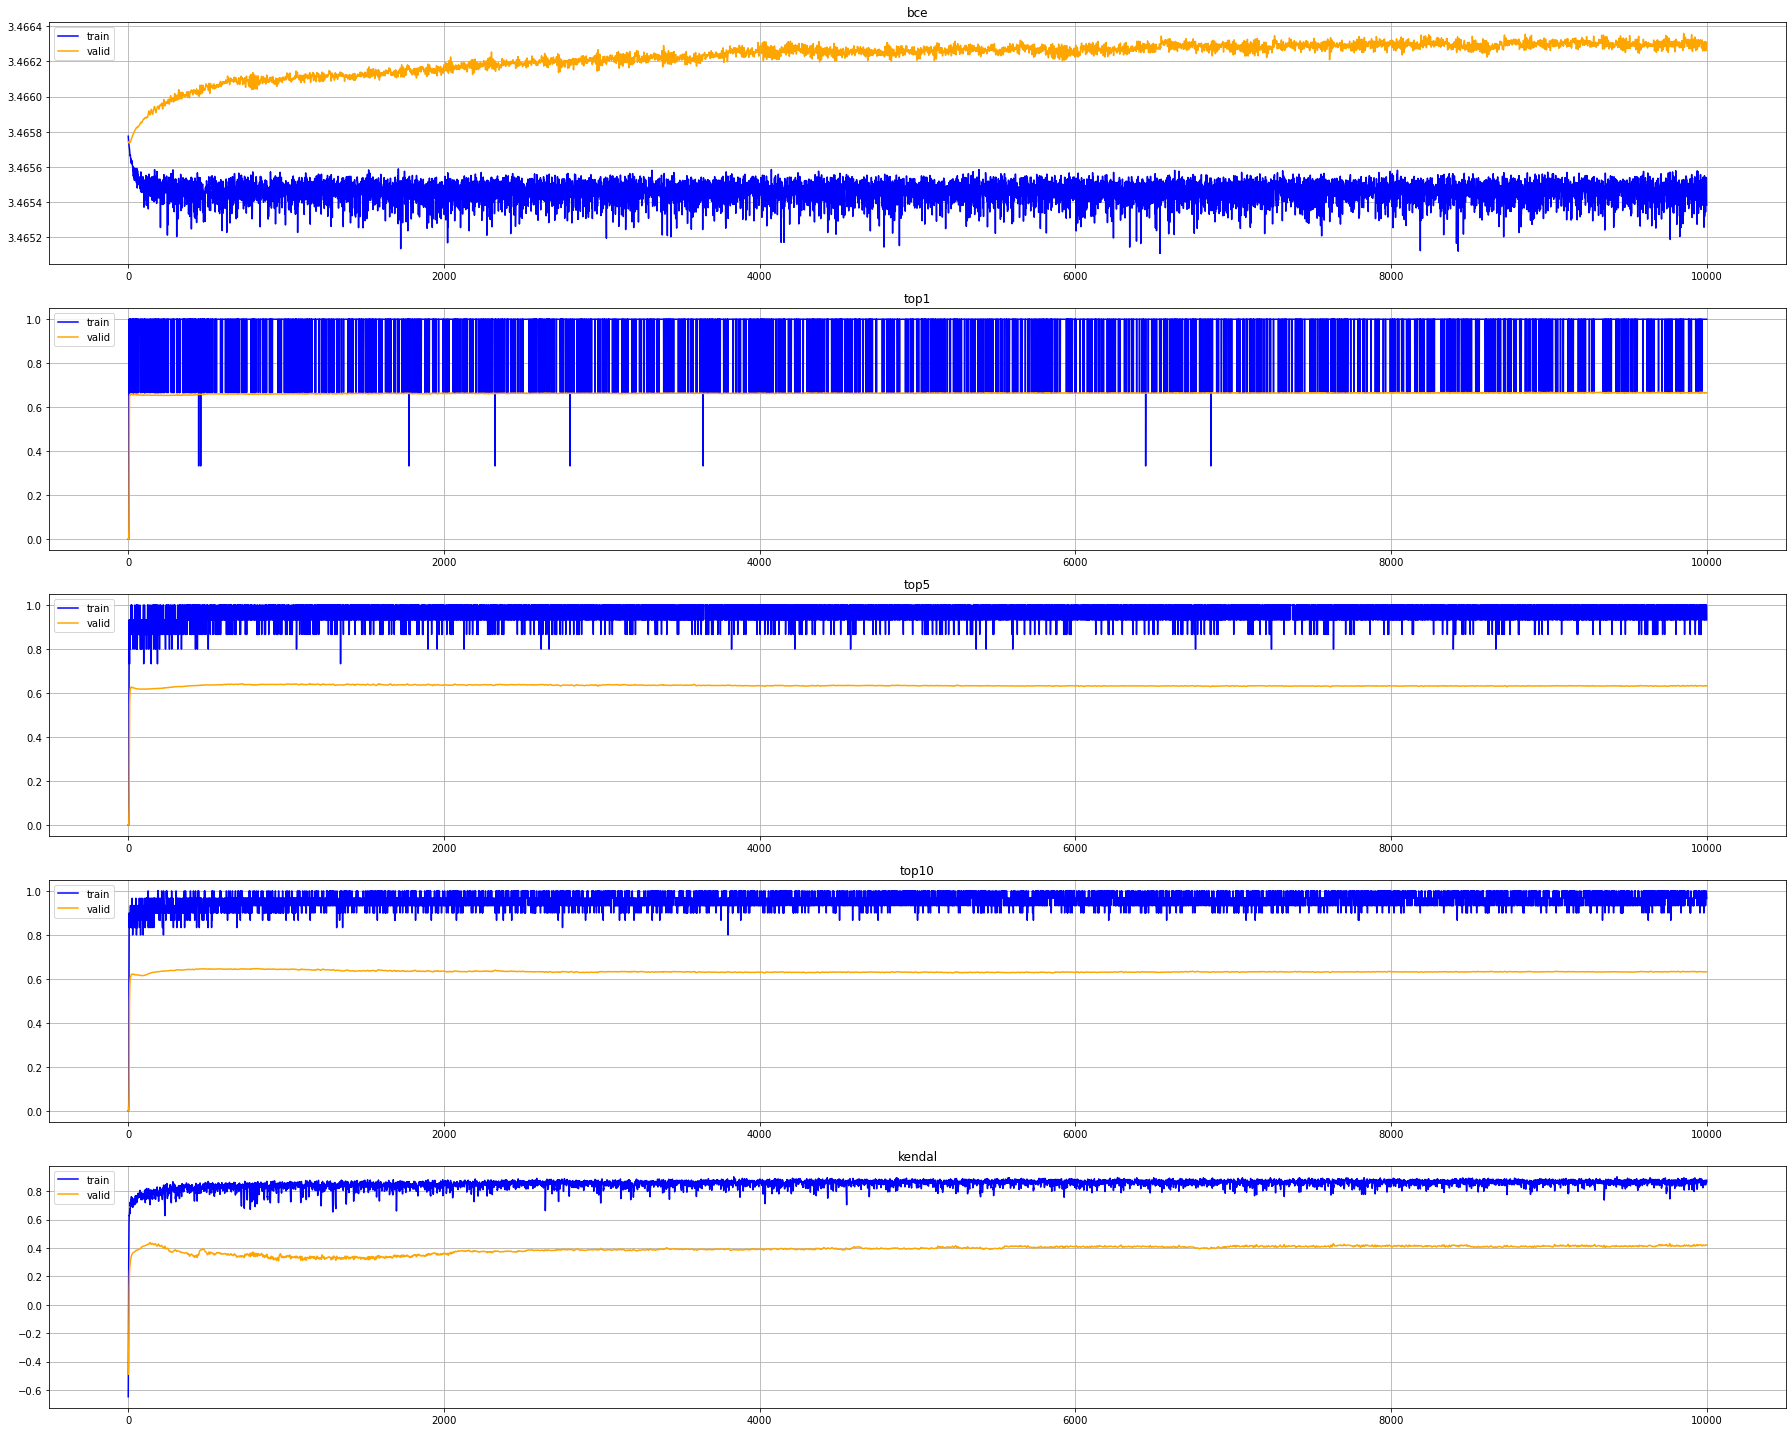

In [41]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    epochs = setting.epochs
    keys = list(train.keys())

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Baseline

In [ ]:
import networkit as nk

In [ ]:
G = nk.readGraph("/hw1_data/Synthetic/5000/0.txt", nk.Format.EdgeListTabZero)

## RK (DIAM)

### ApproxBetweenness

In [ ]:
ab = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
ab.run()

In [ ]:
# The 10 most central nodes according to betweenness are then 
ab.ranking()[:10]

## ARBA

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.ranking()[:10]

## K-BC (KPATH)

In [ ]:
kbc = nk.centrality.KPathCentrality(G, alpha=0.2, k=0)
kbc.run()

In [ ]:
kbc.ranking()[:10]